Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 7

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=7
num_BackTrack_Days=0

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=4 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=0   => 22/01
## DROP_N=15  => 06/02
## DROP_N=45  => 08/03
## DROP_N=75  => 07/04
## DROP_N=145 => 08/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=447 => 13/04/2021
## DROP_N=480 => 16/05/2021
## DROP_N=495 => 31/05/2021
## DROP_N=520 => 25/06/2021
## DROP_N=550 => 25/07/2021
#
drop_n_dataset_days=550
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
254                                           NaN                 Tunisia   
255                                           NaN                  Turkey   
256                                           NaN           United States   
257                                           NaN                  Uganda   
258                                           NaN                 Ukraine   
259                                           NaN    United Arab Emirates   
260                                      Anguilla          United Kingdom   
261                                       Bermuda          United Kingdom   
262                        British Virgin Islands          United Kingdom   
263                                Cayman Islands          United Kingdom   
264                               Channel Islands          United Kingdom   
265                   Falkland Islands (Malvinas)          United Kingdom   
266                                     Gibraltar          United Kingdom   
267                                      Guernsey          United Kingdom   
268                                   Isle of Man          United Kingdom   
269                                        Jersey          United Kingdom   
270                                    Montserrat          United Kingdom   
271  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
272                      Turks and Caicos Islands          United Kingdom   
273                                           NaN          United Kingdom   
274                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
260                                           NaN                 Tunisia   
261                                           NaN                  Turkey   
262                                           NaN           United States   
263                                           NaN                  Uganda   
264                                           NaN                 Ukraine   
265                                           NaN    United Arab Emirates   
266                                      Anguilla          United Kingdom   
267                                       Bermuda          United Kingdom   
268                        British Virgin Islands          United Kingdom   
269                                Cayman Islands          United Kingdom   
270                               Channel Islands          United Kingdom   
271                   Falkland Islands (Malvinas)          United Kingdom   
272                                     Gibraltar          United Kingdom   
273                                      Guernsey          United Kingdom   
274                                   Isle of Man          United Kingdom   
275                                        Jersey          United Kingdom   
276                                    Montserrat          United Kingdom   
277  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
278                      Turks and Caicos Islands          United Kingdom   
279                                           NaN          United Kingdom   
280                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN              Mali  17.570692   -3.996166        0        0   
186            NaN             Malta  35.937500   14.375400        0        0   
187            NaN  Marshall Islands   7.131500  171.184500        0        0   
188            NaN        Mauritania  21.007900  -10.940800        0        0   
189            NaN         Mauritius -20.348404   57.552152        0        0   
190            NaN            Mexico  23.634500 -102.552800        0        0   
191            NaN        Micronesia   7.425600  150.550800        0        0   
192            NaN           Moldova  47.411600   28.369900        0        0   
193            NaN            Monaco  43.733300    7.416700        0        0   
194            NaN          Mongolia  46.862500  103.846700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  4/23/22  4/24/22  4/25/22  \
185        0        0        0        0  ...      731      731      731   
186        0        0        0        0  ...      687      688      692   
187        0        0        0        0  ...        0        0        0   
188        0        0        0        0  ...      982      982      982   
189        0        0        0        0  ...      990      990      990   
190        0        0        0        0  ...   324120   324129   324134   
191        0        0        0        0  ...        0        0        0   
192        0        0        0        0  ...    11489    11489    11489   
193        0        0        0        0  ...       56       56       57   
194        0        0        0        0  ...     2177     2177     2177   

     4/26/22  4/27/22  4/28/22  4/29/22  4/30/22   Population   \
185      731      731      731      732      732    20,250,833   
186      693      696      698      698      698       441,543   
187        0        0        0        0        0           NaN   
188      982      982      982      982      982     4,649,658   
189      990      990      990      990      990     1,273,985   
190   324173   324221   324254   324294   324334   128,640,794   
191        0        0        0        0        0           NaN   
192    11489    11489    11489    11489    11489     4,035,942   
193       57       57       57       57       57        39,183   
194     2177     2177     2177     2179     2179     3,278,290   

                   region  
185              Mali_nan  
186             Malta_nan  
187  Marshall Islands_nan  
188        Mauritania_nan  
189         Mauritius_nan  
190            Mexico_nan  
191        Micronesia_nan  
192           Moldova_nan  
193            Monaco_nan  
194          Mongolia_nan  

[10 rows x 836 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  \
175                               NaN        Moldova  47.411600   28.36990   
176                               NaN         Monaco  43.733300    7.41670   
177                               NaN       Mongolia  46.862500  103.84670   
178                               NaN     Montenegro  42.708678   19.37439   
179                               NaN        Morocco  31.791700   -7.09260   
180                               NaN     Mozambique -18.665700   35.52960   
181                               NaN        Namibia -22.957600   18.49040   
182                               NaN          Nepal  28.166700   84.25000   
183                             Aruba    Netherlands  12.521100  -69.96830   
184  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.23850   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  4/23/22  \
175        0        0        0        0        0        0  ...        0   
176        0        0        0        0        0        0  ...        0   
177        0        0        0        0        0        0  ...        0   
178        0        0        0        0        0        0  ...        0   
179        0        0        0        0        0        0  ...        0   
180        0        0        0        0        0        0  ...        0   
181        0        0        0        0        0        0  ...        0   
182        0        0        0        0        0        0  ...        0   
183        0        0        0        0        0        0  ...        0   
184        0        0        0        0        0        0  ...        0   

     4/24/22  4/25/22  4/26/22  4/27/22  4/28/22  4/29/22  4/30/22  \
175        0        0        0        0        0        0        0   
176        0        0        0        0        0        0        0   
177        0        0        0        0        0        0        0   
178        0        0        0        0        0        0        0   
179        0        0        0        0        0        0        0   
180        0        0        0        0        0        0        0   
181        0        0        0        0        0        0        0   
182        0        0        0        0        0        0        0   
183        0        0        0        0        0        0        0   
184        0        0        0        0        0        0        0   

      Population                                         region  
175     4,035,942                                   Moldova_nan  
176        39,183                                    Monaco_nan  
177     3,278,290                                  Mongolia_nan  
178       622 500                                Montenegro_nan  
179    36,817,128                                   Morocco_nan  
180    31,542,919                                Mozambique_nan  
181     2,540,905                                   Namibia_nan  
182    29,300,000                                     Nepal_nan  
183       116,600                             Netherlands_Aruba  
184        26,000  Netherlands_Bonaire, Sint Eustatius and Saba  

[10 rows x 836 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN              Mali  17.570692   -3.996166        0        0   
186            NaN             Malta  35.937500   14.375400        0        0   
187            NaN  Marshall Islands   7.131500  171.184500        0        0   
188            NaN        Mauritania  21.007900  -10.940800        0        0   
189            NaN         Mauritius -20.348404   57.552152        0        0   
190            NaN            Mexico  23.634500 -102.552800        0        0   
191            NaN        Micronesia   7.425600  150.550800        0        0   
192            NaN           Moldova  47.411600   28.369900        0        0   
193            NaN            Monaco  43.733300    7.416700        0        0   
194            NaN          Mongolia  46.862500  103.846700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  4/23/22  4/24/22  4/25/22  \
185        0        0        0        0  ...    30727    30740    30752   
186        0        0        0        0  ...    90399    90595    90773   
187        0        0        0        0  ...       15       15       17   
188        0        0        0        0  ...    58683    58683    58685   
189        0        0        0        0  ...   220344   220344   220344   
190        0        0        0        0  ...  5733428  5733785  5733925   
191        0        0        0        0  ...        1        1        3   
192        0        0        0        0  ...   516986   516986   516986   
193        0        0        0        0  ...    11604    11604    11632   
194        0        0        0        0  ...   920361   920361   920436   

     4/26/22  4/27/22  4/28/22  4/29/22  4/30/22   Population   \
185    30769    30785    30804    30815    30833    20,250,833   
186    91032    91221    91427    91605    91741       441,543   
187       17       17       17       17       17           NaN   
188    58686    58686    58686    58687    58688     4,649,658   
189   220344   220344   220344   220344   220344     1,273,985   
190  5735115  5736579  5737811  5738769  5739680   128,640,794   
191        3        5        5        5        5           NaN   
192   516986   516986   516986   516986   516986     4,035,942   
193    11677    11712    11736    11762    11770        39,183   
194   920486   920553   920595   920671   920671     3,278,290   

                   region  
185              Mali_nan  
186             Malta_nan  
187  Marshall Islands_nan  
188        Mauritania_nan  
189         Mauritius_nan  
190            Mexico_nan  
191        Micronesia_nan  
192           Moldova_nan  
193            Monaco_nan  
194          Mongolia_nan  

[10 rows x 836 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                            Poland  51.919400   19.145100   
221            NaN                          Portugal  39.399900   -8.224500   
222            NaN                             Qatar  25.354800   51.183900   
223            NaN                           Romania  45.943200   24.966800   
224            NaN                            Russia  61.524010  105.318756   
225            NaN                            Rwanda  -1.940300   29.873900   
226            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
227            NaN                       Saint Lucia  13.909400  -60.978900   
228            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
229            NaN                             Samoa -13.759000 -172.104600   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...   4/23/22  \
220        0        0        0        0        0        0  ...   5990853   
221        0        0        0        0        0        0  ...   3791744   
222        0        0        0        0        0        0  ...    364089   
223        0        0        0        0        0        0  ...   2887824   
224        0        0        0        0        0        0  ...  17864332   
225        0        0        0        0        0        0  ...    129772   
226        0        0        0        0        0        0  ...      5561   
227        0        0        0        0        0        0  ...     23239   
228        0        0        0        0        0        0  ...      8383   
229        0        0        0        0        0        0  ...      7185   

      4/24/22   4/25/22   4/26/22   4/27/22   4/28/22   4/29/22   4/30/22  \
220   5991197   5991464   5992820   5993861   5994818   5995674   5996514   
221   3791744   3791744   3791744   3815103   3828216   3853800   3853800   
222    364187    364300    364371    364421    364498    364560    364602   
223   2888318   2888639   2889363   2890827   2891973   2892989   2893876   
224  17872625  17880154  17887152  17894787  17902334  17909924  17917191   
225    129772    129785    129788    129791    129797    129799    129806   
226      5561      5562      5562      5562      5562      5562      5562   
227     23239     23285     23285     23285     23361     23394     23394   
228      8383      8394      8404      8406      8413      8419      8419   
229      7185      7185      8351      8351      8995      9592      9592   

      Population                                 region  
220    37,980,000                            Poland_nan  
221    10,290,000                          Portugal_nan  
222     2,870,256                             Qatar_nan  
223    19,530,000                           Romania_nan  
224   144,500,000                            Russia_nan  
225    12,952,218                            Rwanda_nan  
226        53,673             Saint Kitts and Nevis_nan  
227       184,106                       Saint Lucia_nan  
228       110,940  Saint Vincent and the Grenadines_nan  
229           NaN                             Samoa_nan  

[10 rows x 836 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

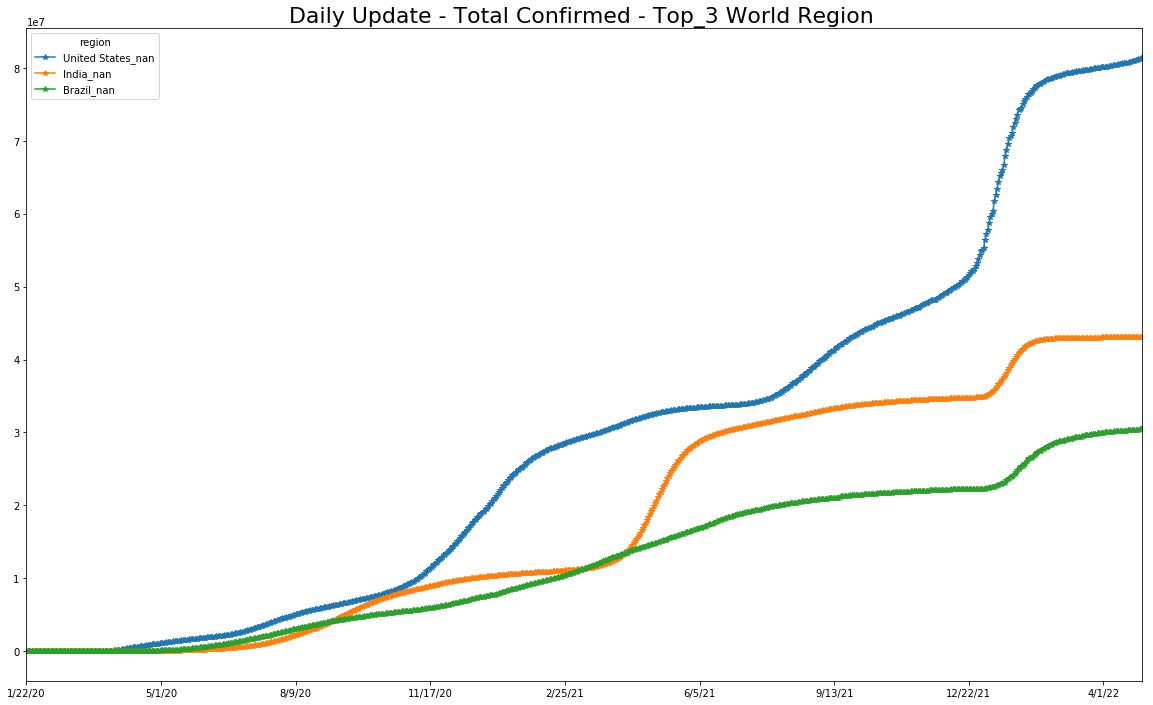

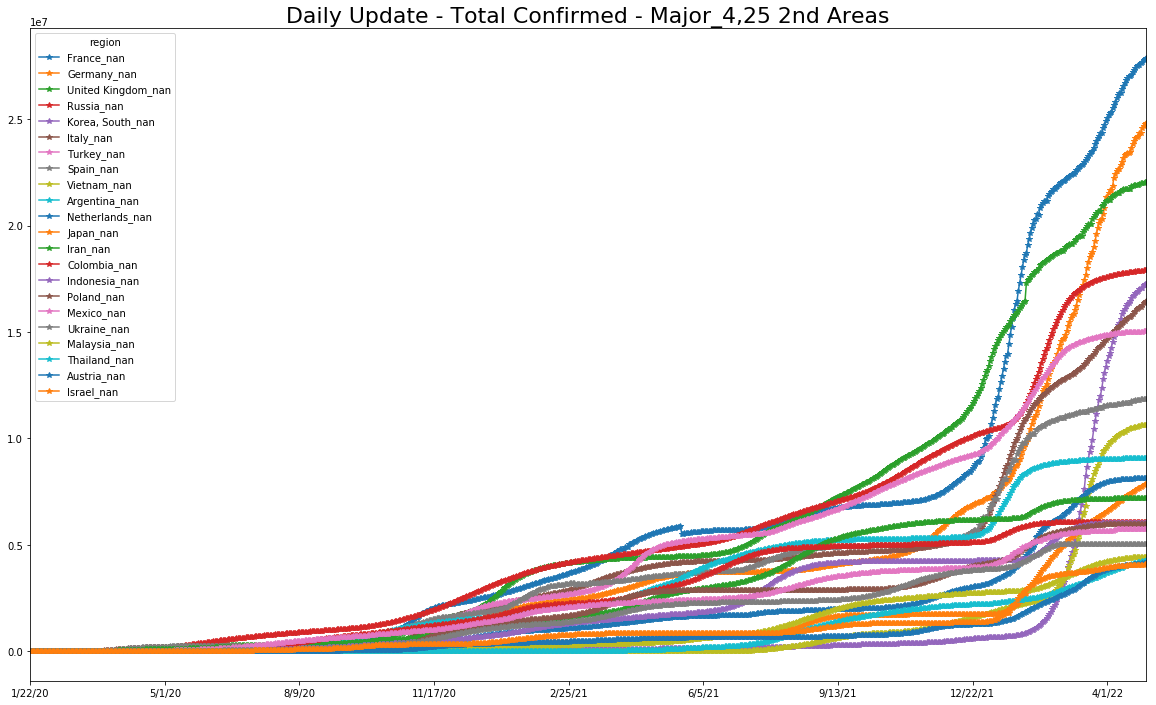

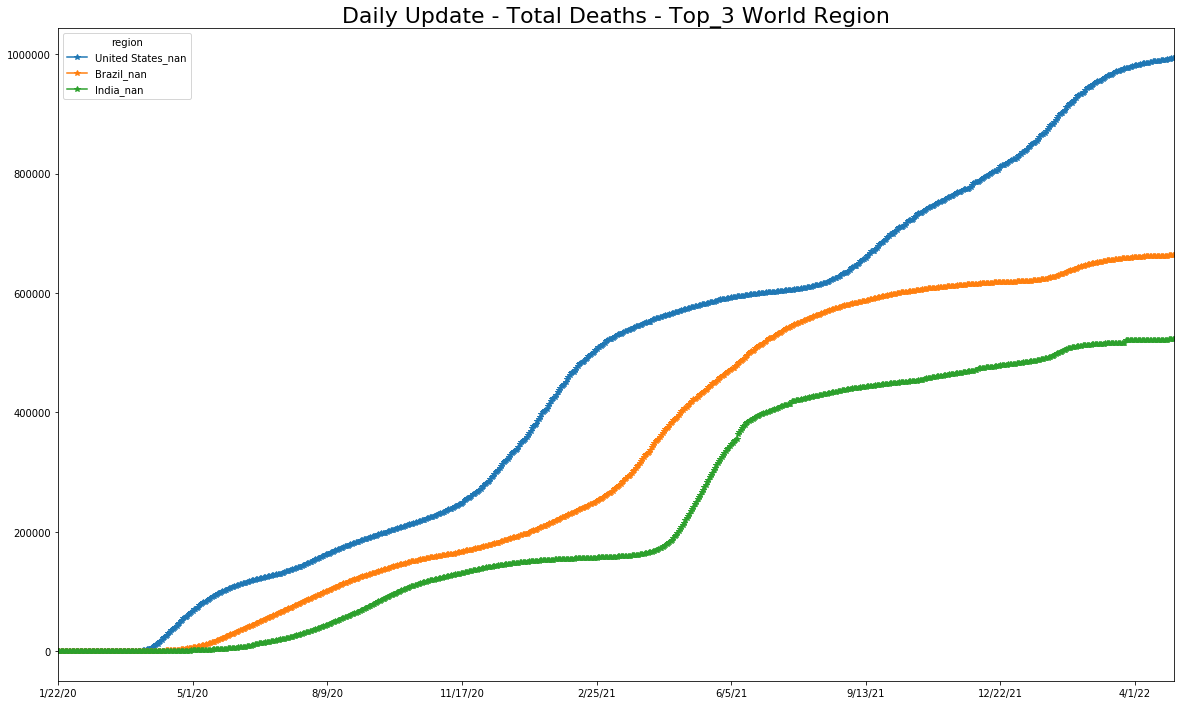

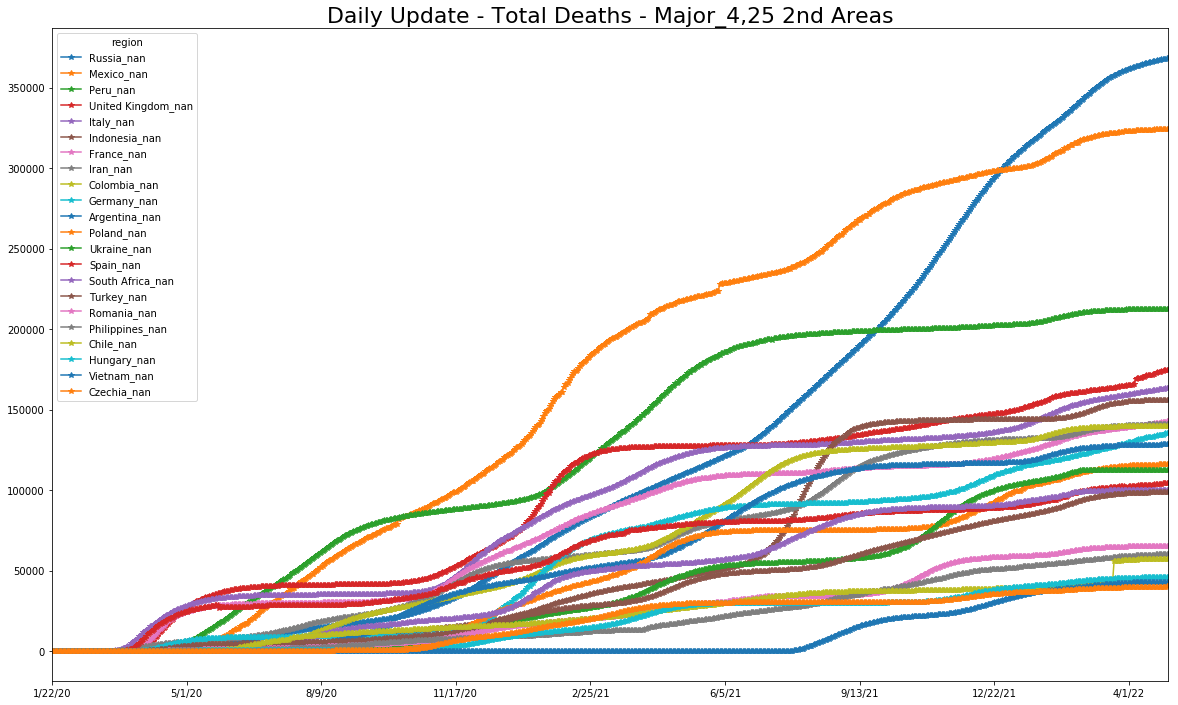

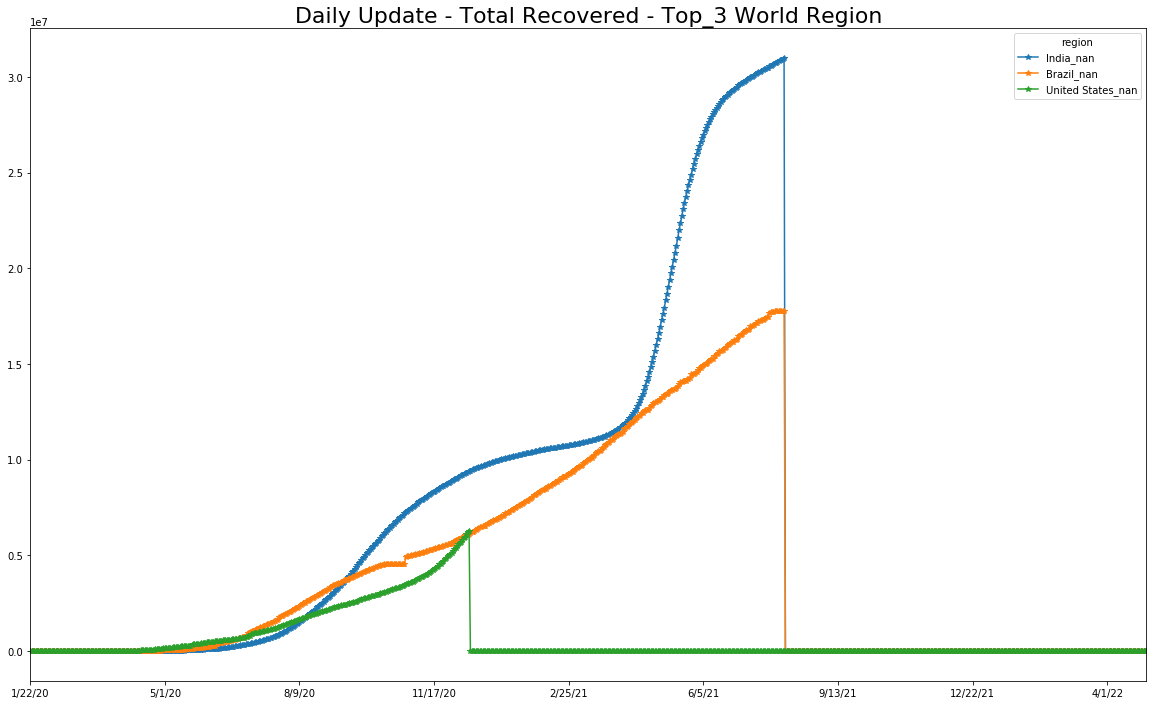

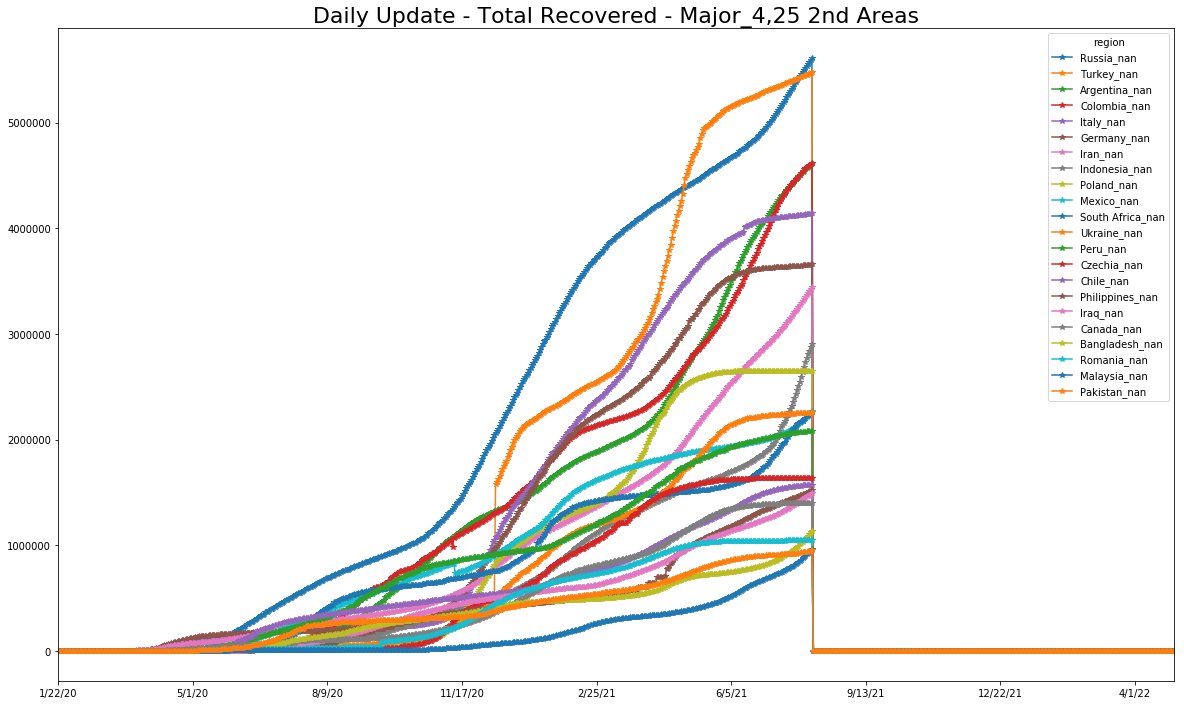

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2022/05/01


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
7/25/21           143871       132875       162155        14498       41780   
7/26/21           144285       132891       163660        14577       41879   
7/27/21           145008       132922       165204        14586       42110   

region   Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
7/25/21               0                     1280        4846615       228798   
7/26/21               0                     1280        4859170       228910   
7/27/21               0                     1288        4875927       229090   

region   Australia_Australian Capital Territory  ...  Uruguay_nan  \
7/25/21                                     124  ...       380431   
7/26/21                                     124  ...       380584   
7/27/21                                     124  ...       380793   

region   Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
7/25/21          124290            4         299822       101173   
7/26/21          124995            4         300919       106347   
7/27/21          125784            4         301979       117121   

region   West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
7/25/21                  316088                         0       7012   
7/26/21                  316088                         0       7012   
7/27/21                  316189                         0       7022   

region   Zambia_nan  Zimbabwe_nan  
7/25/21      192071         97894  
7/26/21      192316         99944  
7/27/21      192956        101711  

[3 rows x 284 columns]

In [25]:
ts[-4:]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
4/27/22           178809       274929       265773        41013       99287   
4/28/22           178850       275002       265776        41349       99287   
4/29/22           178873       275055       265779        41349       99287   
4/30/22           178879       275107       265780        41349       99287   

region   Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
4/27/22              11                     7571        9072230       422855   
4/28/22              11                     7604        9072230       422858   
4/29/22              11                     7626        9072230       422865   
4/30/22              11                     7626        9072230       422867   

region   Australia_Australian Capital Territory  ...  Uruguay_nan  \
4/27/22                                  101899  ...       895775   
4/28/22                                  103220  ...       895775   
4/29/22                                  103220  ...       897867   
4/30/22                                  104941  ...       897867   

region   Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
4/27/22          238535         7054         522263     10631516   
4/28/22          238556         7151         522263     10638632   
4/29/22          238577         7330         522305     10644700   
4/30/22          238596         7330         522325     10649809   

region   West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
4/27/22                  657060                       535      11818   
4/28/22                  657060                       535      11818   
4/29/22                  657060                       535      11818   
4/30/22                  657060                       535      11818   

region   Zambia_nan  Zimbabwe_nan  
4/27/22      319431        247729  
4/28/22      319594        247784  
4/29/22      319594        247842  
4/30/22      319594        247875  

[4 rows x 284 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-07-26  Afghanistan_nan     144285             0             0   
2     2021-07-27  Afghanistan_nan     145008           414             0   
3     2021-07-28  Afghanistan_nan     145552           723             0   
4     2021-07-29  Afghanistan_nan     145996           544          1681   
5     2021-07-30  Afghanistan_nan     146523           444          1711   
6     2021-07-31  Afghanistan_nan     147154           527          1515   
7     2021-08-01  Afghanistan_nan     147501           631          1602   
8     2021-08-02  Afghanistan_nan     147985           347          1505   
9     2021-08-03  Afghanistan_nan     148572           484          1462   
10    2021-08-04  Afghanistan_nan     148933           587          1418   
11    2021-08-05  Afghanistan_nan     149361           361          1432   
12    2021-08-06  Afghanistan_nan     149810           428          1376   
13    2021-08-07  Afghanistan_nan     150240           449          1238   
14    2021-08-08  Afghanistan_nan     150458           430          1307   
15    2021-08-09  Afghanistan_nan     150778           218          1097   
16    2021-08-10  Afghanistan_nan     151013           320           968   
17    2021-08-11  Afghanistan_nan     151291           235           773   
18    2021-08-12  Afghanistan_nan     151563           278           833   
19    2021-08-13  Afghanistan_nan     151770           272           785   
20    2021-08-14  Afghanistan_nan     151941           207           757   
21    2021-08-15  Afghanistan_nan     152033           171           650   
22    2021-08-16  Afghanistan_nan     152142            92           470   
23    2021-08-17  Afghanistan_nan     152243           109           372   
24    2021-08-18  Afghanistan_nan     152363           101           302   
25    2021-08-19  Afghanistan_nan     152411           120           330   
26    2021-08-20  Afghanistan_nan     152448            48           269   
27    2021-08-21  Afghanistan_nan     152497            37           205   
28    2021-08-22  Afghanistan_nan     152511            49           134   
29    2021-08-23  Afghanistan_nan     152583            14           100   
30    2021-08-24  Afghanistan_nan     152660            72           135   
...          ...              ...        ...           ...           ...   
81460 2022-04-02     Zimbabwe_nan     246481           128           372   
81461 2022-04-03     Zimbabwe_nan     246525            67           299   
81462 2022-04-04     Zimbabwe_nan     246612            44           239   
81463 2022-04-05     Zimbabwe_nan     246744            87           198   
81464 2022-04-06     Zimbabwe_nan     246803           132           263   
81465 2022-04-07     Zimbabwe_nan     246870            59           278   
81466 2022-04-08     Zimbabwe_nan     246925            67           258   
81467 2022-04-09     Zimbabwe_nan     246925            55           181   
81468 2022-04-10     Zimbabwe_nan     246958             0           122   
81469 2022-04-11     Zimbabwe_nan     247010            33            88   
81470 2022-04-12     Zimbabwe_nan     247094            52            85   
81471 2022-04-13     Zimbabwe_nan     247160            84           169   
81472 2022-04-14     Zimbabwe_nan     247208            66           202   
81473 2022-04-15     Zimbabwe_nan     247237            48           198   
81474 2022-04-16     Zimbabwe_nan     247237            29           143   
81475 2022-04-17     Zimbabwe_nan     247278             0            77   
81476 2022-04-18     Zimbabwe_nan     247297            41            70   
81477 2022-04-19     Zimbabwe_nan     247297            19            60   
81478 2022-04-20     Zimbabwe_nan     247336             0            60   
81479 2022-04-21     Zimbabwe_nan     247383            39            58   
81480 2022-04-22     Zimbabwe_nan     247488            47  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
81489 2022-05-01  Zimbabwe_nan          0            33           146   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
81489           351         100.013319         100.058939         100.141808   

       last_day  kalman_prediction  population  infected_rate  min  max  
81489    247875           247941.0    14862924       0.000167  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
81489 2022-05-01  Zimbabwe_nan          0            33           146   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
81489           351         100.013319         100.058939         100.141808   

       last_day  kalman_prediction  population  infected_rate  min  max  
81489    247875           247941.0    14862924       0.000167  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
79801  2022-04-29  Zimbabwe_nan     247842            55           186   
79802  2022-04-30  Zimbabwe_nan     247875            58           175   
79803  2022-05-01  Zimbabwe_nan          0            33           146   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
79801           401         100.022206         100.075126         100.162101   
79802           354         100.023412         100.070663         100.143041   
79803           351         100.013319         100.058939         100.141808   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
79801               247784  ...    14862924       0.000167  NaN  NaN   
79802               247842  ...    14862924       0.000167  NaN  NaN   
79803               247875  ...    14862924       0.000167  NaN  NaN   

       population_percentage : infected_rate confirmed  \
79801                                         0.016671   
79802                                         0.016675   
79803                                         0.016677   

       population_percentage : factor 9/10 infected_rate confirmed  \
79801                                           0.150042             
79802                                           0.150077             
79803                                           0.150097             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
79801                    48.0                           3.229513   
79802                    53.0                           3.565920   
79803                    66.0                           4.440580   

       delta : roling 7day AVG  \
79801                57.285714   
79802                50.571429   
79803                50.142857   

       delta : aprox 14-day case notification rate per 100k hab  
79801                                           5.395977         
79802                                           4.763531         
79803                                           4.723162         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse         mae
273  United States_nan  2.380658e+13  4.879199e+06  395057.825


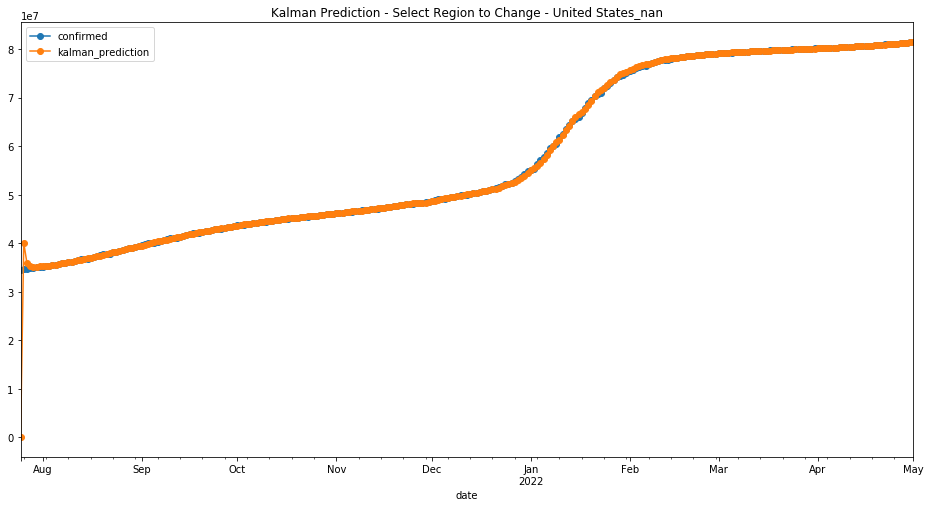

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse          rmse           mae
218  Russia_nan  1.151223e+12  1.072951e+06  79047.257143


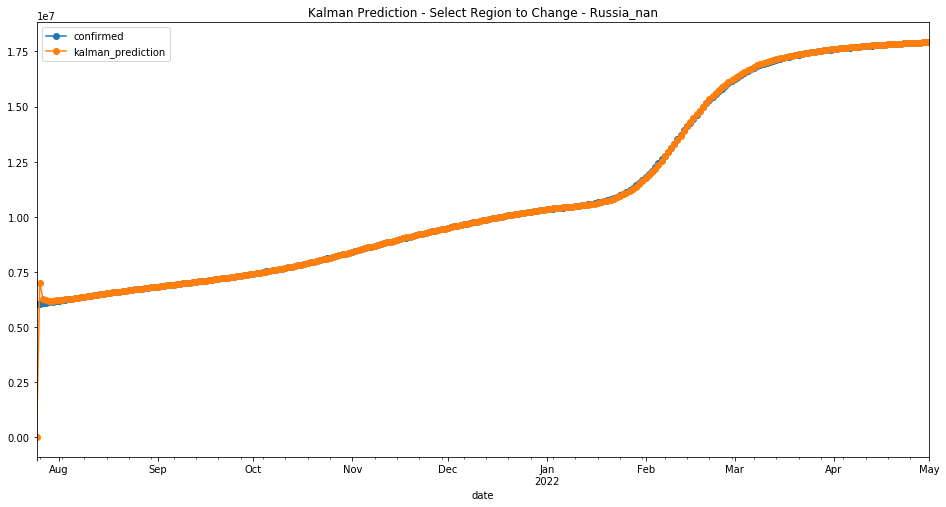

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
31  Brazil_nan  3.352124e+12  1.830881e+06  145380.460714


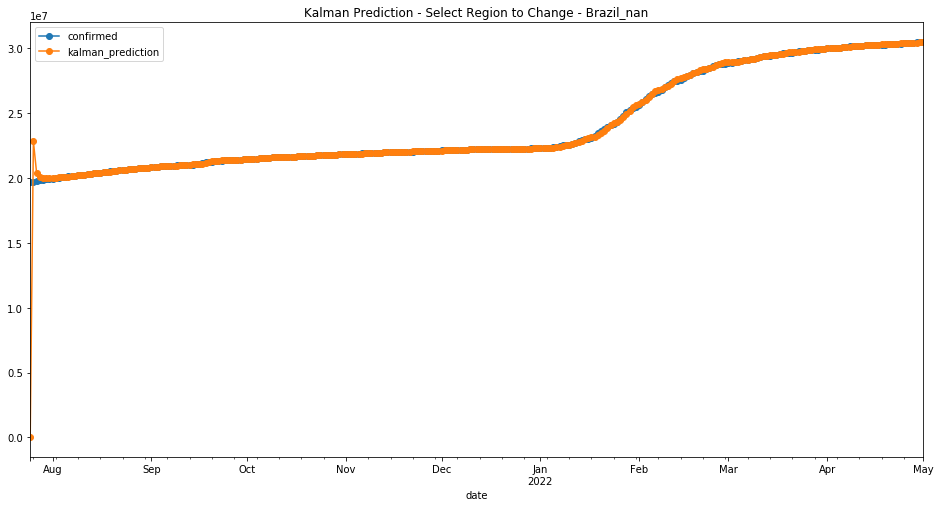

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse          rmse            mae
272  United Kingdom_nan  1.745813e+12  1.321292e+06  111910.721429


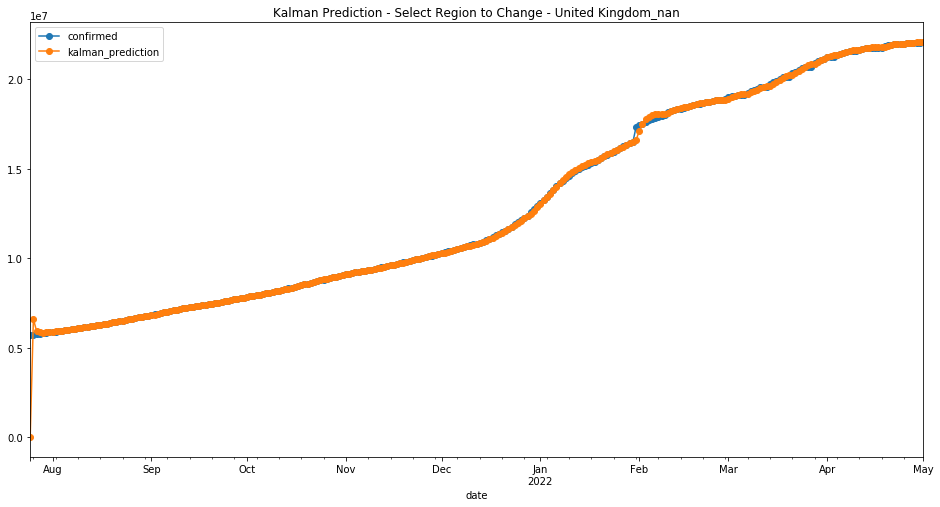

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmjs6wio1
  JVM stdout: /tmp/tmpmjs6wio1/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpmjs6wio1/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years, 6 months and 4 days !!!
H2O cluster name:           H2O_from_python_unknownUser_7k3eqb
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2022-04-24
last_train_date= 2022-04-30
first_bootstrap_date= 2022-04-22
boost_bootstrap_date= 2022-04-27
first_test_date= 2022-04-21
last_test_date= 2022-05-01
first_valid_date= 2022-04-29


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   180267.0     178638 2022-04-22  Afghanistan_nan
1   180299.0     178648 2022-04-23  Afghanistan_nan
2   180313.0     178689 2022-04-24  Afghanistan_nan
3   180343.0     178745 2022-04-25  Afghanistan_nan
4   180390.0     178769 2022-04-26  Afghanistan_nan
5   180421.0     178809 2022-04-27  Afghanistan_nan
6   180461.0     178850 2022-04-28  Afghanistan_nan
7   180500.0     178873 2022-04-29  Afghanistan_nan
8   180528.0     178879 2022-04-30  Afghanistan_nan
9   180538.0          0 2022-05-01  Afghanistan_nan
10  275617.0     274737 2022-04-22      Albania_nan
11  275739.0     274791 2022-04-23      Albania_nan
12  275792.0     274828 2022-04-24      Albania_nan
13  275846.0     274828 2022-04-25      Albania_nan
14  275856.0     274862 2022-04-26      Albania_nan
15  275888.0     274929 2022-04-27      Albania_nan
16  275945.0     275002 2022-04-28      Albania_nan
17  276009.0     275055 2022-04-29      Albania_nan
18  276068.0     275107 2022-04-30      Albania_nan
19  276126.0          0 2022-05-01      Albania_nan
20  267357.0     265761 2022-04-22      Algeria_nan
21  267363.0     265761 2022-04-23      Algeria_nan
22  267365.0     265767 2022-04-24      Algeria_nan
23  267371.0     265771 2022-04-25      Algeria_nan
24  267375.0     265772 2022-04-26      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  4119432.0    4122797 2022-04-27     Austria_nan
176  4127454.0    4129158 2022-04-28     Austria_nan
177  4133092.0    4135344 2022-04-29     Austria_nan
178  4139347.0    4140543 2022-04-30     Austria_nan
179  4144356.0          0 2022-05-01     Austria_nan
180   793461.0     792457 2022-04-22  Azerbaijan_nan
181   793471.0     792476 2022-04-23  Azerbaijan_nan
182   793495.0     792496 2022-04-24  Azerbaijan_nan
183   793515.0     792496 2022-04-25  Azerbaijan_nan
184   793513.0     792502 2022-04-26  Azerbaijan_nan
185   793521.0     792521 2022-04-27  Azerbaijan_nan
186   793538.0     792496 2022-04-28  Azerbaijan_nan
187   793507.0     792558 2022-04-29  Azerbaijan_nan
188   793578.0     792562 2022-04-30  Azerbaijan_nan
189   793567.0          0 2022-05-01  Azerbaijan_nan
190    34519.0      33446 2022-04-22     Bahamas_nan
191    34520.0      33463 2022-04-23     Bahamas_nan
192    34536.0      33483 2022-04-24     Bahamas_nan
193    34551.0      33488 2022-04-25     Bahamas_nan
194    34593.0      33498 2022-04-26     Bahamas_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date        region
220   66173.0      66810 2022-04-22  Barbados_nan
221   66790.0      67256 2022-04-23  Barbados_nan
222   67323.0      67611 2022-04-24  Barbados_nan
223   67798.0      67934 2022-04-25  Barbados_nan
224   68168.0      68440 2022-04-26  Barbados_nan
225   68460.0      68913 2022-04-27  Barbados_nan
226   68946.0      69345 2022-04-28  Barbados_nan
227   69422.0      69562 2022-04-29  Barbados_nan
228   69852.0      70080 2022-04-30  Barbados_nan
229   70046.0          0 2022-05-01  Barbados_nan
230  977567.0     976906 2022-04-22   Belarus_nan
231  978170.0     977434 2022-04-23   Belarus_nan
232  978708.0     977813 2022-04-24   Belarus_nan
233  979094.0     977962 2022-04-25   Belarus_nan
234  979220.0     978117 2022-04-26   Belarus_nan
235  979359.0     978773 2022-04-27   Belarus_nan
236  980024.0     979346 2022-04-28   Belarus_nan
237  980504.0     979909 2022-04-29   Belarus_nan
238  981075.0     980345 2022-04-30   Belarus_nan
239  981525.0          0 2022-05-01   Belarus_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  125940860117.17972
# MSE on the validation data =  115617280038888.55
# R^2 on the training data =  0.9991386391109518
# R^2 on the validation data =  0.37304352661184315


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1651384393775_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 125940860117.17972
RMSE: 354881.47333606996
MAE: 26271.805124914783
RMSLE: 0.35775686464573225
Mean Residual Deviance: 125940860117.17972

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 115617280038888.55
RMSE: 10752547.60691105
MAE: 3477589.205573438
RMSLE: 8.639369923687687
Mean Residual Deviance: 115617280038888.55
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2022-05-01 05:53:22  0.074 sec   0.0                nan                 nan                 nan                  nan                 nan                 nan
     2022-05-01 05:53:22  0.487 sec   1.0                631318.1092840913   65071.499537468895  398562555110.03986   10801535.898150638  3490710.2421875     116673177759036.9
     2022-05-01 05:53:22  0.639 sec   2.0                674398.0867402598   69861.68156796377   454812779398.9229    10774104.637052892  3481431.5661049234  116081330730164.61
     2022-05-01 05:53:22  0.759 sec   3.0                520184.4584438098   63228.05225738016   270591870806.47974   10769772.689248467  3478280.365941984   115988003778082.14
     2022-05-01 05:53:23  1.007 sec   4.0                527000.7656066566   61576.685912992245  277729806950.00214   10774243.285065377  3480074.2499808404  116084318365776.36
---  ---                  ---         ---                ---                 ---                 ---                  ---                 ---                 ---
     2022-05-01 05:53:34  12.157 sec  190.0              372820.61472099373  28285.918674936176  138995210760.93967   10759585.468614453  3479968.686050558   115768679456419.3
     2022-05-01 05:53:38  16.184 sec  271.0              365777.94783713843  27421.33185364065   133793507123.94838   10760670.462897716  3479152.489338065   115792028811079.34
     2022-05-01 05:53:42  20.227 sec  351.0              360804.85576038033  27164.4504507986    130180143940.26884   10757427.838168528  3478688.467938331   115722253693403.2
     2022-05-01 05:53:46  24.273 sec  429.0              358275.5106376768   26666.754161647223  128361341522.68808   10753129.905815827  3477541.556531307   115629802771350.67
     2022-05-01 05:53:50  27.967 sec  500.0              354881.47333606996  26271.805124914783  125940860117.17972   10752547.60691105   3477589.205573438   115617280038888.55


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  2.47433e+20            1                    0.372304
last_day           1.99832e+20            0.807619             0.30068
region             1.33963e+20            0.541409             0.201569
7_day_change       3.08524e+19            0.12469              0.0464225
3_day_change       1.68596e+19            0.068138             0.0253681
infected_rate      1.52964e+19            0.0618201            0.0230159
1_day_change       1.15464e+19            0.0466649            0.0173735
7_day_change_rate  4.82835e+18            0.0195137            0.00726505
3_day_change_rate  2.10856e+18            0.00852173           0.00317268
1_day_change_rate  1.88037e+18            0.0075995            0.00282933

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         2.474333e+20           1.000000    0.372304
1           last_day         1.998318e+20           0.807619    0.300680
2             region         1.339627e+20           0.541409    0.201569
3       7_day_change         3.085237e+19           0.124690    0.046422
4       3_day_change         1.685961e+19           0.068138    0.025368
5      infected_rate         1.529636e+19           0.061820    0.023016
6       1_day_change         1.154644e+19           0.046665    0.017374
7  7_day_change_rate         4.828350e+18           0.019514    0.007265
8  3_day_change_rate         2.108561e+18           0.008522    0.003173
9  1_day_change_rate         1.880369e+18           0.007599    0.002829

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


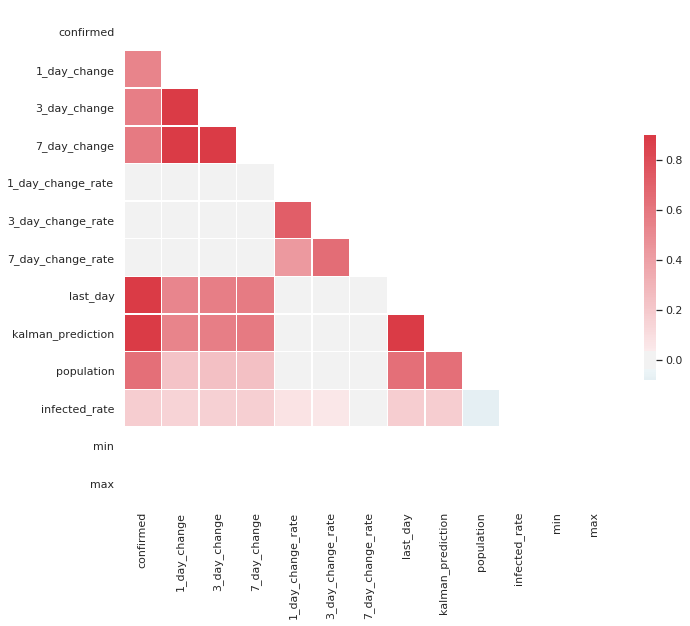

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.535194
3_day_change         0.566314
7_day_change         0.584235
1_day_change_rate    0.017255
3_day_change_rate    0.008590
7_day_change_rate   -0.001553
last_day             0.994790
kalman_prediction    0.995579
population           0.638223
infected_rate        0.176503
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


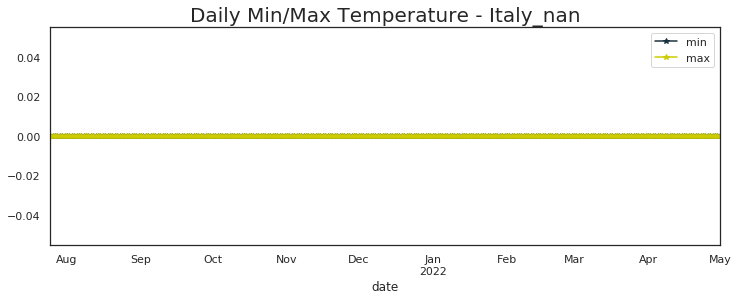

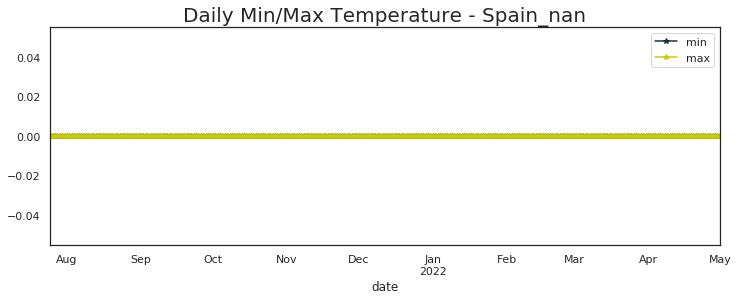

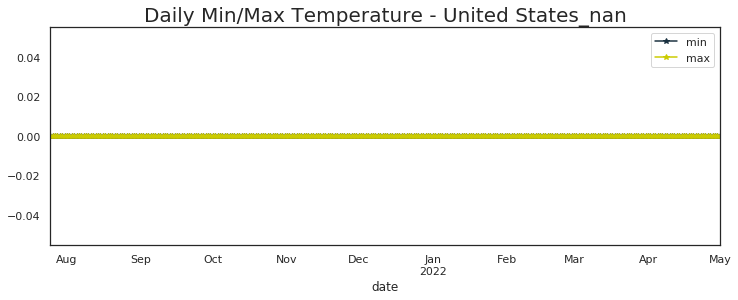

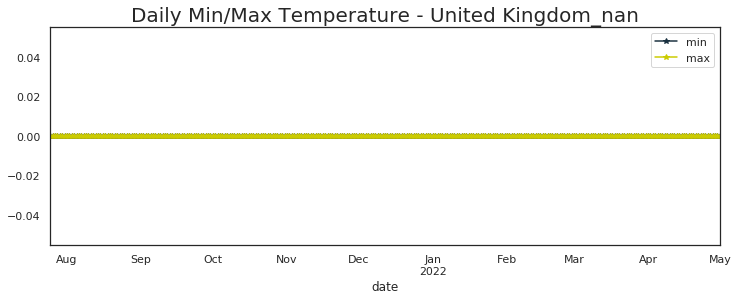

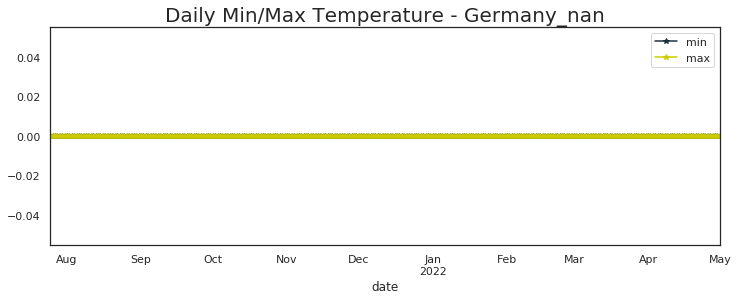

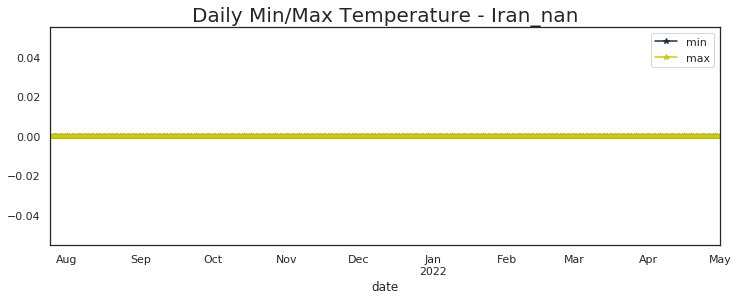

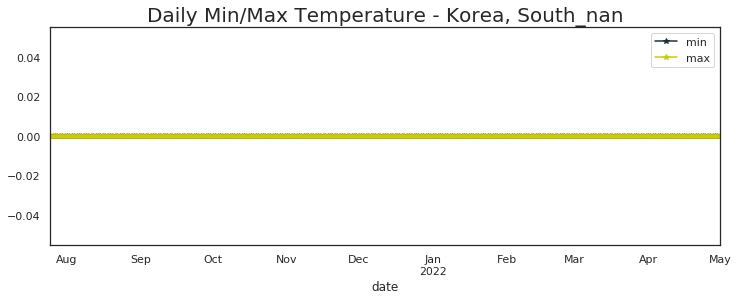

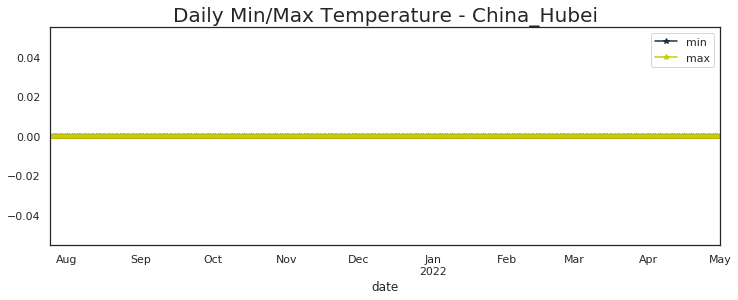

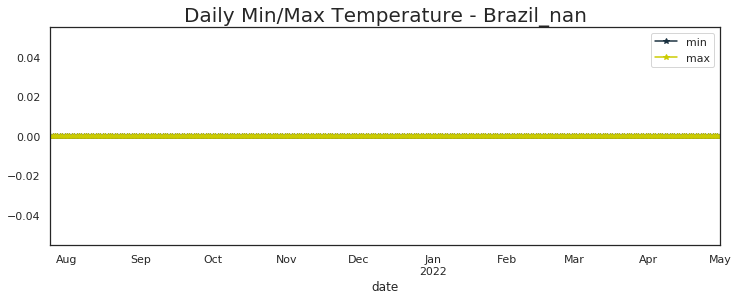

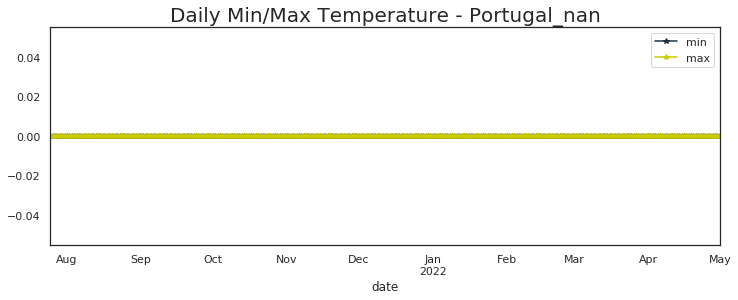

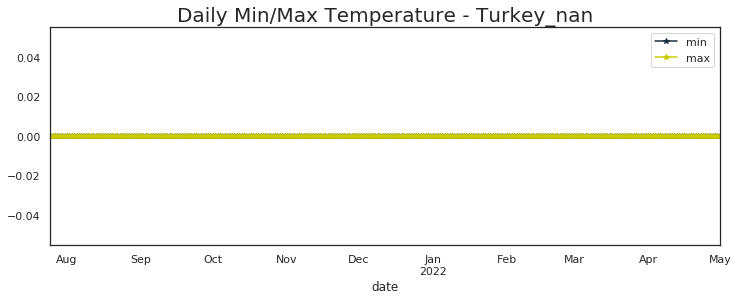

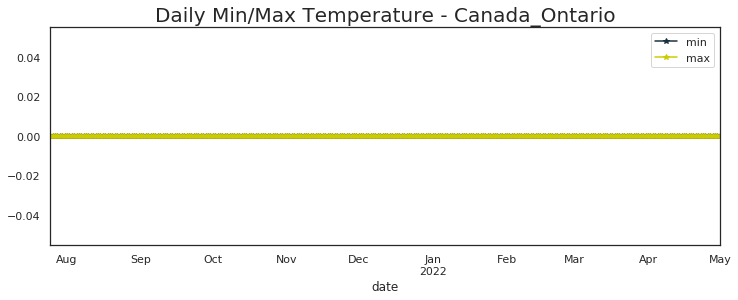

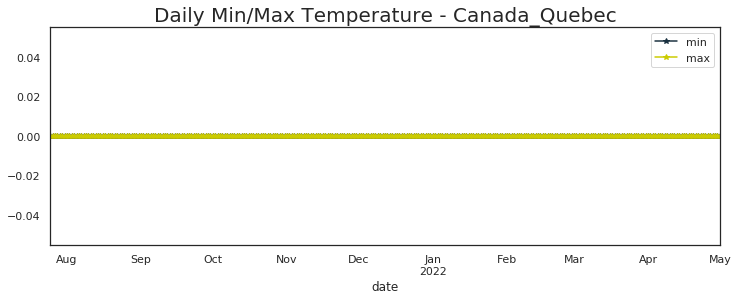

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                             min  max
region                               
United States_nan            0.0  0.0
India_nan                    0.0  0.0
Brazil_nan                   0.0  0.0
France_nan                   0.0  0.0
Germany_nan                  0.0  0.0
United Kingdom_nan           0.0  0.0
Russia_nan                   0.0  0.0
Korea, South_nan             0.0  0.0
Italy_nan                    0.0  0.0
Turkey_nan                   0.0  0.0
Spain_nan                    0.0  0.0
Vietnam_nan                  0.0  0.0
Argentina_nan                0.0  0.0
Netherlands_nan              0.0  0.0
Japan_nan                    0.0  0.0
Iran_nan                     0.0  0.0
Colombia_nan                 0.0  0.0
Indonesia_nan                0.0  0.0
Poland_nan                   0.0  0.0
Mexico_nan                   0.0  0.0
Ukraine_nan                  0.0  0.0
Malaysia_nan                 0.0  0.0
Thailand_nan                 0.0  0.0
Austria_nan   

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

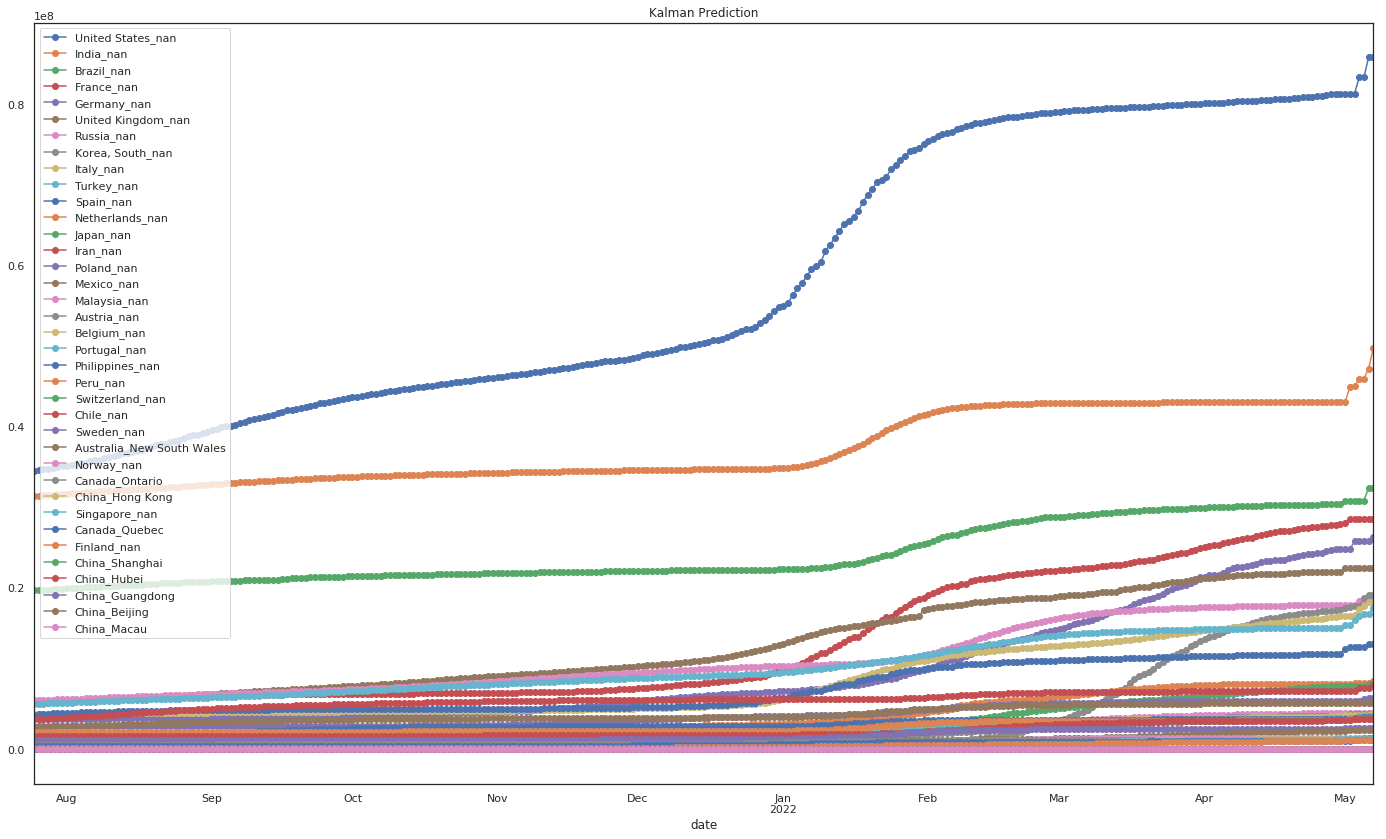

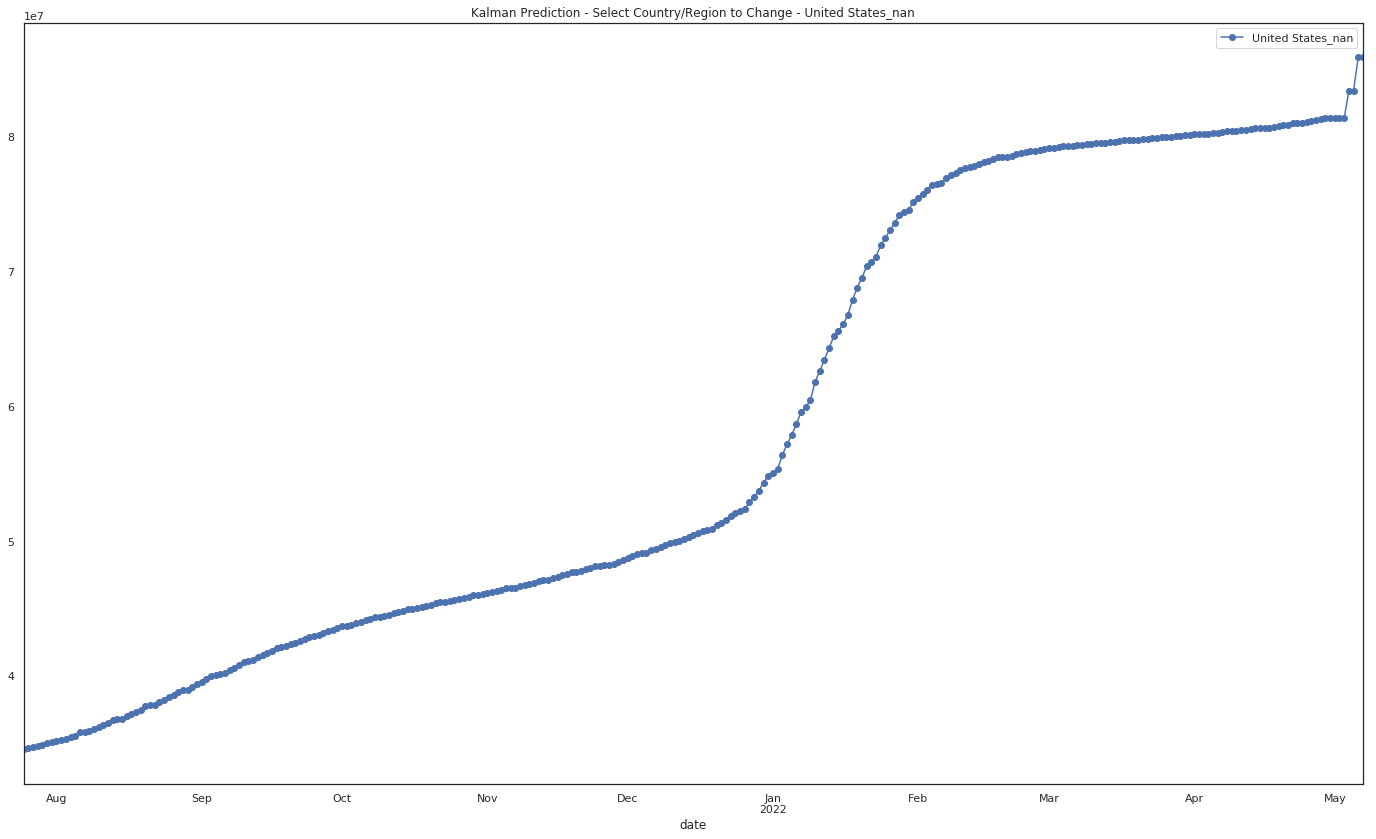

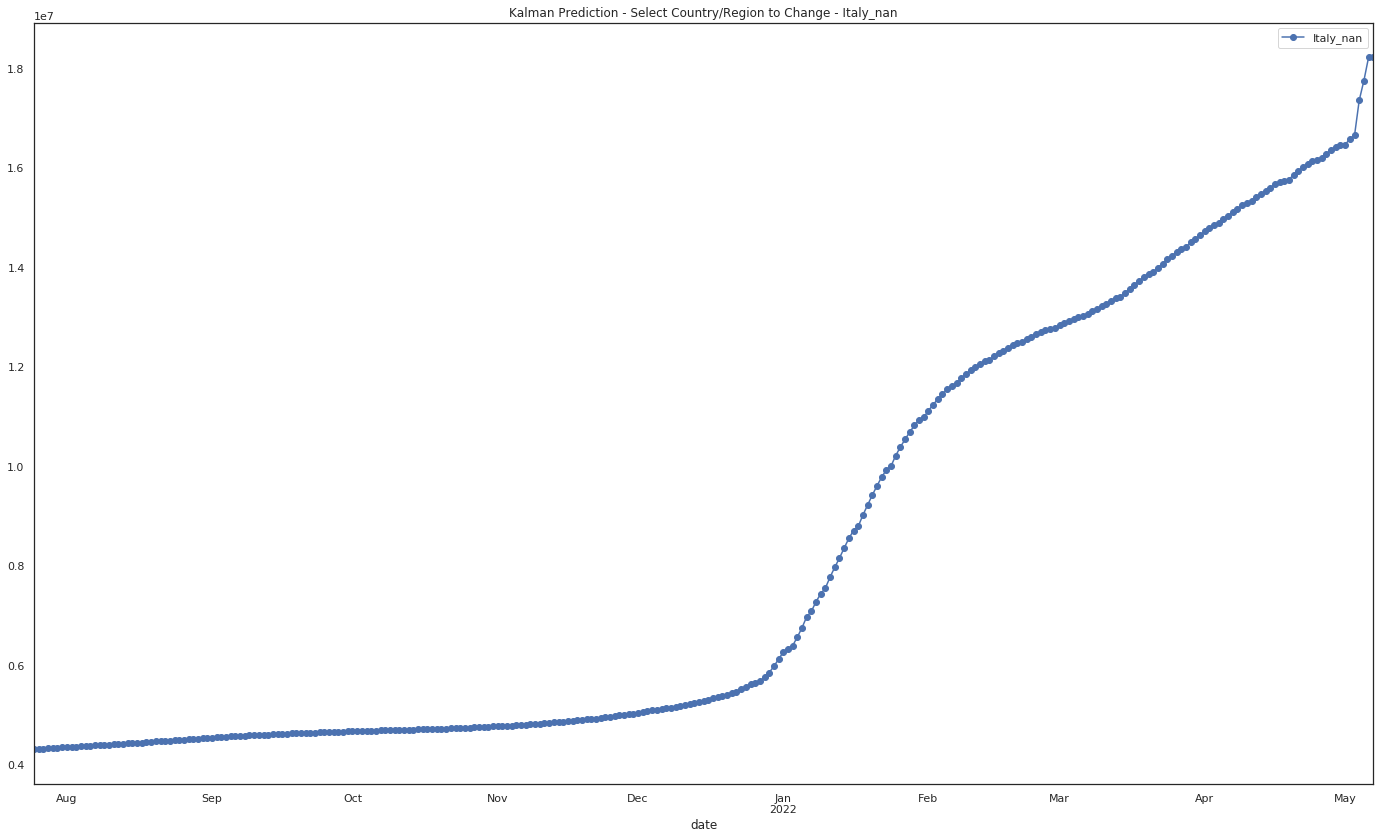

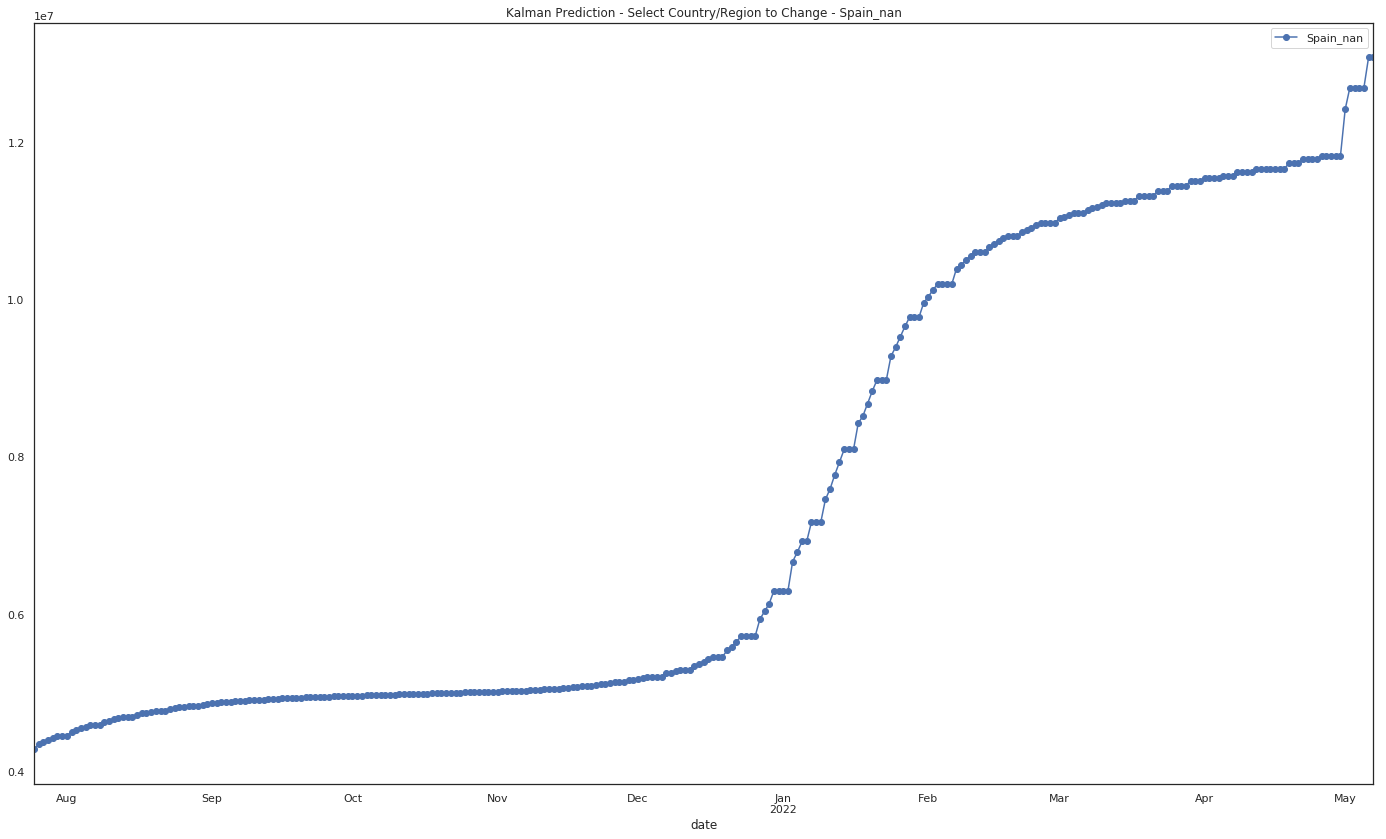

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


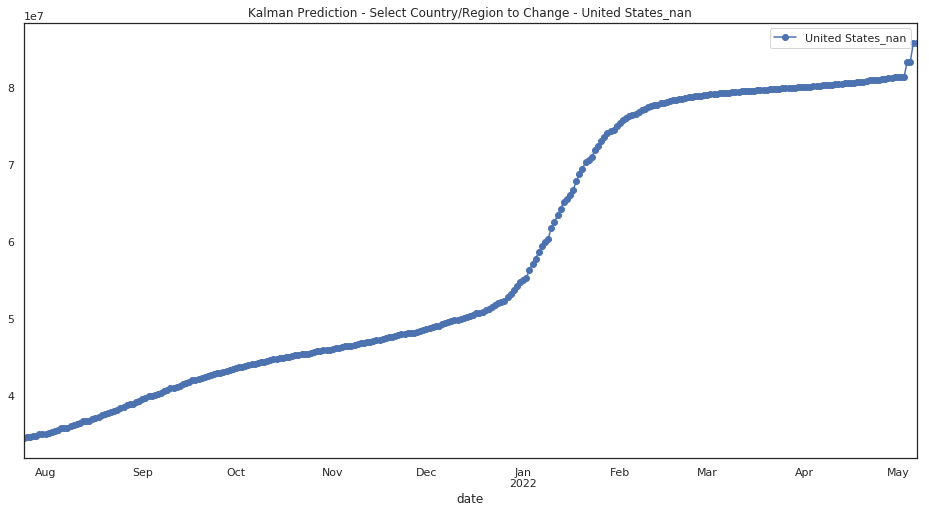

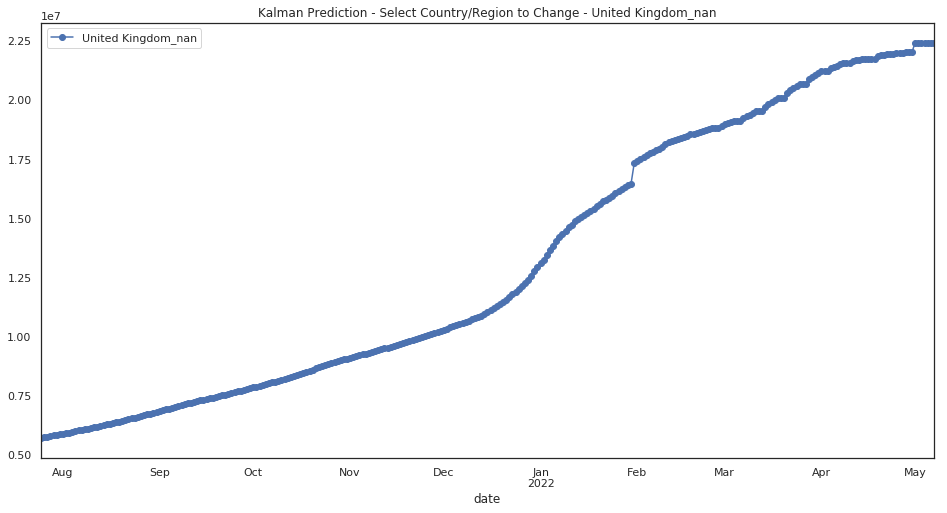

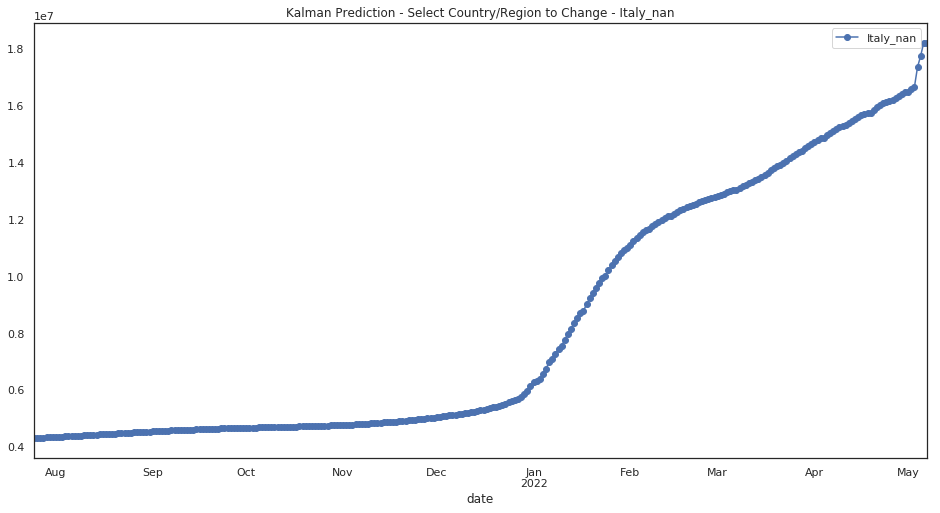

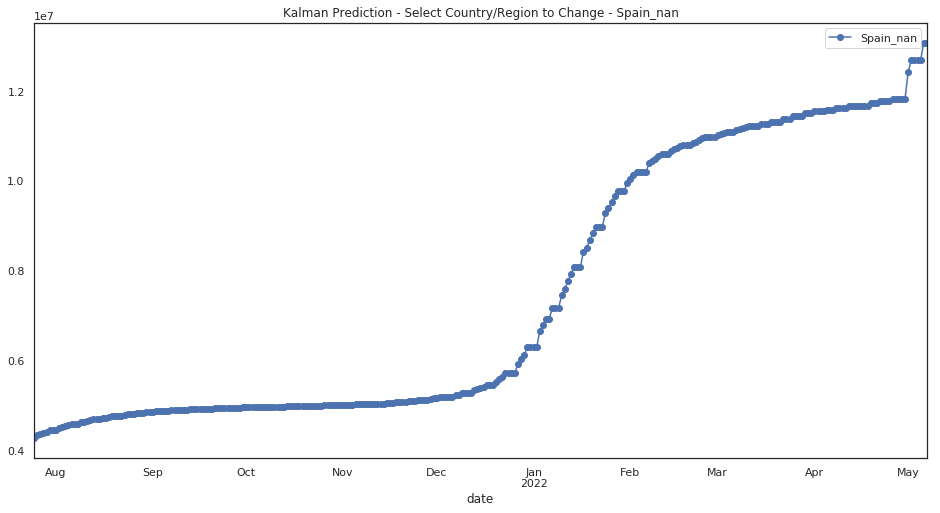

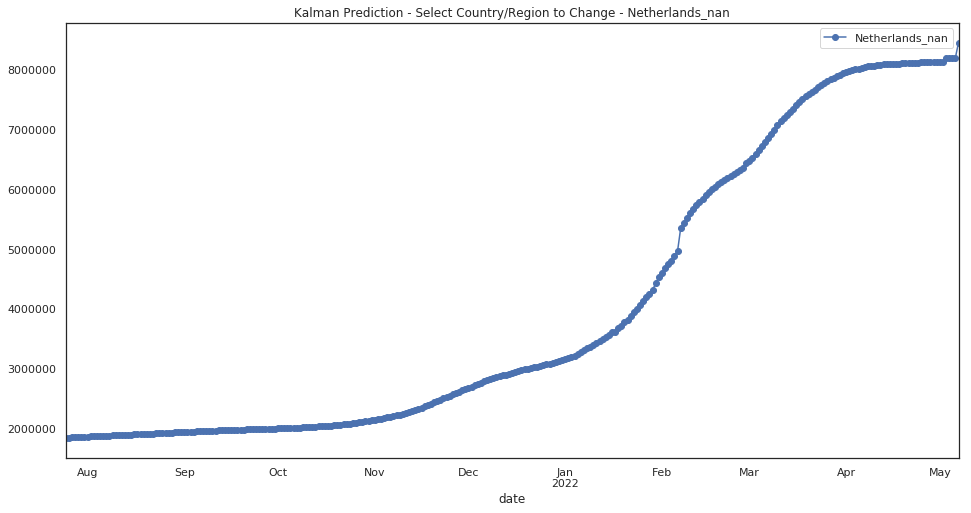

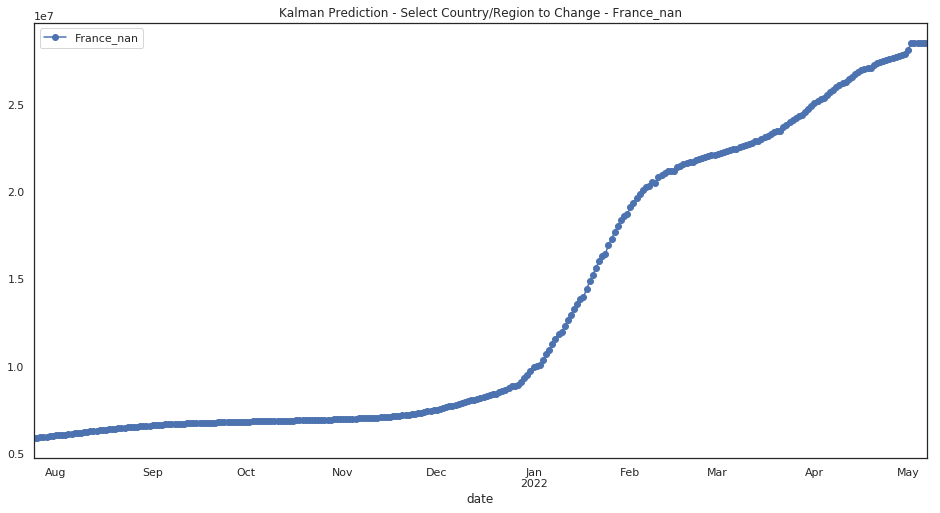

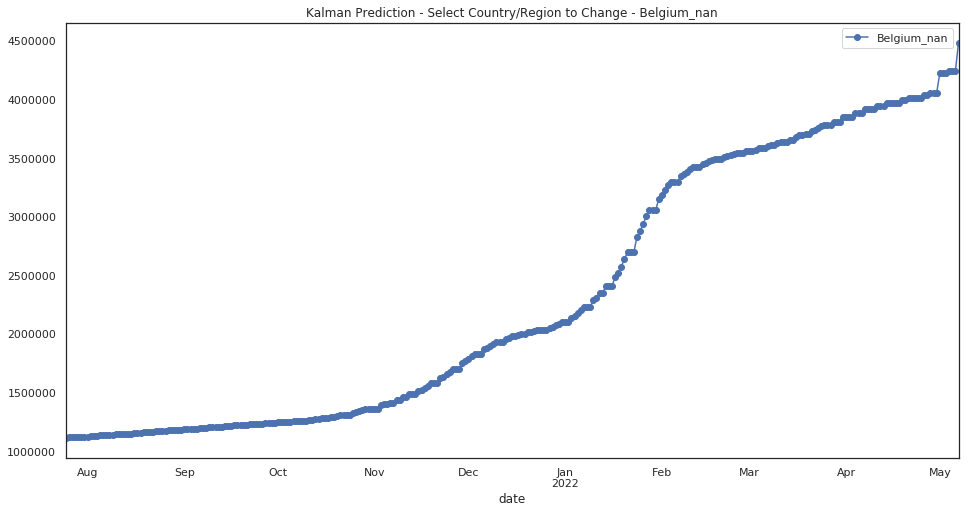

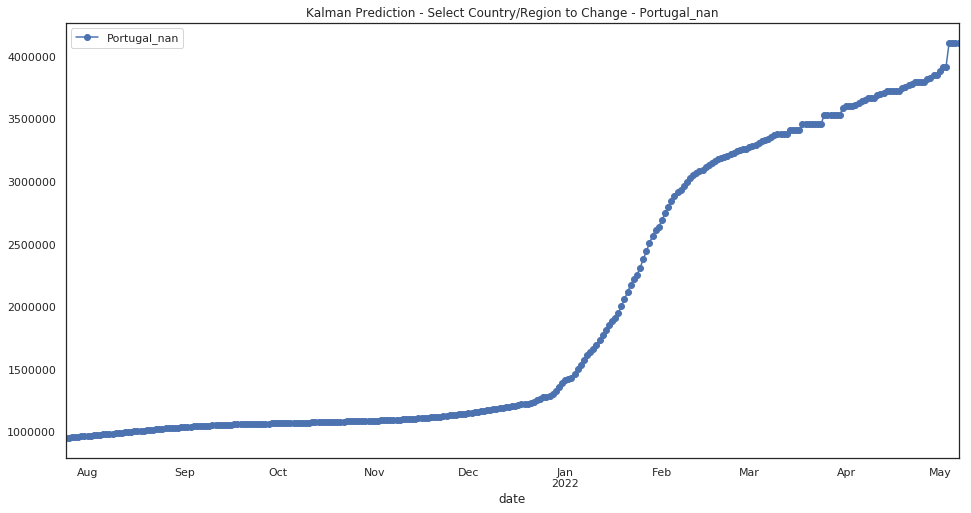

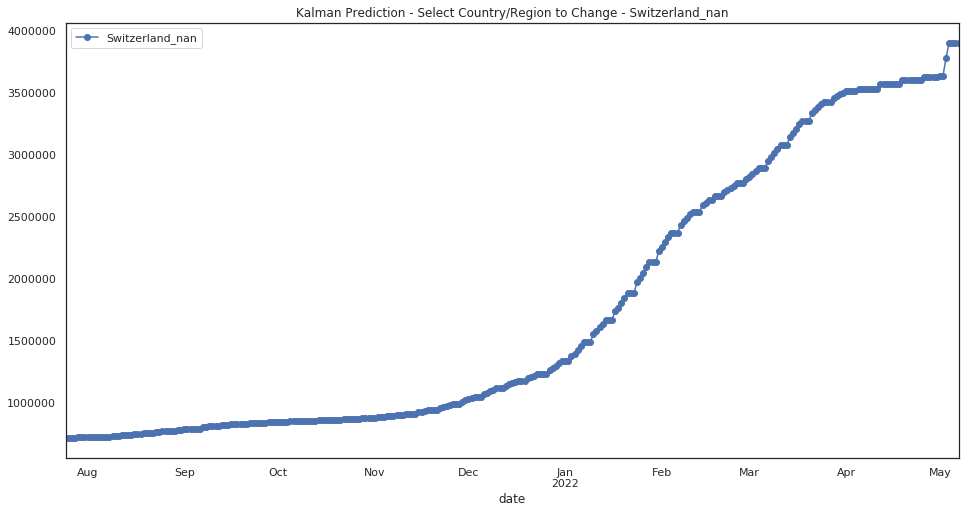

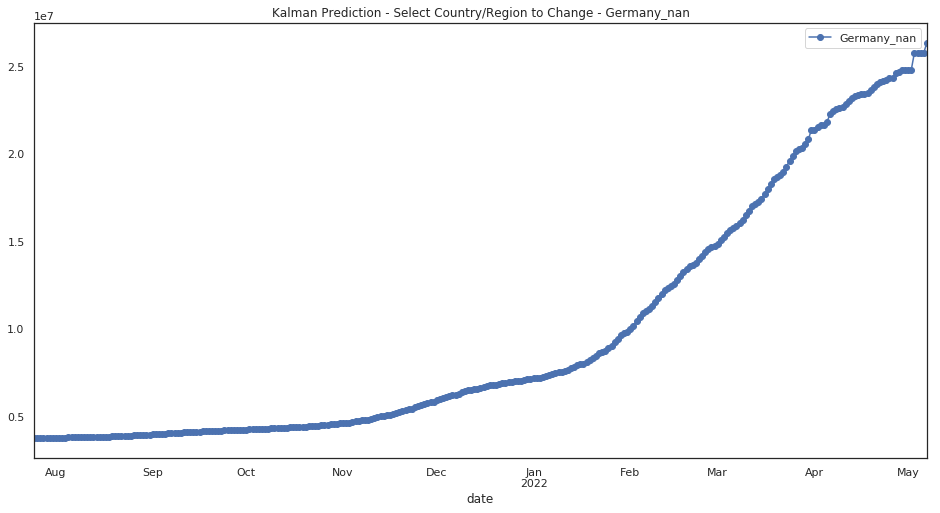

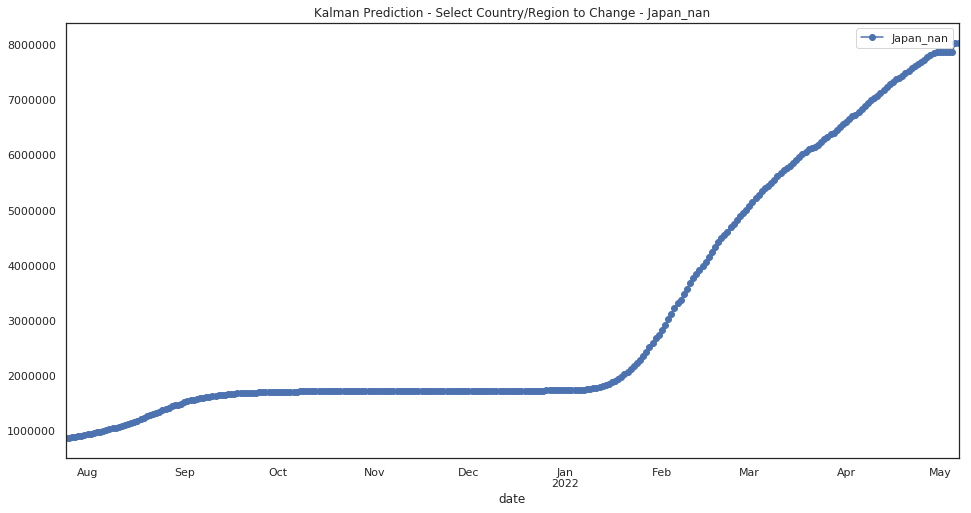

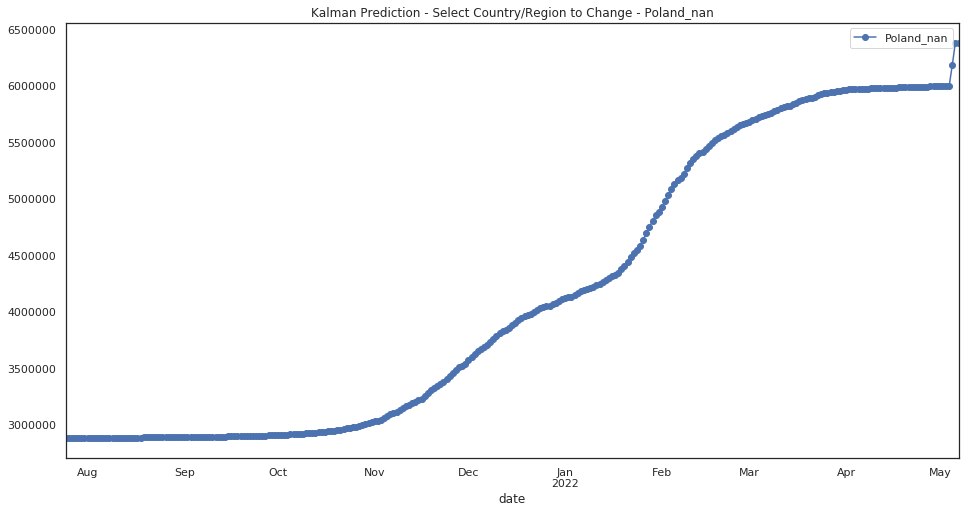

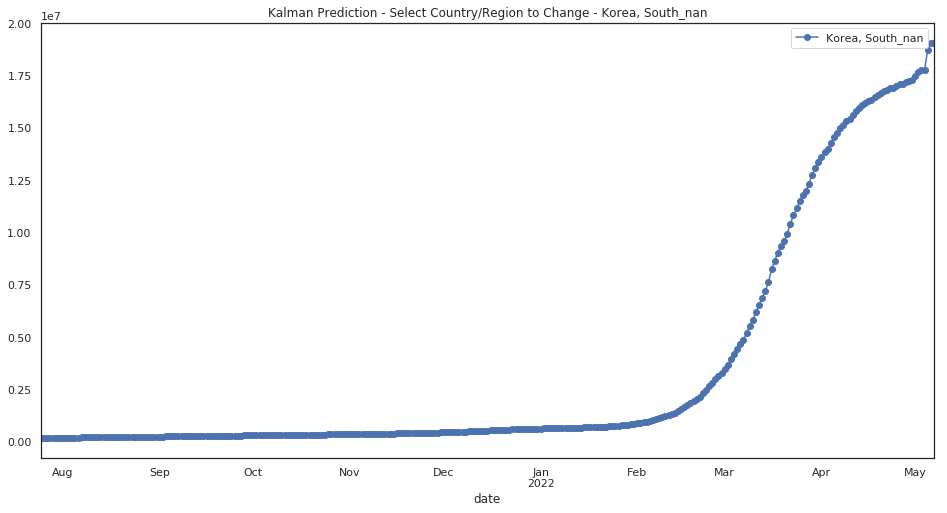

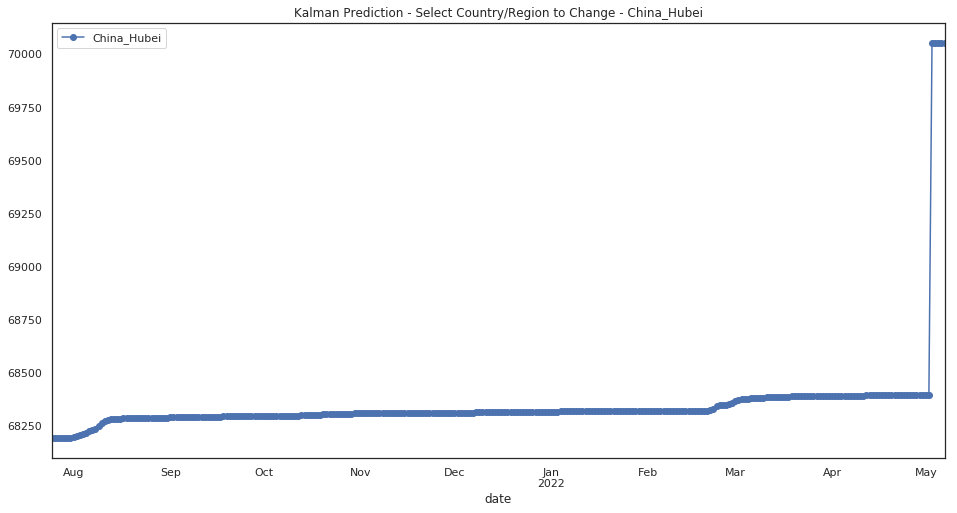

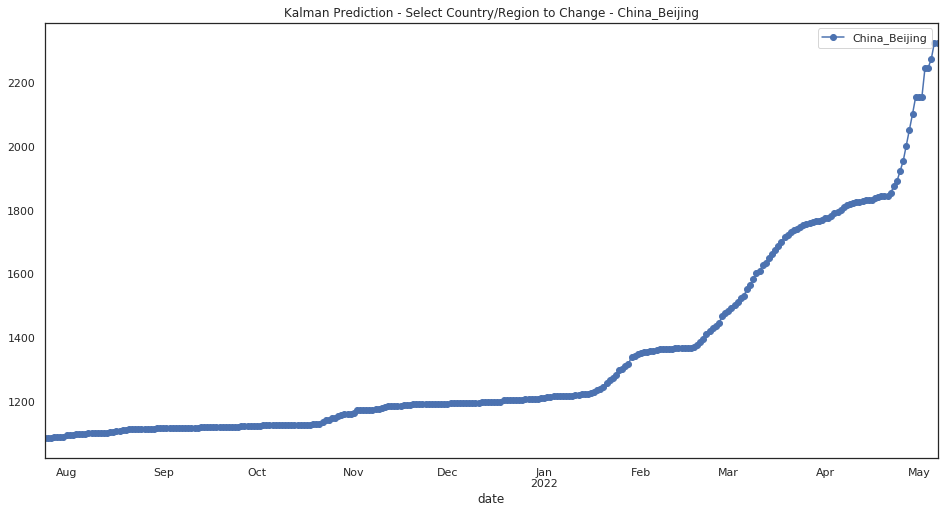

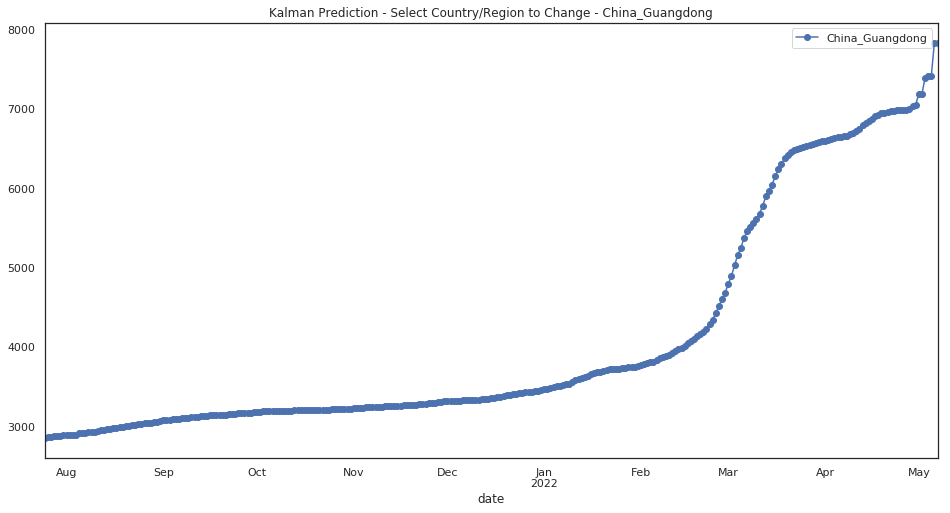

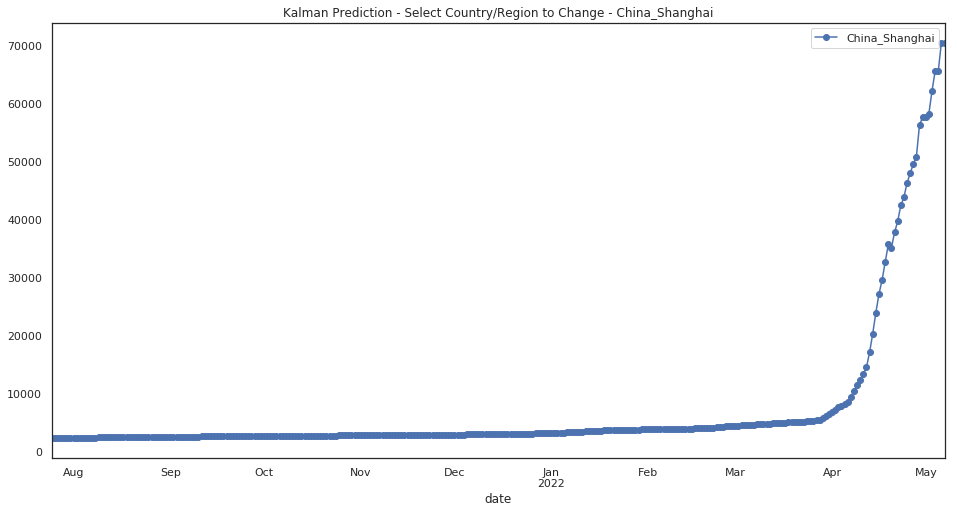

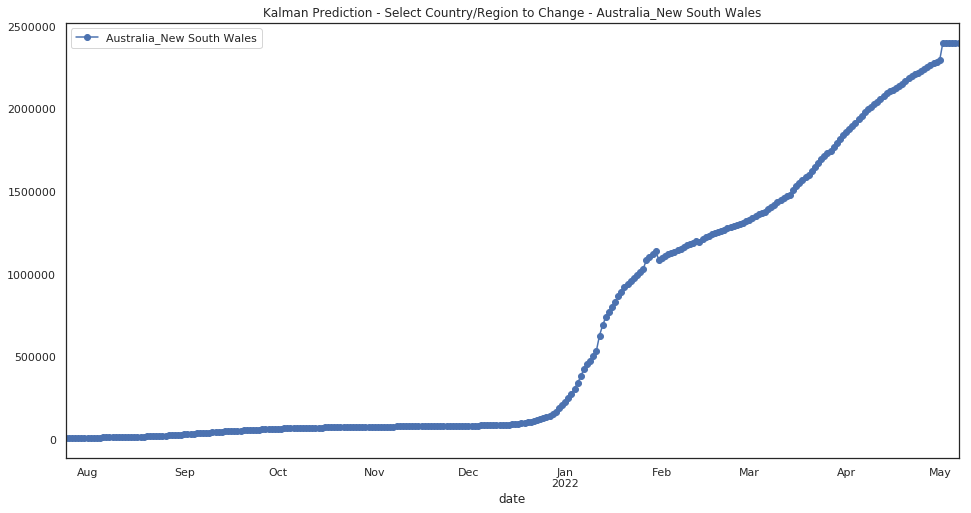

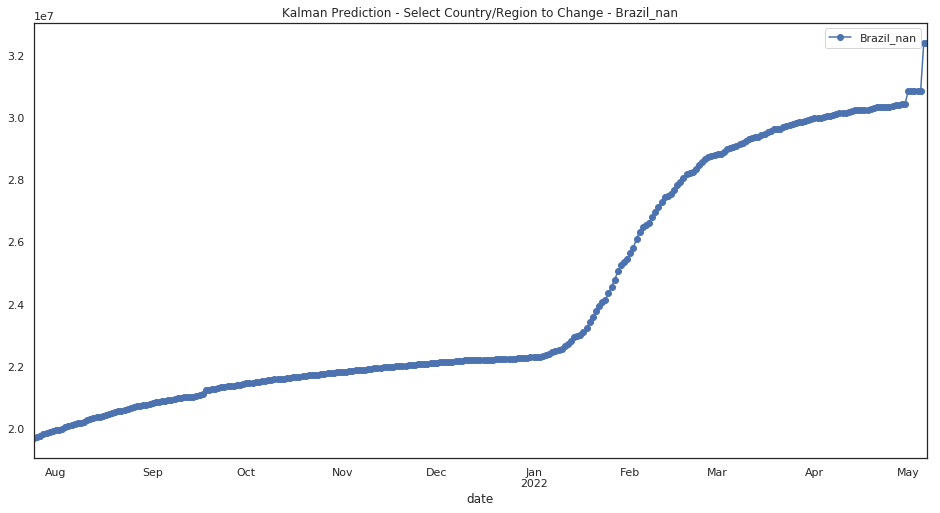

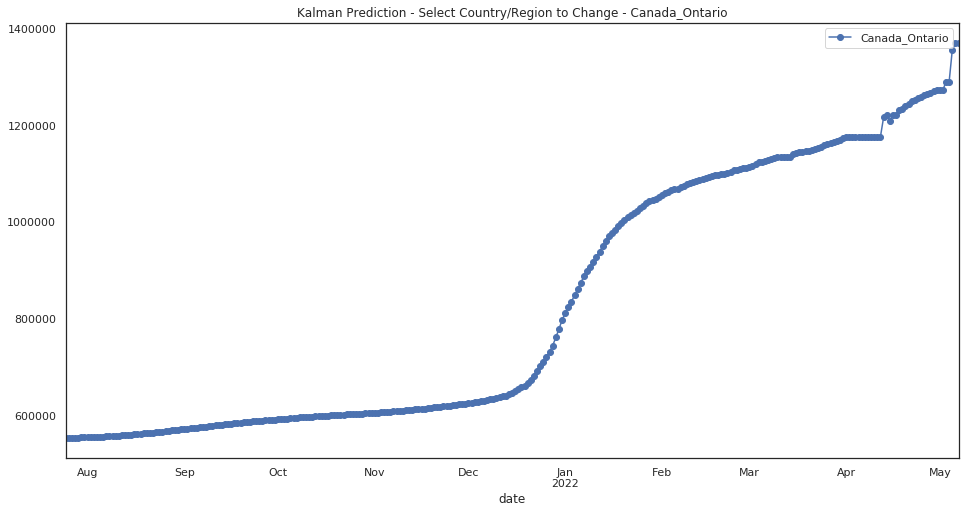

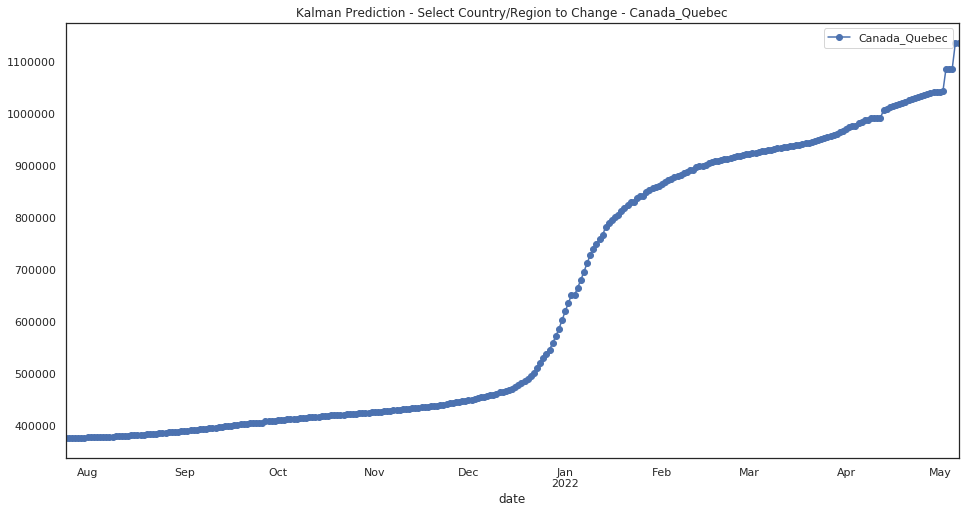

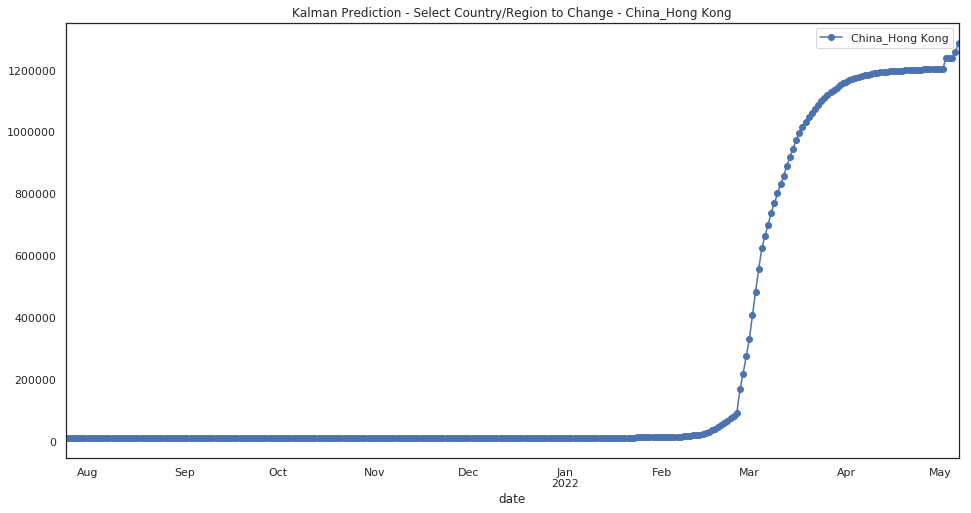

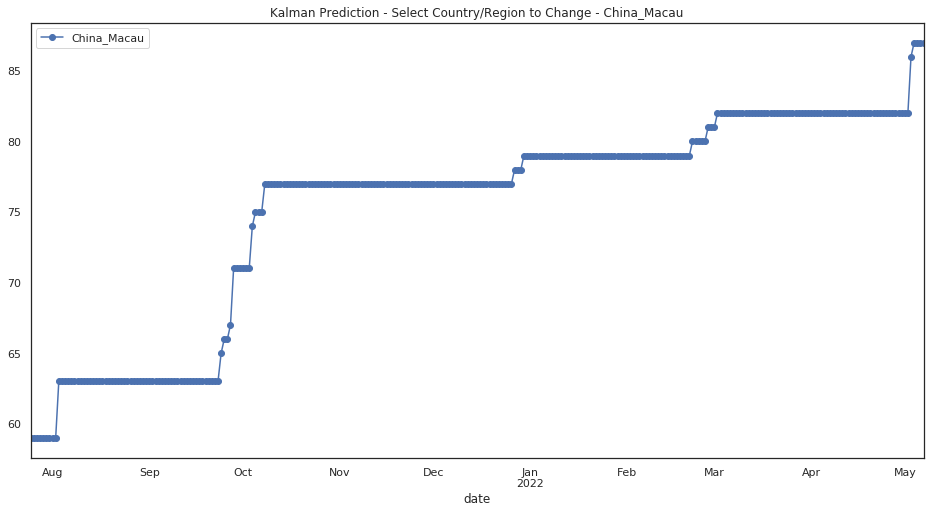

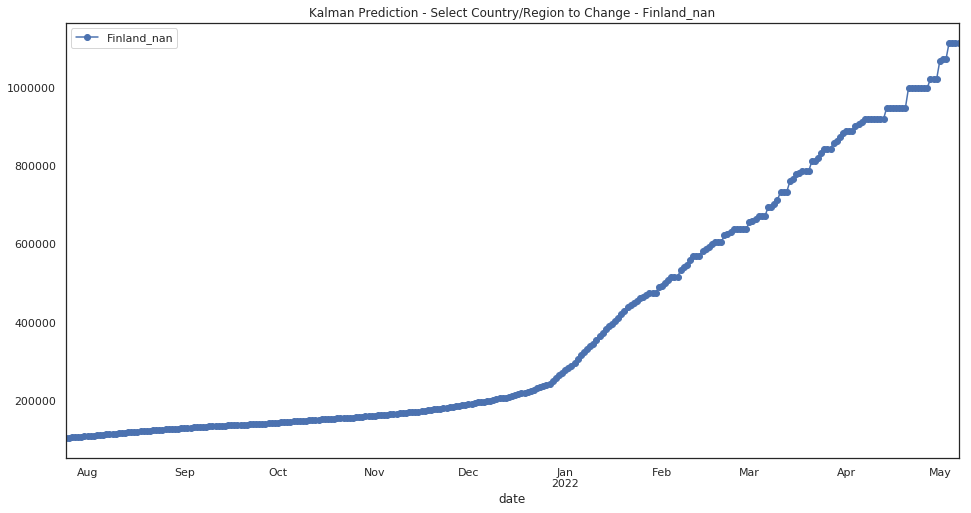

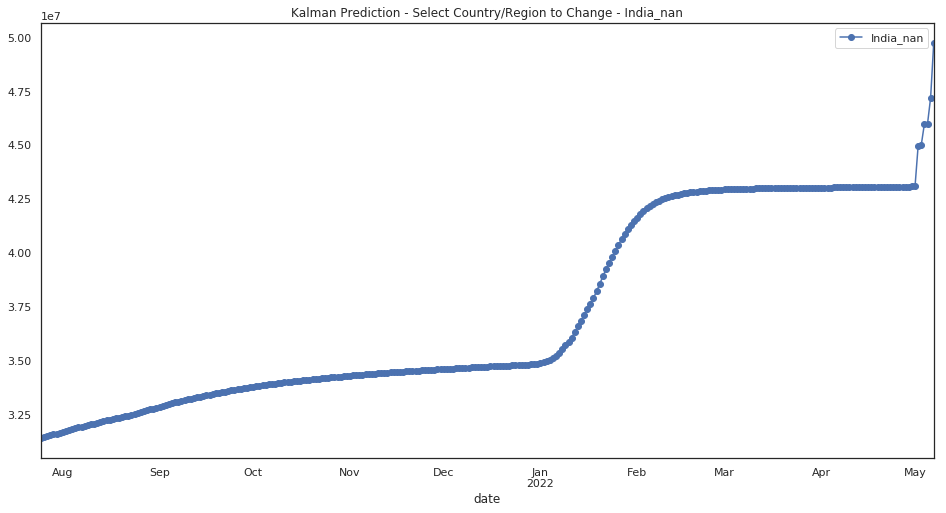

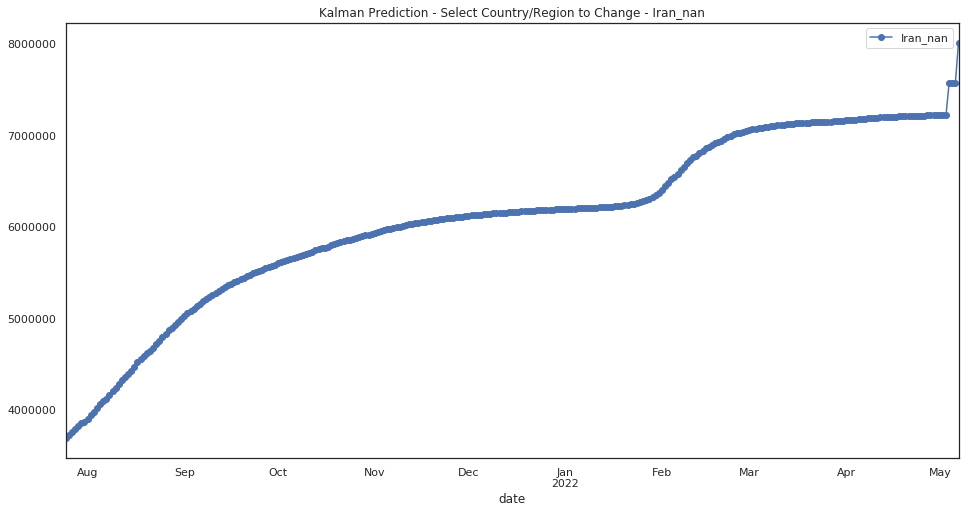

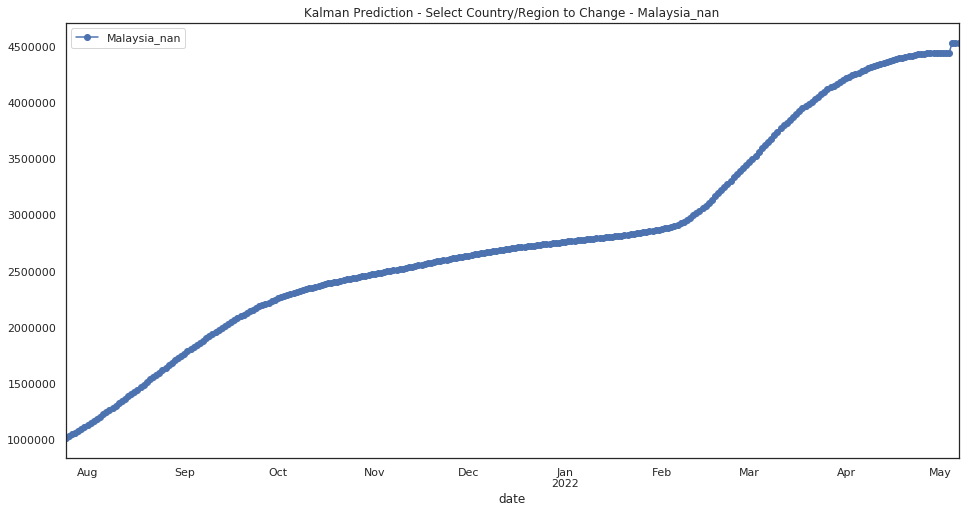

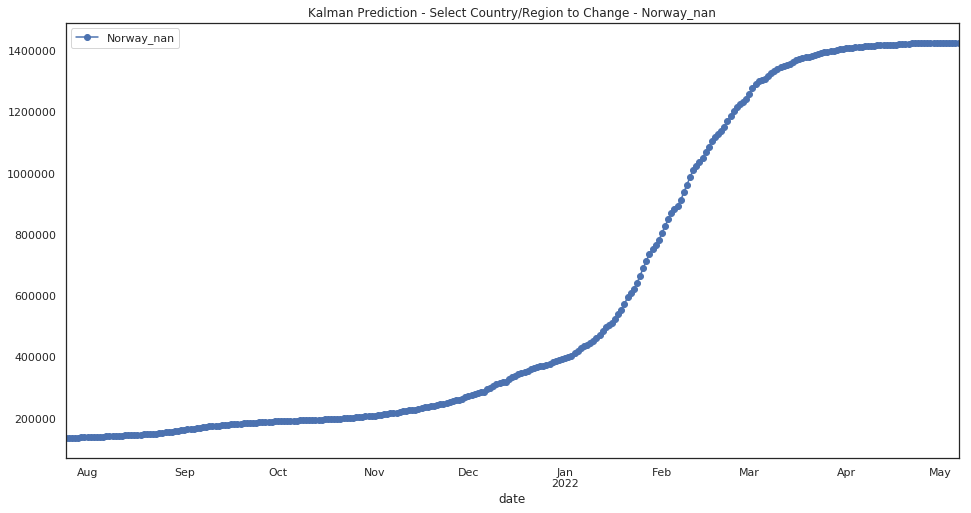

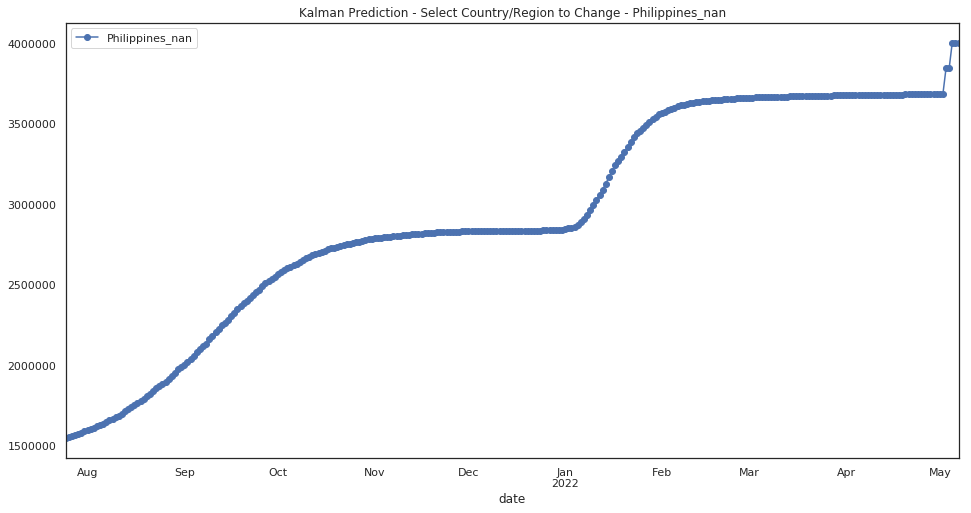

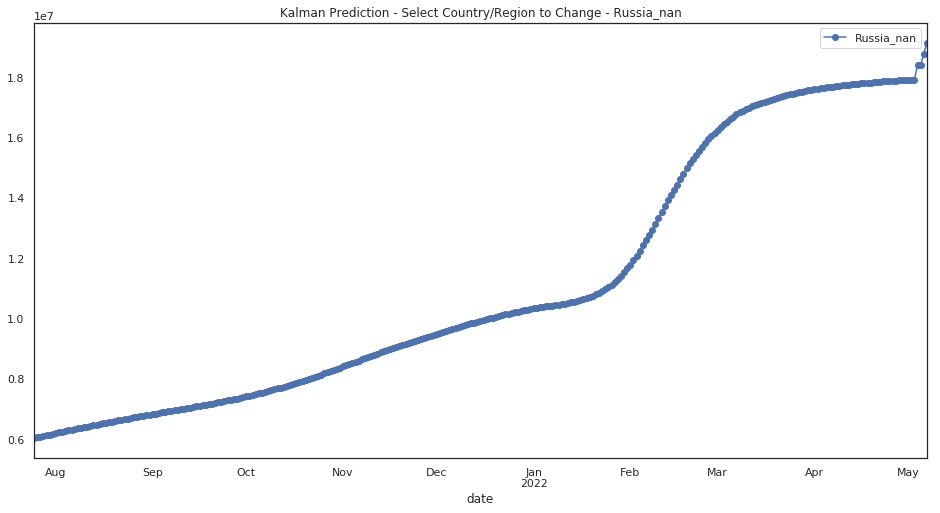

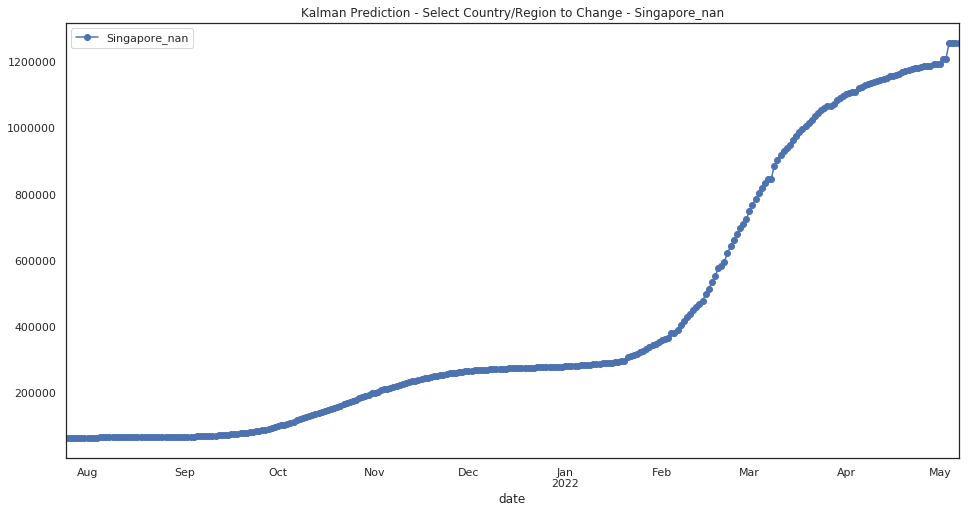

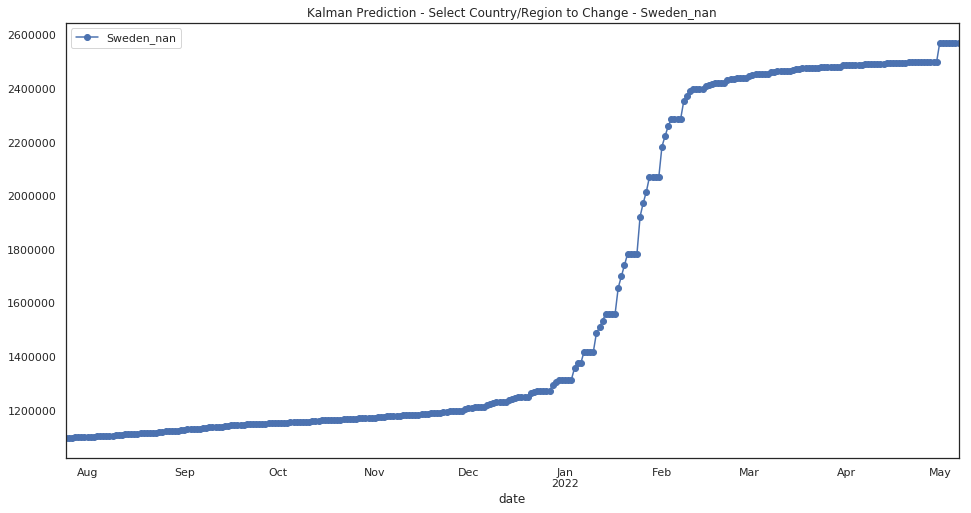

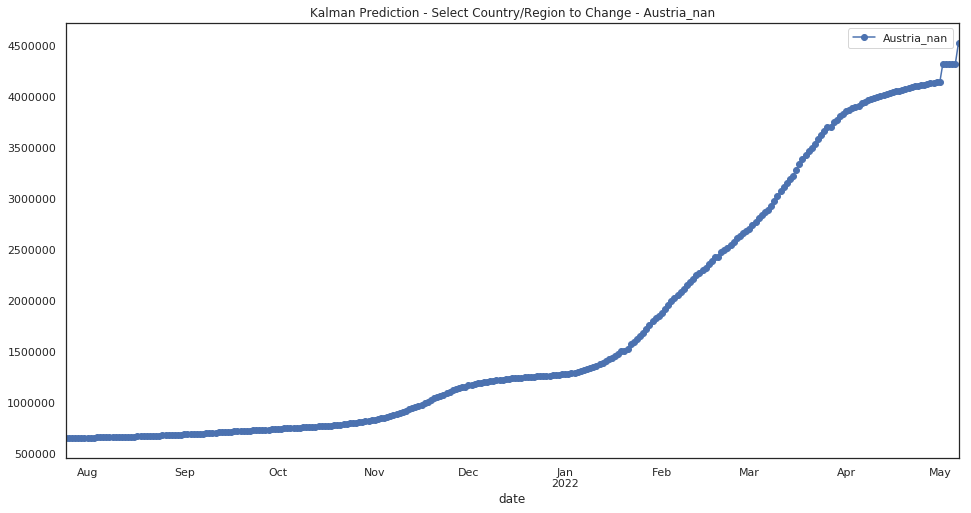

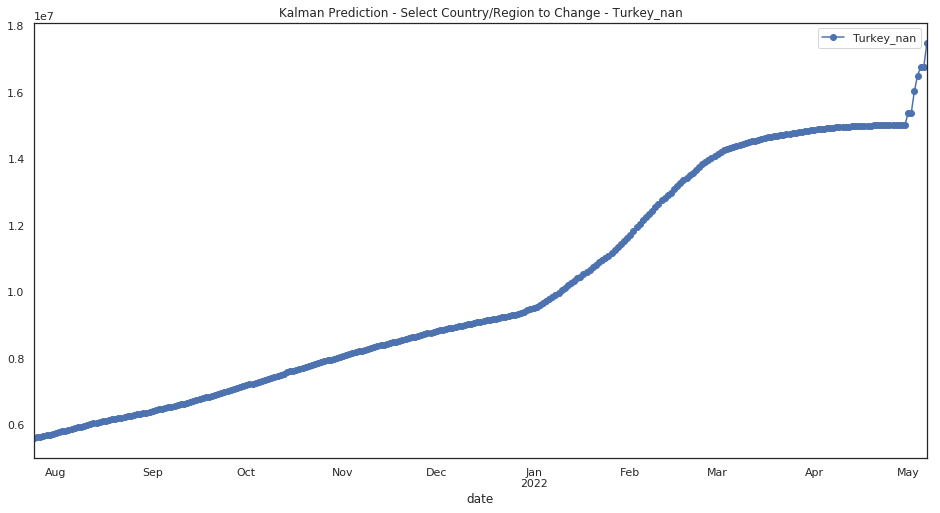

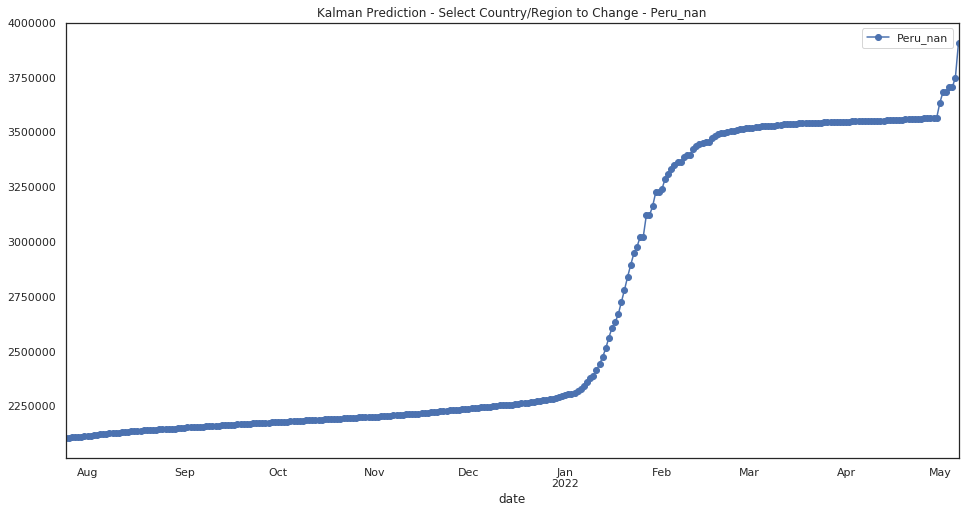

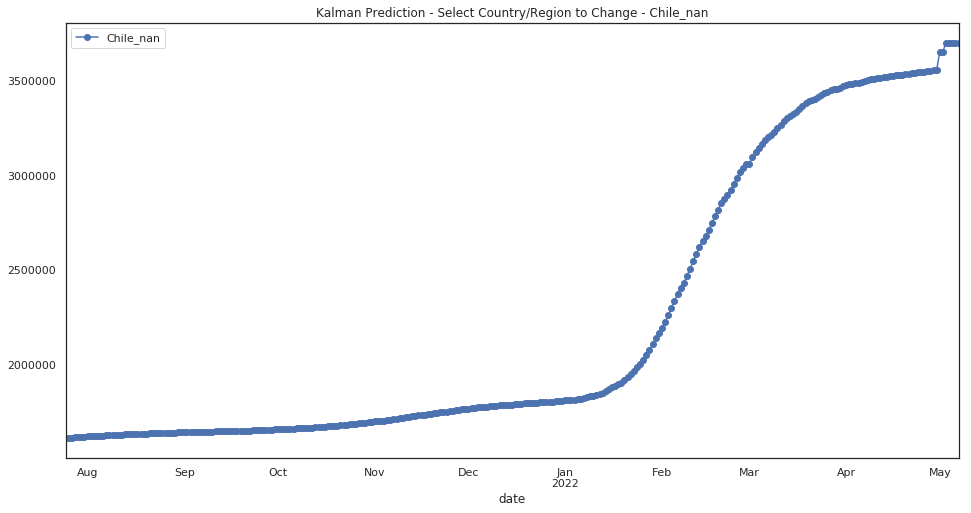

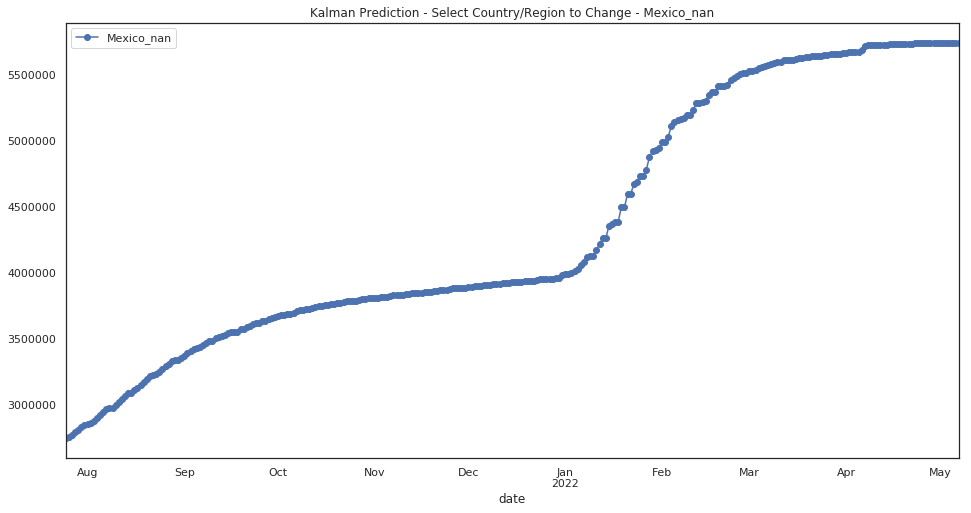

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2022-05-07 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN      85859810.0
India_nan                                           NaN      49754309.0
Brazil_nan                                          NaN      32418630.0
France_nan                                          NaN      28527424.0
Germany_nan                                         NaN      26368712.0
United Kingdom_nan                                  NaN      22434179.0
Russia_nan                                          NaN      19151971.0
Korea, South_nan                                    NaN      19086244.0
Italy_nan                                           NaN      18215940.0
Turkey_nan                                          NaN      17500135.0
Spain_nan                                           NaN      13083757.0
Vietnam_nan                                         NaN      12072184.0
Argentina_nan                                       NaN       9347286.0
Netherlands_nan                                     NaN       8454078.0
Japan_nan                                           NaN       8038227.0
Iran_nan                                            NaN       8016428.0
Poland_nan                                          NaN       6383025.0
Indonesia_nan                                       NaN       6164503.0
Colombia_nan                                        NaN       6092667.0
Mexico_nan                                          NaN       5739680.0
Ukraine_nan                                         NaN       5417178.0
Thailand_nan                                        NaN       4608033.0
Malaysia_nan                                        NaN       4537084.0
Austria_nan                                         NaN       4529189.0
Belgium_nan                                         NaN       4486233.0
Israel_nan                                          NaN       4189439.0
Portugal_nan                                        NaN       4108622.0
Czechia_nan                                         NaN       4060010.0
Philippines_nan                                     NaN       4006086.0
Peru_nan                                            NaN       3908509.0
...                                                 ...             ...
China_Guangxi                                       NaN          1584.0
China_Jiangxi                                       NaN          1507.0
China_Hunan                                         NaN          1460.0
China_Anhui                                         NaN          1123.0
China_Xinjiang                                      NaN          1072.0
Summer Olympics 2020_nan                            NaN           984.0
China_Chongqing                                     NaN           757.0
Diamond Princess_nan                                NaN           739.0
China_Gansu                                         NaN           723.0
Winter Olympics 2022_nan                            NaN           571.0
France_Wallis and Futuna                            NaN           485.0
China_Shanxi                                        NaN           433.0
China_Hainan                                        NaN           301.0
United Kingdom_Montserrat                           NaN           259.0
United Kingdom_Falkland Islands (Malvinas)          NaN           210.0
China_Guizhou                                       NaN           187.0
China_Ningxia                                       NaN           123.0
China_Qinghai                                       NaN           101.0
China_Macau                                         NaN            87.0
Holy See_nan                                        NaN            33.0
Marshall Islands_nan                                NaN            18.0
Canada_Repatriated Travellers                       NaN            15.0
Canada_Grand Princess                               NaN            15.0
Antarctica_nan                                      NaN            11.0
MS Zaandam_nan        

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-07-25         208942.0     199506.0     224632.0      97923.0   
2021-07-26         209297.0     199520.0     225923.0      97991.0   
2021-07-27         144285.0     132891.0     163660.0      14577.0   
2021-07-28         145008.0     132922.0     165204.0      14586.0   
2021-07-29         145552.0     132952.0     168005.0      14586.0   
2021-07-30         145996.0     132999.0     169520.0      14655.0   
2021-07-31         146523.0     133036.0     170772.0      14678.0   
2021-08-01         147154.0     133081.0     171910.0      14678.0   
2021-08-02         149420.0     134482.0     175022.0      15135.0   
2021-08-03         149984.0     134542.0     176353.0      14783.0   
2021-08-04         150381.0     134631.0     177837.0      15095.0   
2021-08-05         150814.0     134754.0     179205.0      15053.0   
2021-08-06         151258.0     134898.0     180419.0      15160.0   
2021-08-07         151690.0     135034.0     181577.0      15082.0   
2021-08-08         151951.0     135208.0     182602.0      15221.0   
2021-08-09         152258.0     135284.0     183588.0      15218.0   
2021-08-10         152508.0     135486.0     184580.0      15235.0   
2021-08-11         152791.0     135745.0     185456.0      15062.0   
2021-08-12         153070.0     136010.0     186323.0      15186.0   
2021-08-13         153293.0     136376.0     187202.0      15211.0   
2021-08-14         153481.0     136768.0     187987.0      15211.0   
2021-08-15         153594.0     137155.0     188619.0      15293.0   
2021-08-16         153700.0     137378.0     189313.0      15314.0   
2021-08-17         153810.0     137794.0     190032.0      15164.0   
2021-08-18         153931.0     138238.0     190762.0      15307.0   
2021-08-19         153999.0     138745.0     191473.0      15262.0   
2021-08-20         154047.0     139276.0     192073.0      15320.0   
2021-08-21         154100.0     139910.0     192596.0      15309.0   
2021-08-22         154123.0     140448.0     193022.0      15343.0   
2021-08-23         154190.0     140866.0     193505.0      15354.0   
...                     ...          ...          ...          ...   
2022-04-09         179593.0     275155.0     267321.0      40328.0   
2022-04-10         179593.0     275194.0     267325.0      40328.0   
2022-04-11         179738.0     275191.0     267328.0      40328.0   
2022-04-12         179875.0     275231.0     267330.0      40328.0   
2022-04-13         179919.0     275296.0     267332.0      40328.0   
2022-04-14         179968.0     275350.0     267333.0      40709.0   
2022-04-15         179989.0     275407.0     267338.0      40709.0   
2022-04-16         179997.0     275440.0     267340.0      40709.0   
2022-04-17         180023.0     275476.0     267340.0      40709.0   
2022-04-18         180060.0     275497.0     267341.0      40709.0   
2022-04-19         180122.0     275504.0     267347.0      40709.0   
2022-04-20         180188.0     275568.0     267348.0      40709.0   
2022-04-21         180229.0     275592.0     267354.0      41013.0   
2022-04-22         180256.0     275689.0     267363.0      41013.0   
2022-04-23         180267.0     275786.0     267363.0      41013.0   
2022-04-24         180300.0     275803.0     267367.0      41013.0   
2022-04-25         180356.0     275805.0     267372.0      41013.0   
2022-04-26         180386.0     275822.0     267373.0      41013.0   
2022-04-27         180423.0     275892.0     267373.0      41013.0   
2022-04-28         180467.0     275974.0     267376.0      41013.0   
2022-04-29         180492.0     276028.0     267380.0      41349.0   
2022-04-30         180499.0     276080.0     267381.0      41349.0   
2022-05-01         180497.0     276087.0     272577.0      41349.0   
2022-05-02         181344.0     276074.0     274750.0      42145.0   
2022-05-03

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'France_nan',
 'Germany_nan',
 'United Kingdom_nan',
 'Russia_nan',
 'Korea, South_nan',
 'Italy_nan',
 'Turkey_nan',
 'Spain_nan',
 'Vietnam_nan',
 'Argentina_nan',
 'Netherlands_nan',
 'Japan_nan',
 'Iran_nan',
 'Poland_nan',
 'Indonesia_nan',
 'Colombia_nan',
 'Mexico_nan',
 'Ukraine_nan',
 'Thailand_nan',
 'Malaysia_nan',
 'Austria_nan',
 'Belgium_nan',
 'Israel_nan',
 'Portugal_nan',
 'Czechia_nan',
 'Philippines_nan',
 'Peru_nan',
 'Switzerland_nan',
 'South Africa_nan',
 'Chile_nan',
 'Greece_nan',
 'Denmark_nan',
 'Romania_nan',
 'Sweden_nan',
 'Slovakia_nan',
 'Iraq_nan',
 'Australia_New South Wales',
 'Serbia_nan',
 'Hungary_nan',
 'Bangladesh_nan',
 'Jordan_nan',
 'Georgia_nan',
 'Australia_Victoria',
 'Ireland_nan',
 'Pakistan_nan',
 'Kazakhstan_nan',
 'Norway_nan',
 'Canada_Ontario',
 'Bulgaria_nan',
 'China_Hong Kong',
 'Singapore_nan',
 'Croatia_nan',
 'Cuba_nan',
 'Australia_Queensland',
 'Morocco_nan',
 'Tunisia_nan',

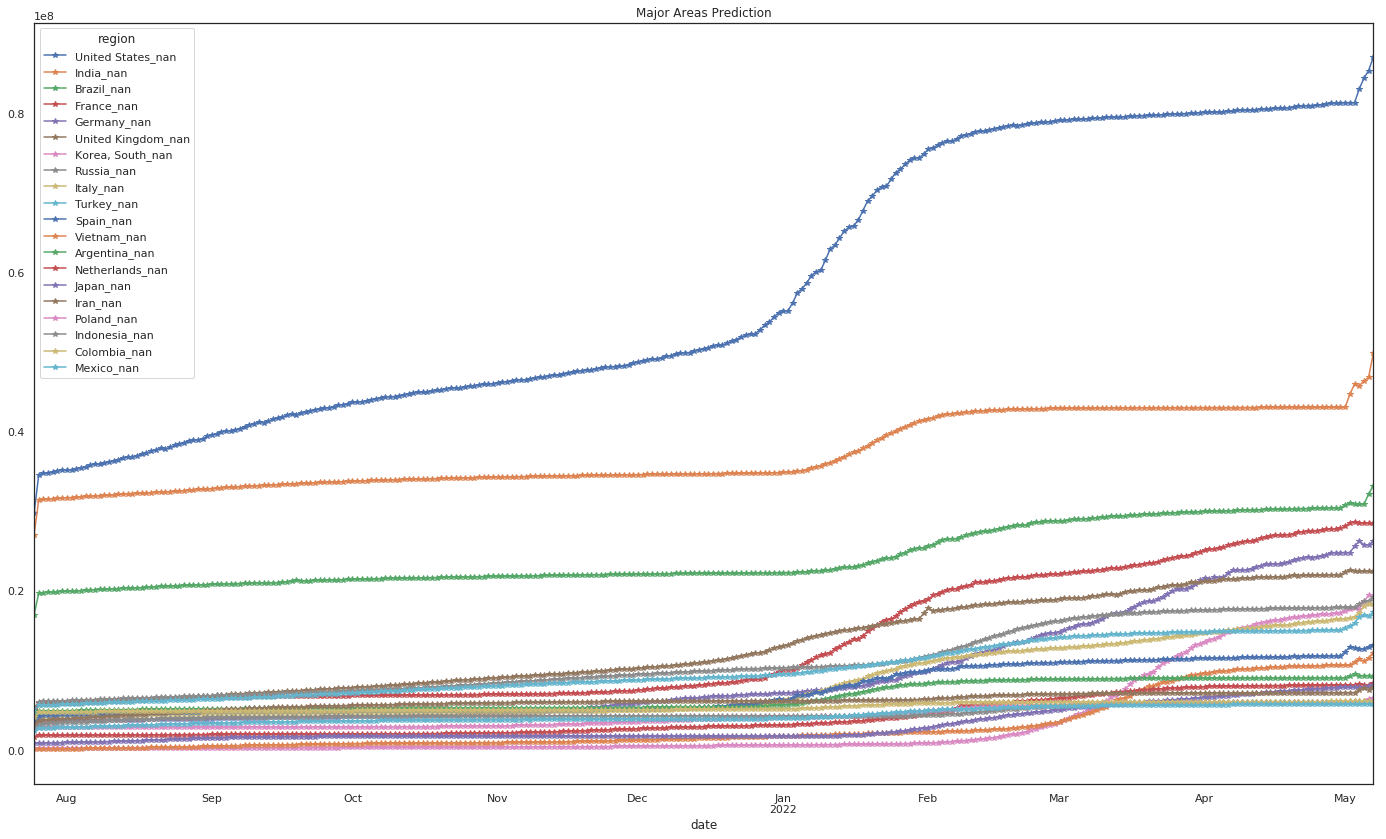

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

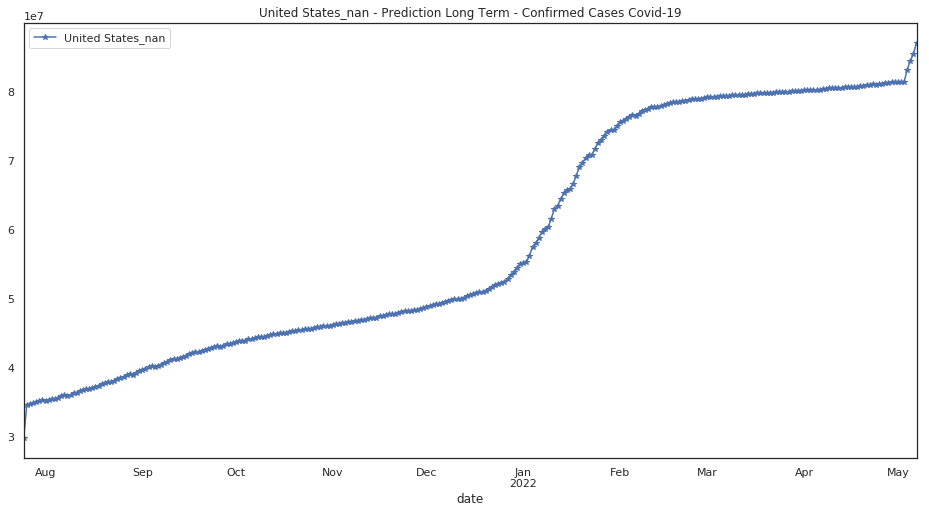

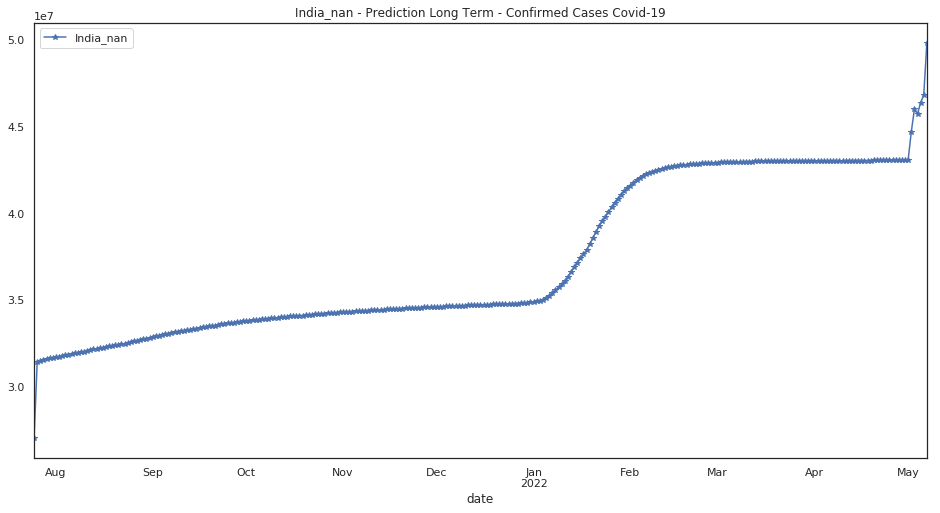

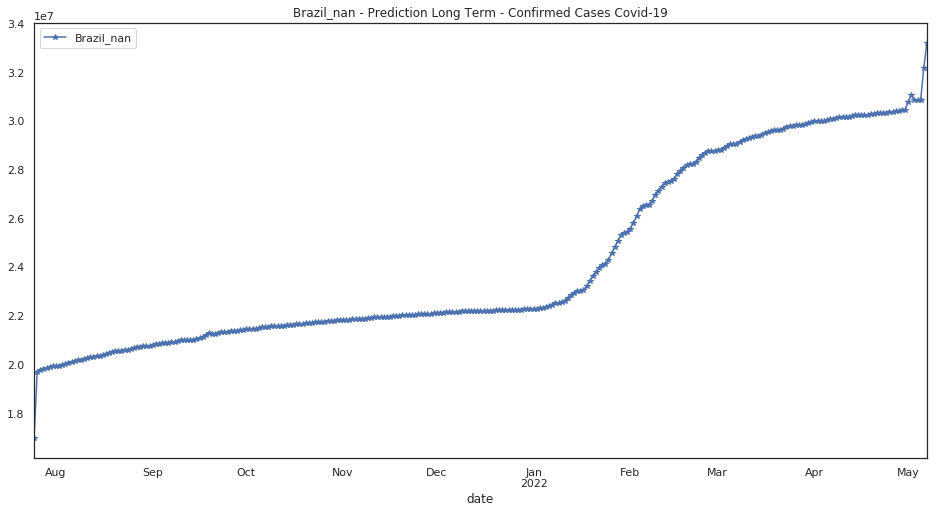

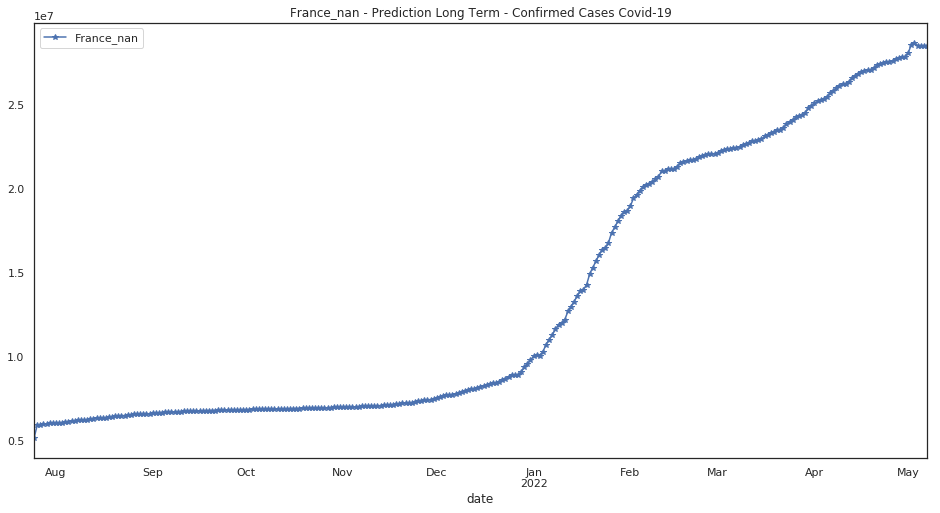

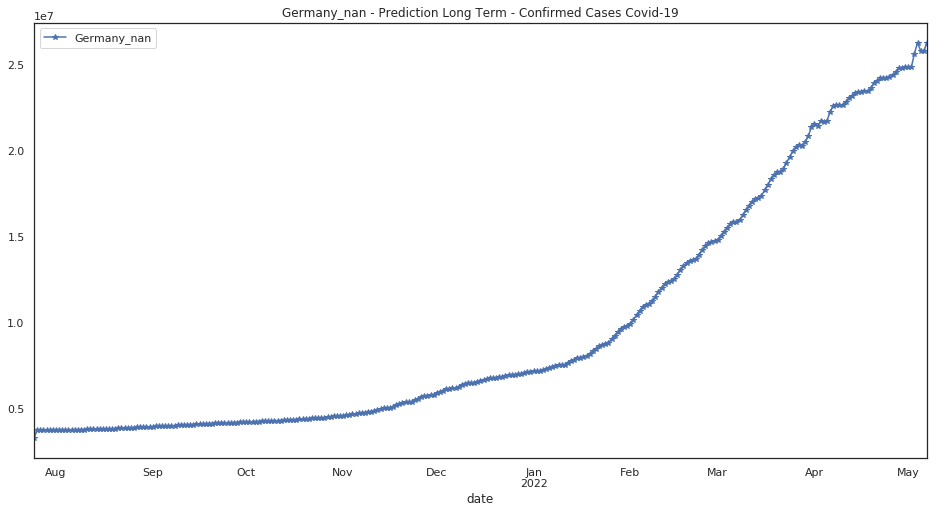

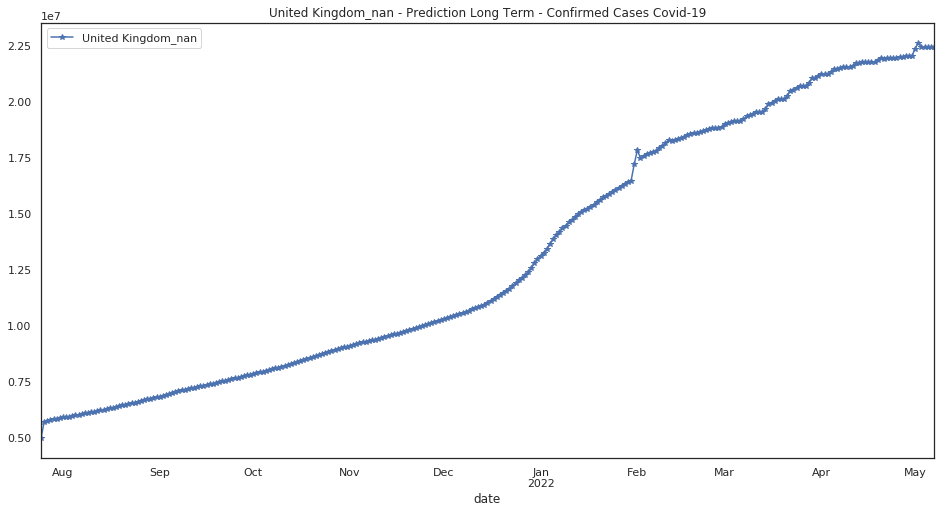

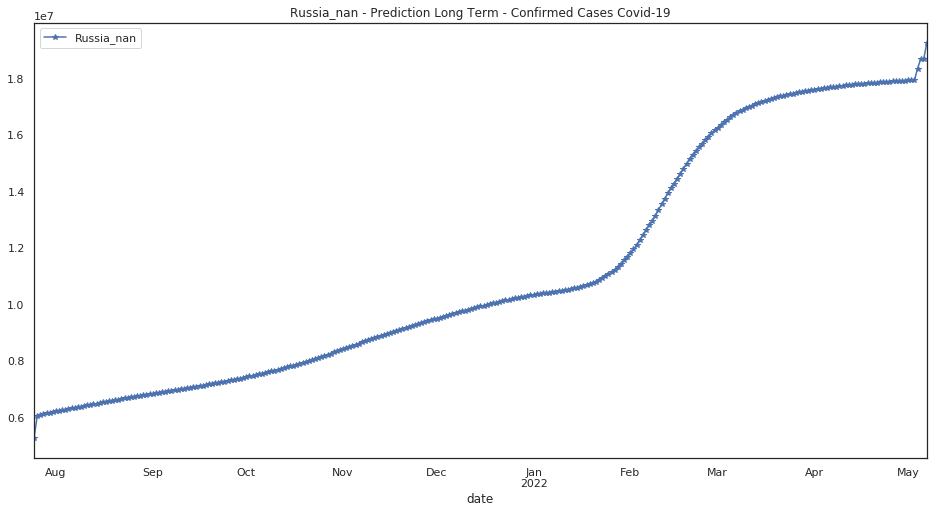

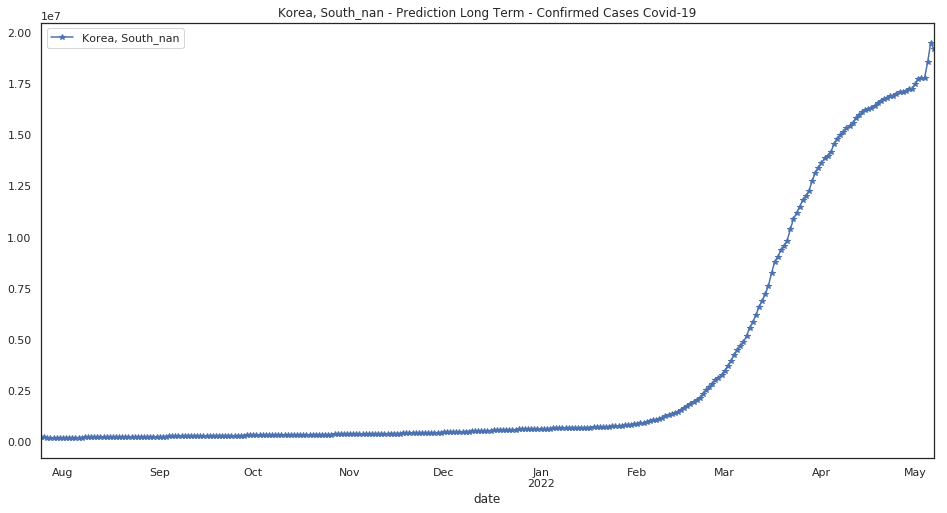

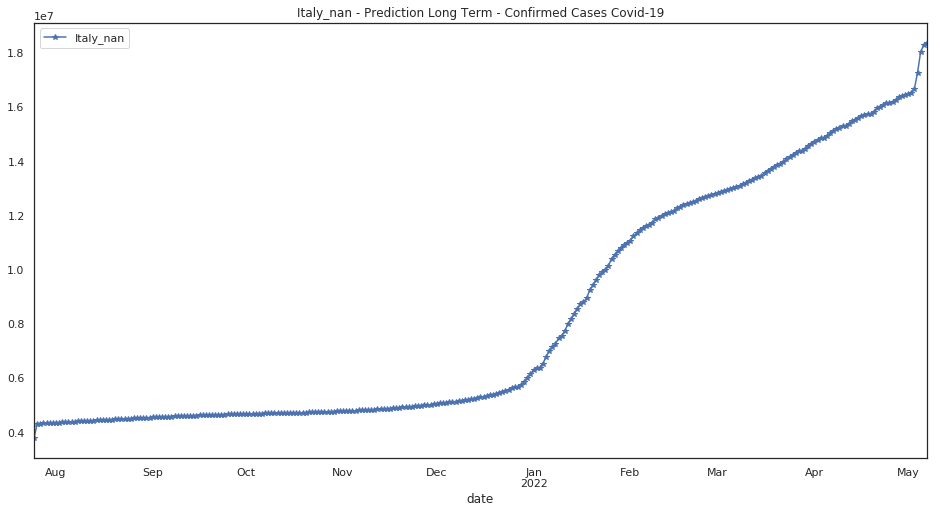

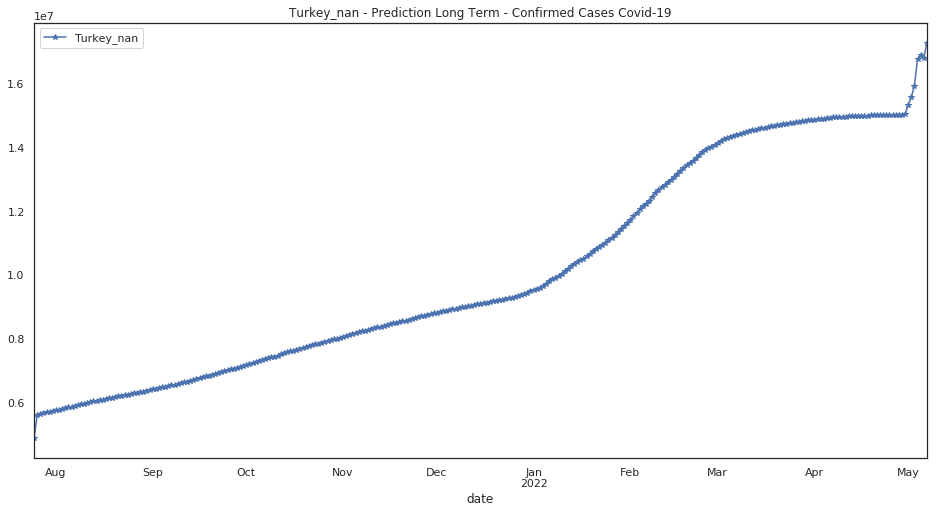

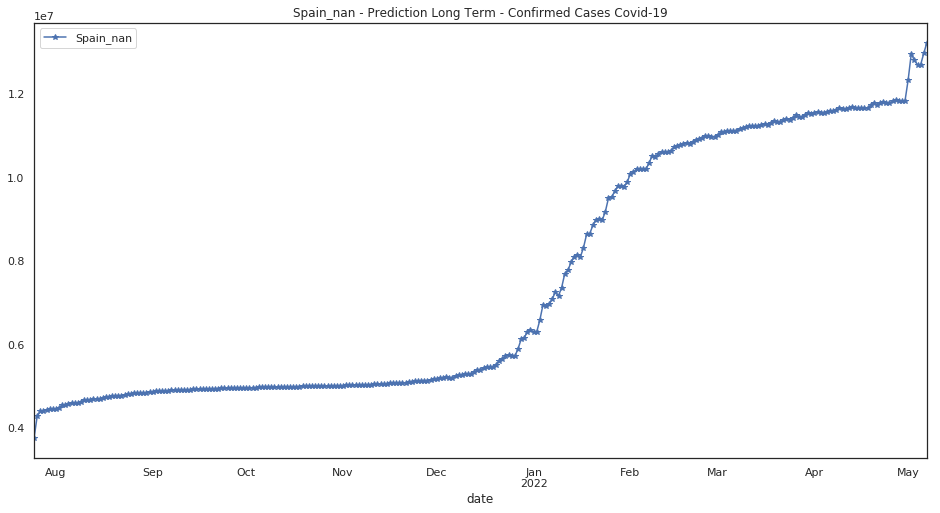

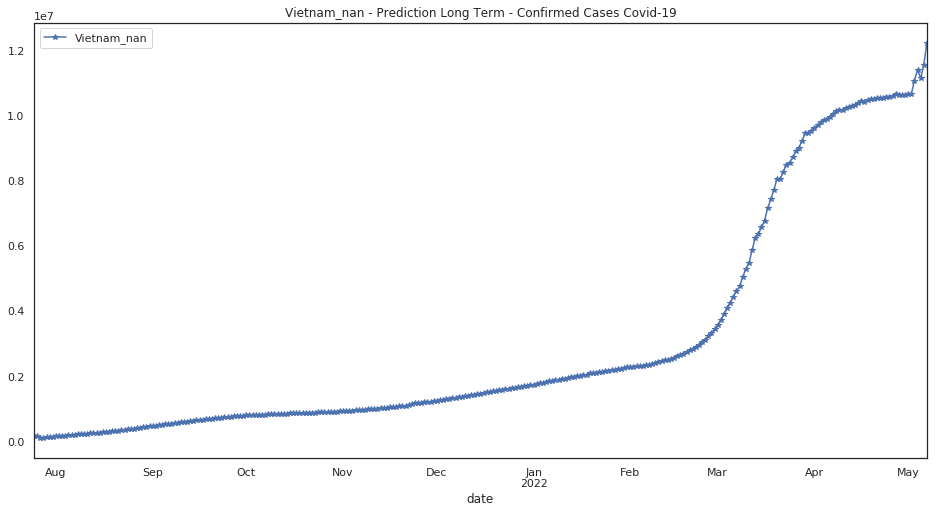

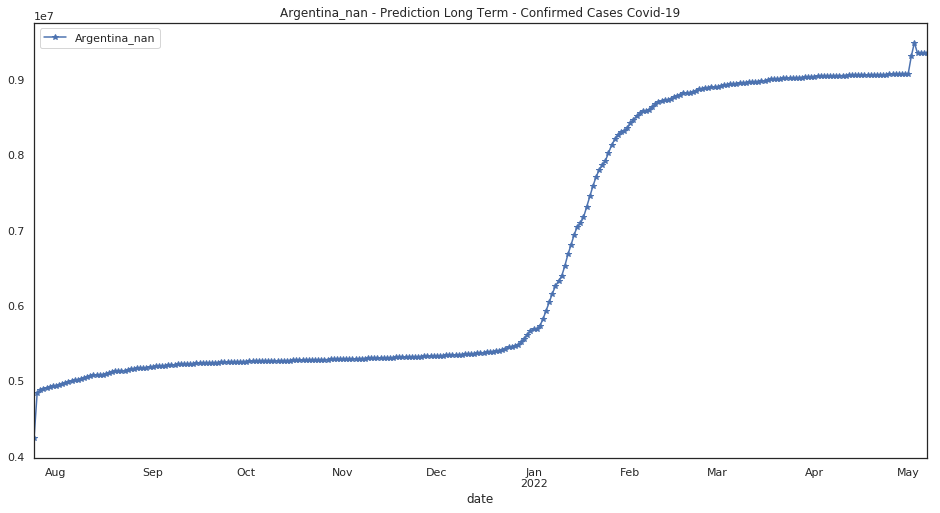

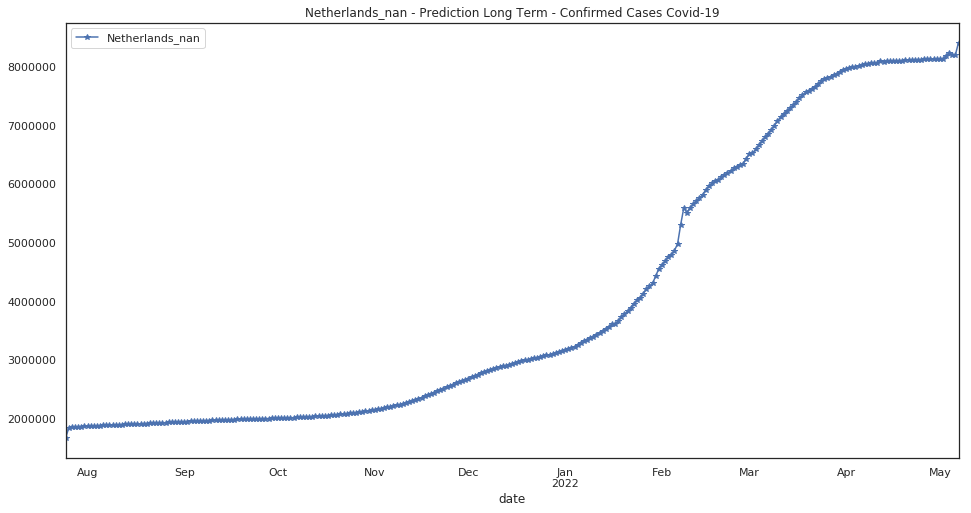

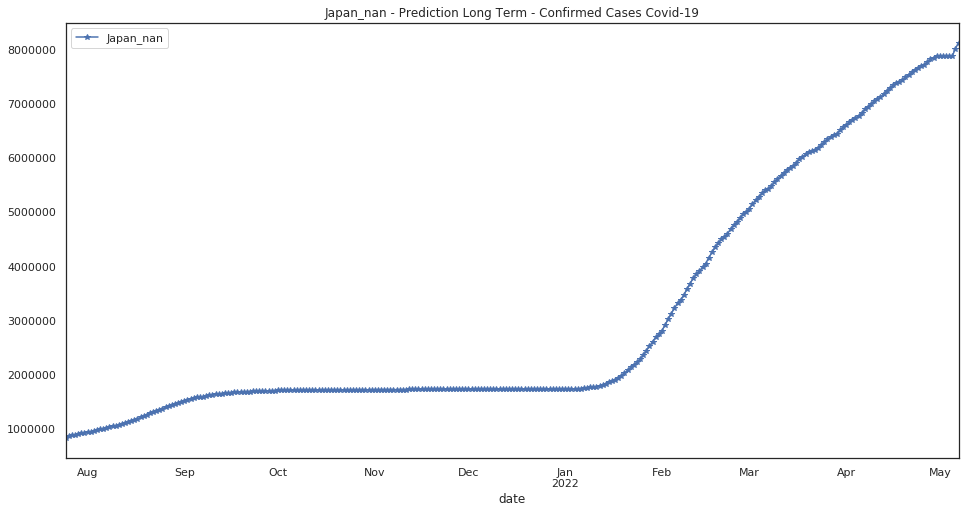

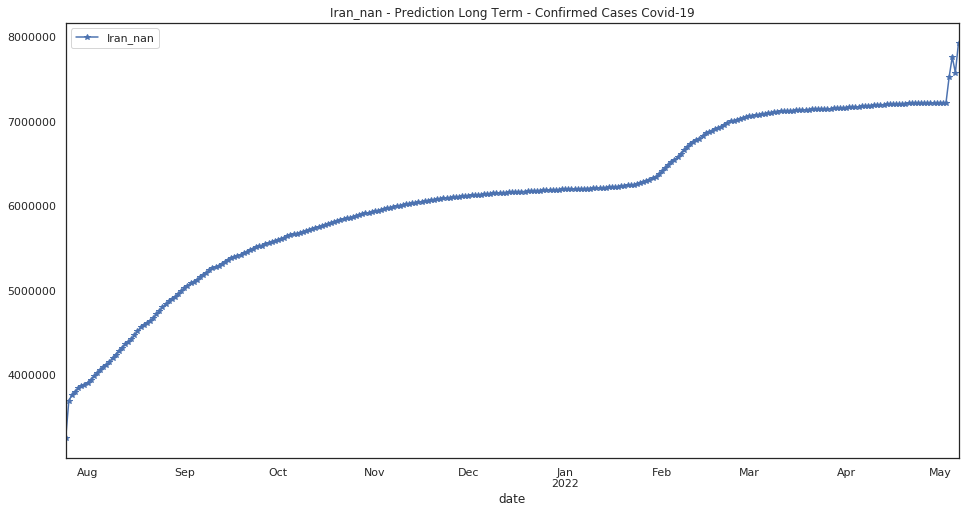

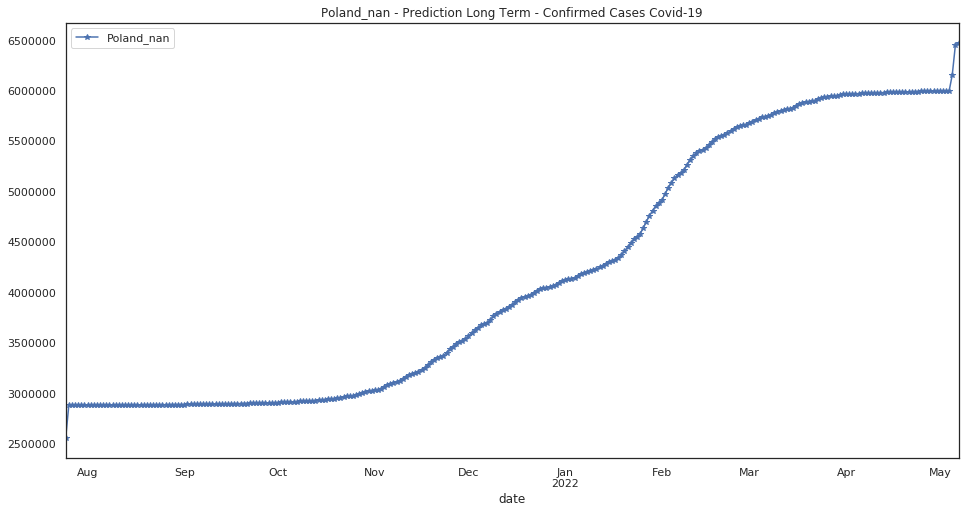

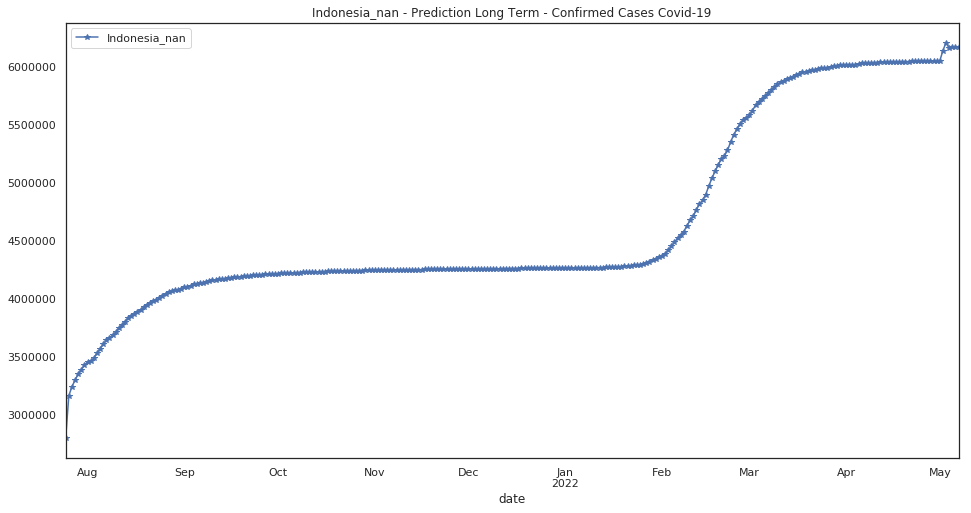

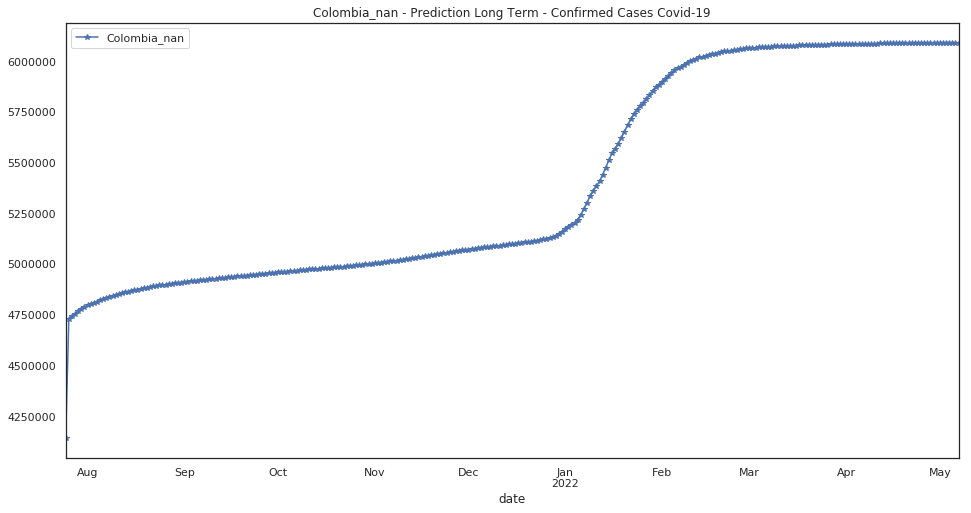

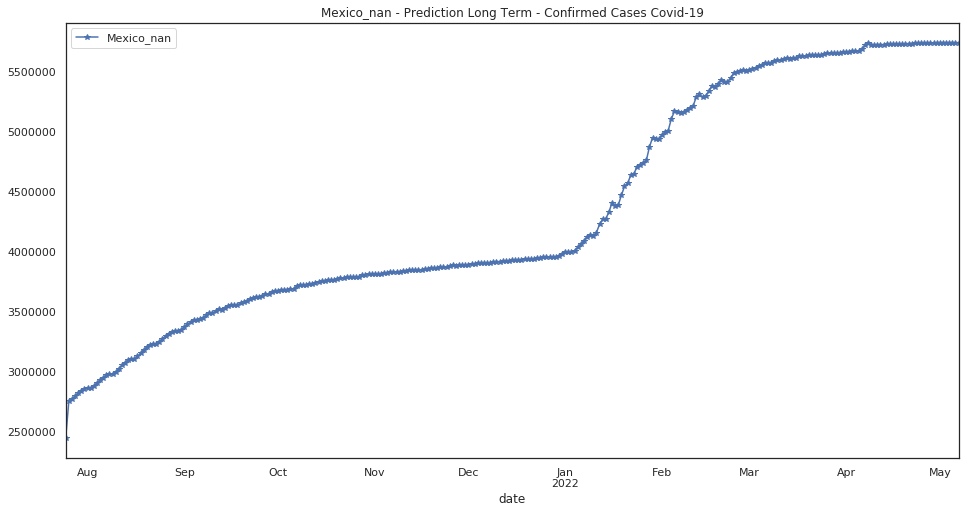

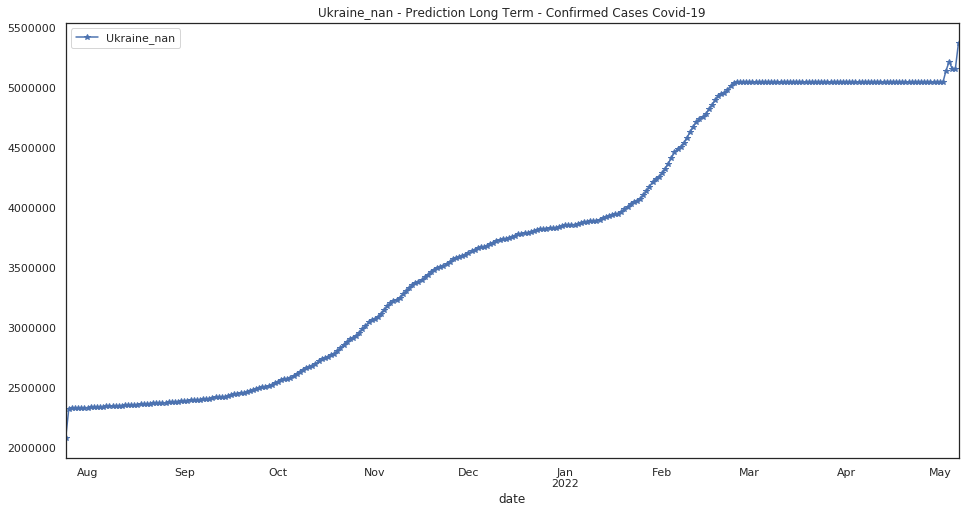

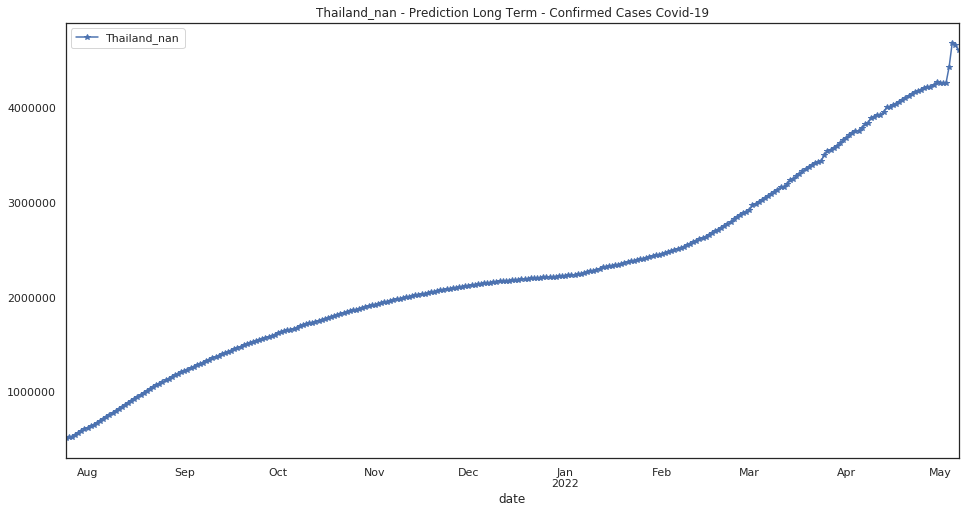

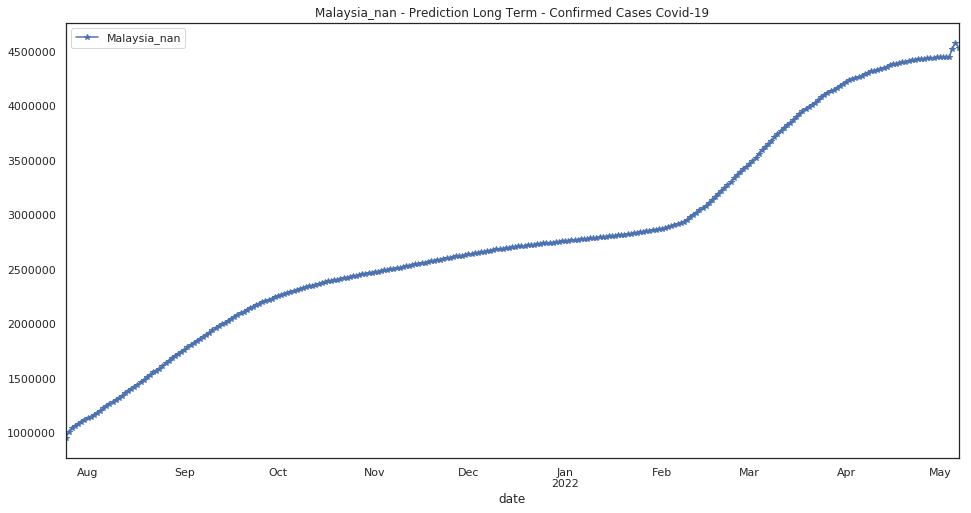

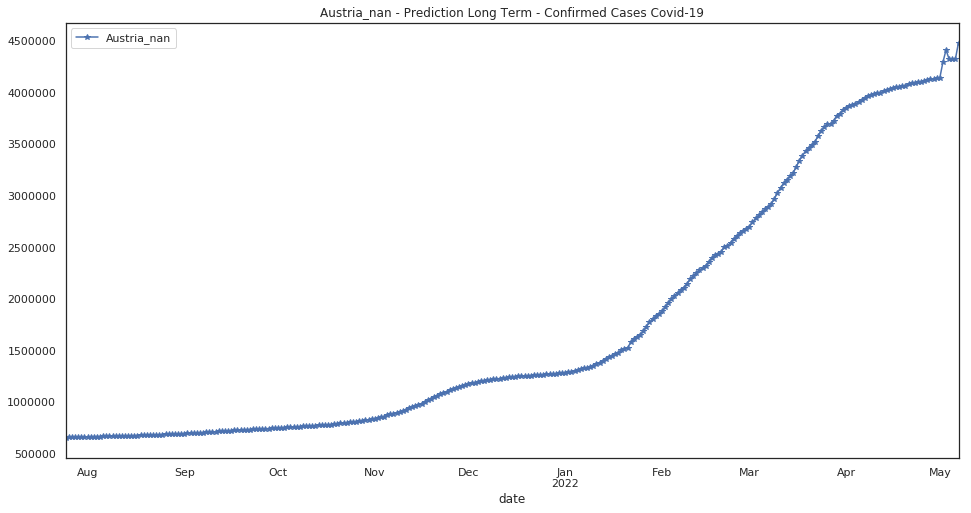

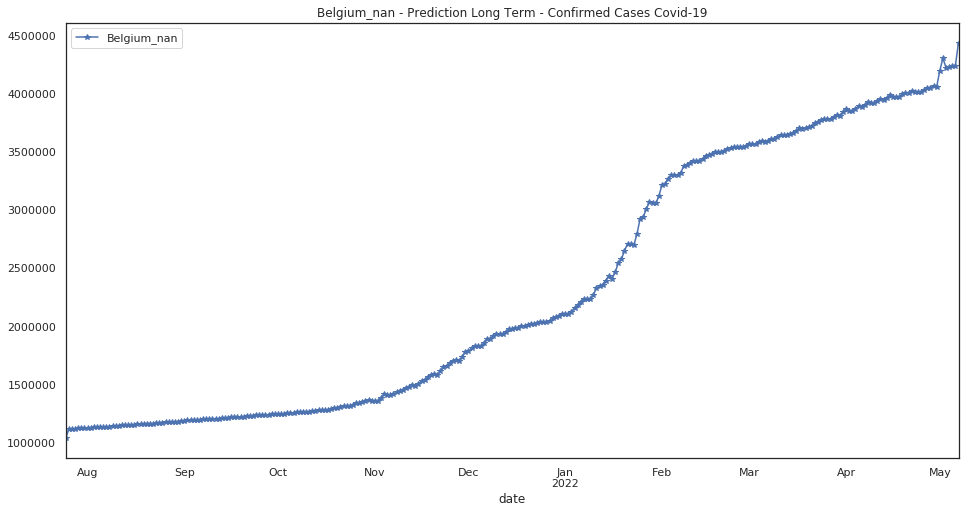

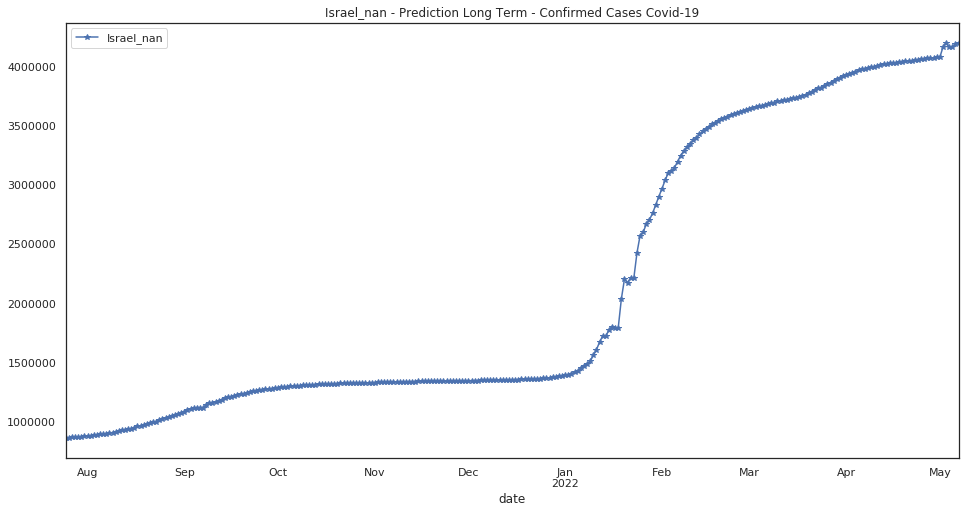

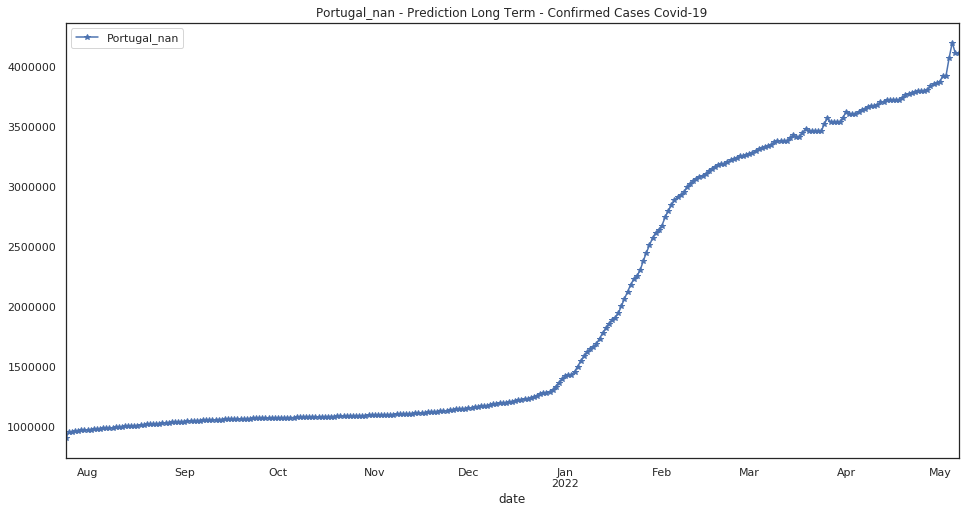

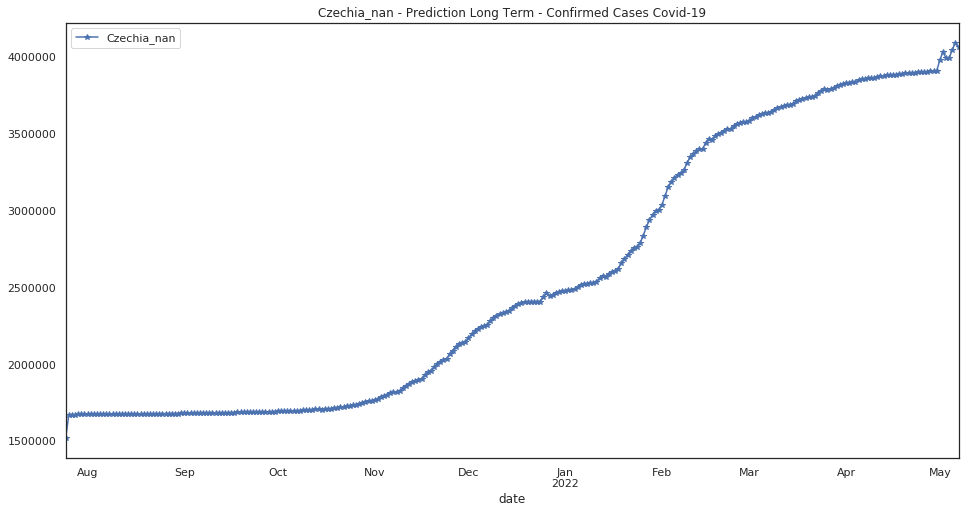

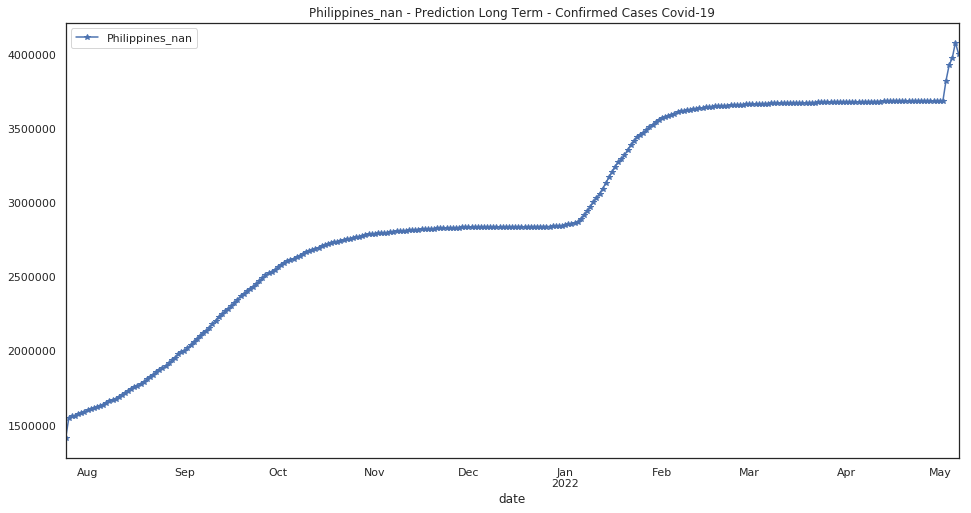

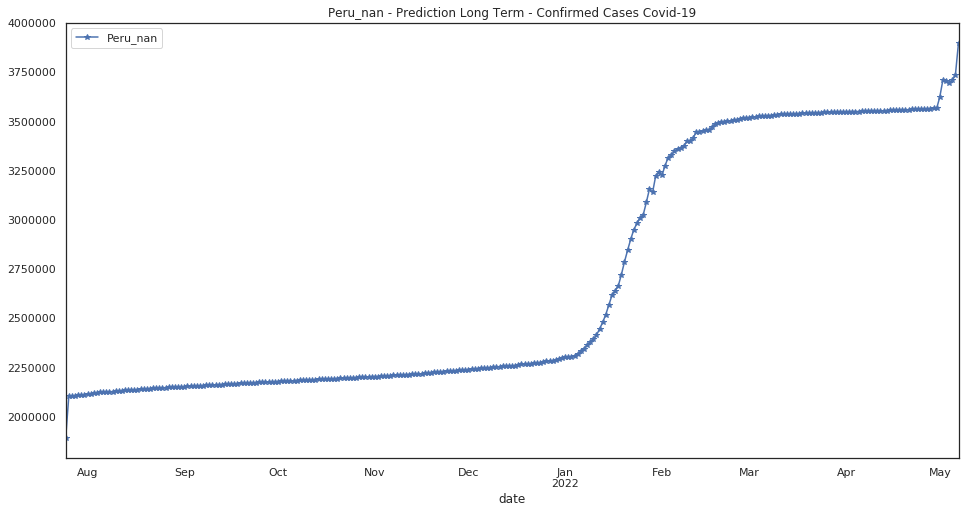

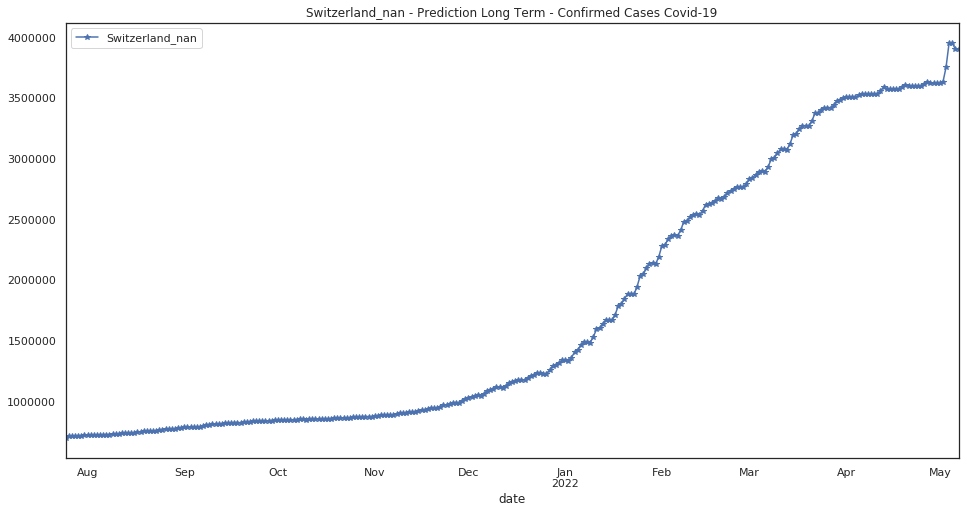

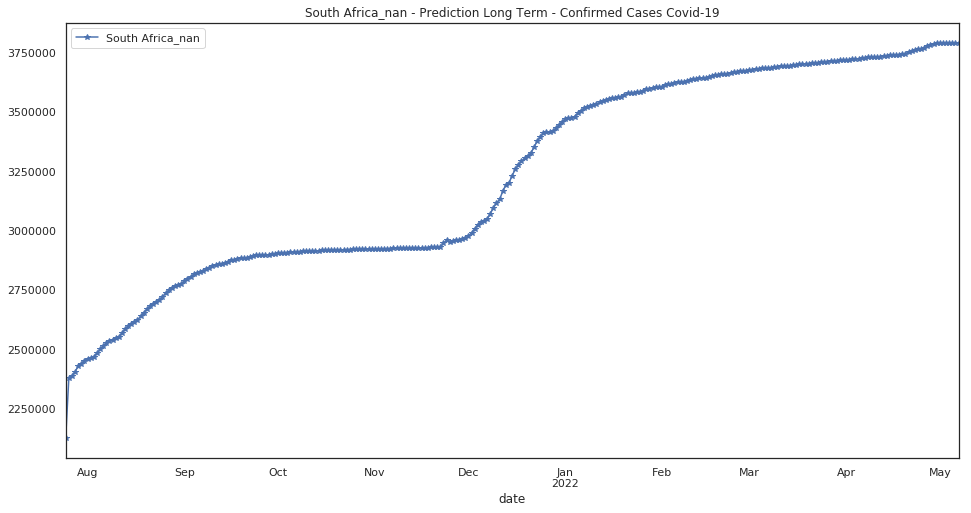

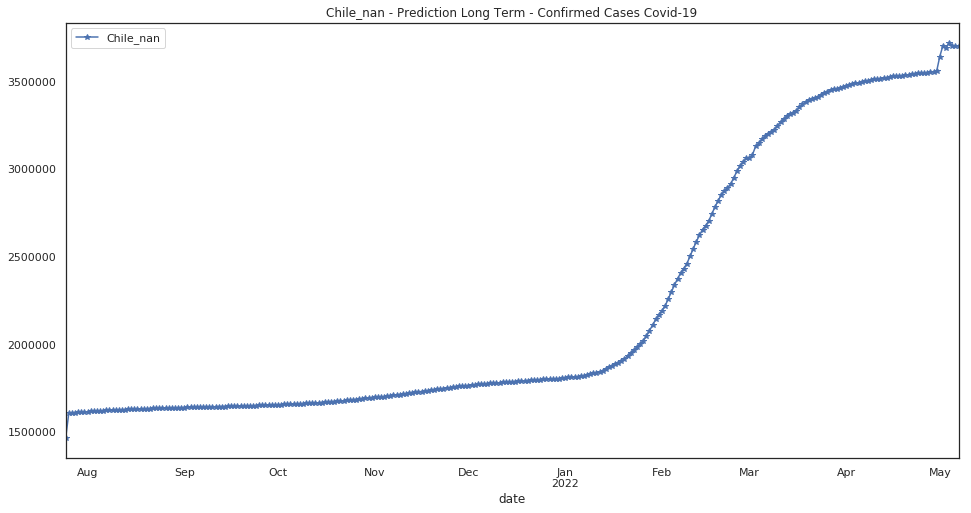

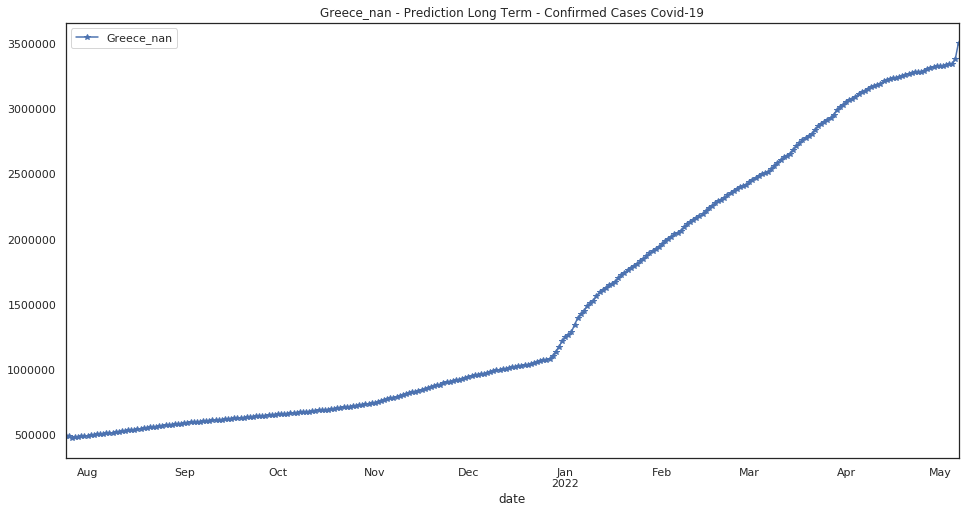

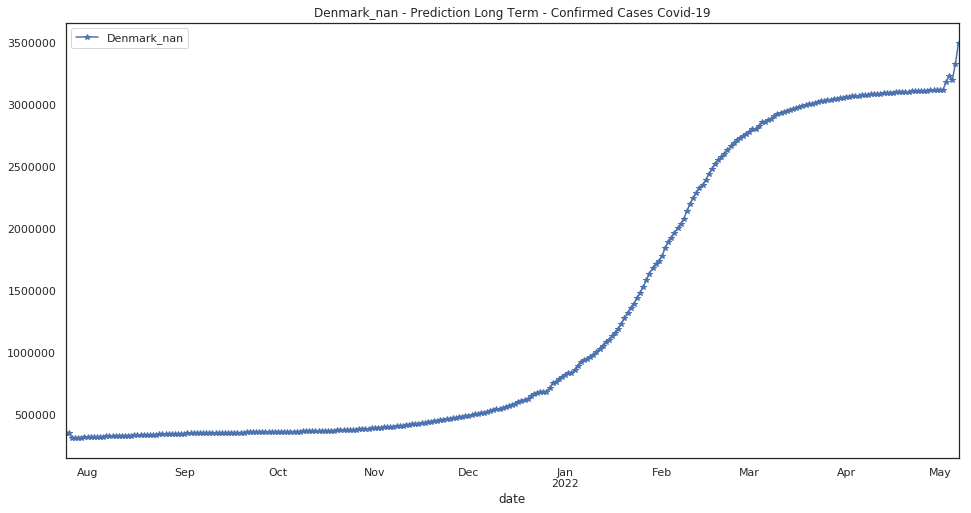

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

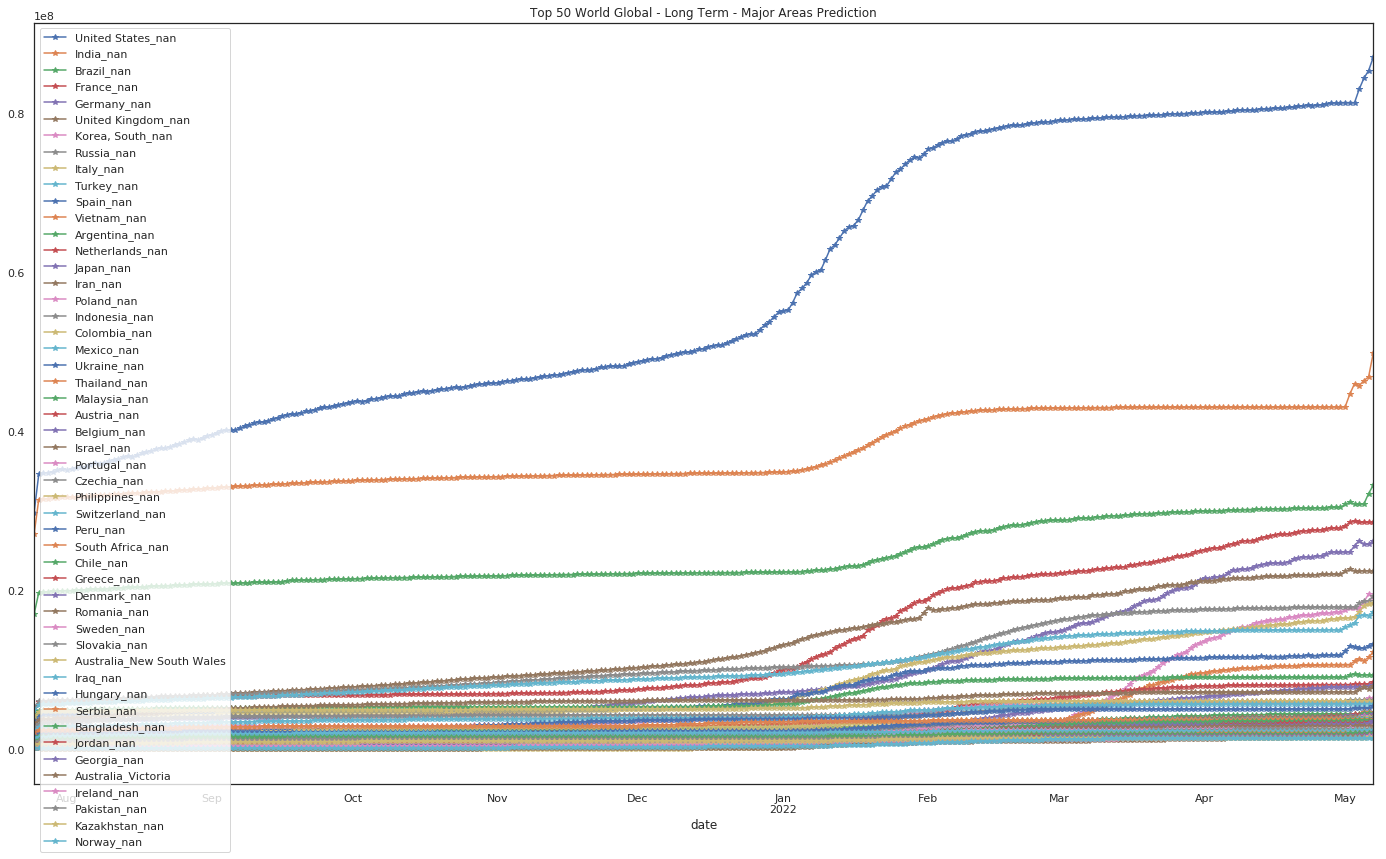

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

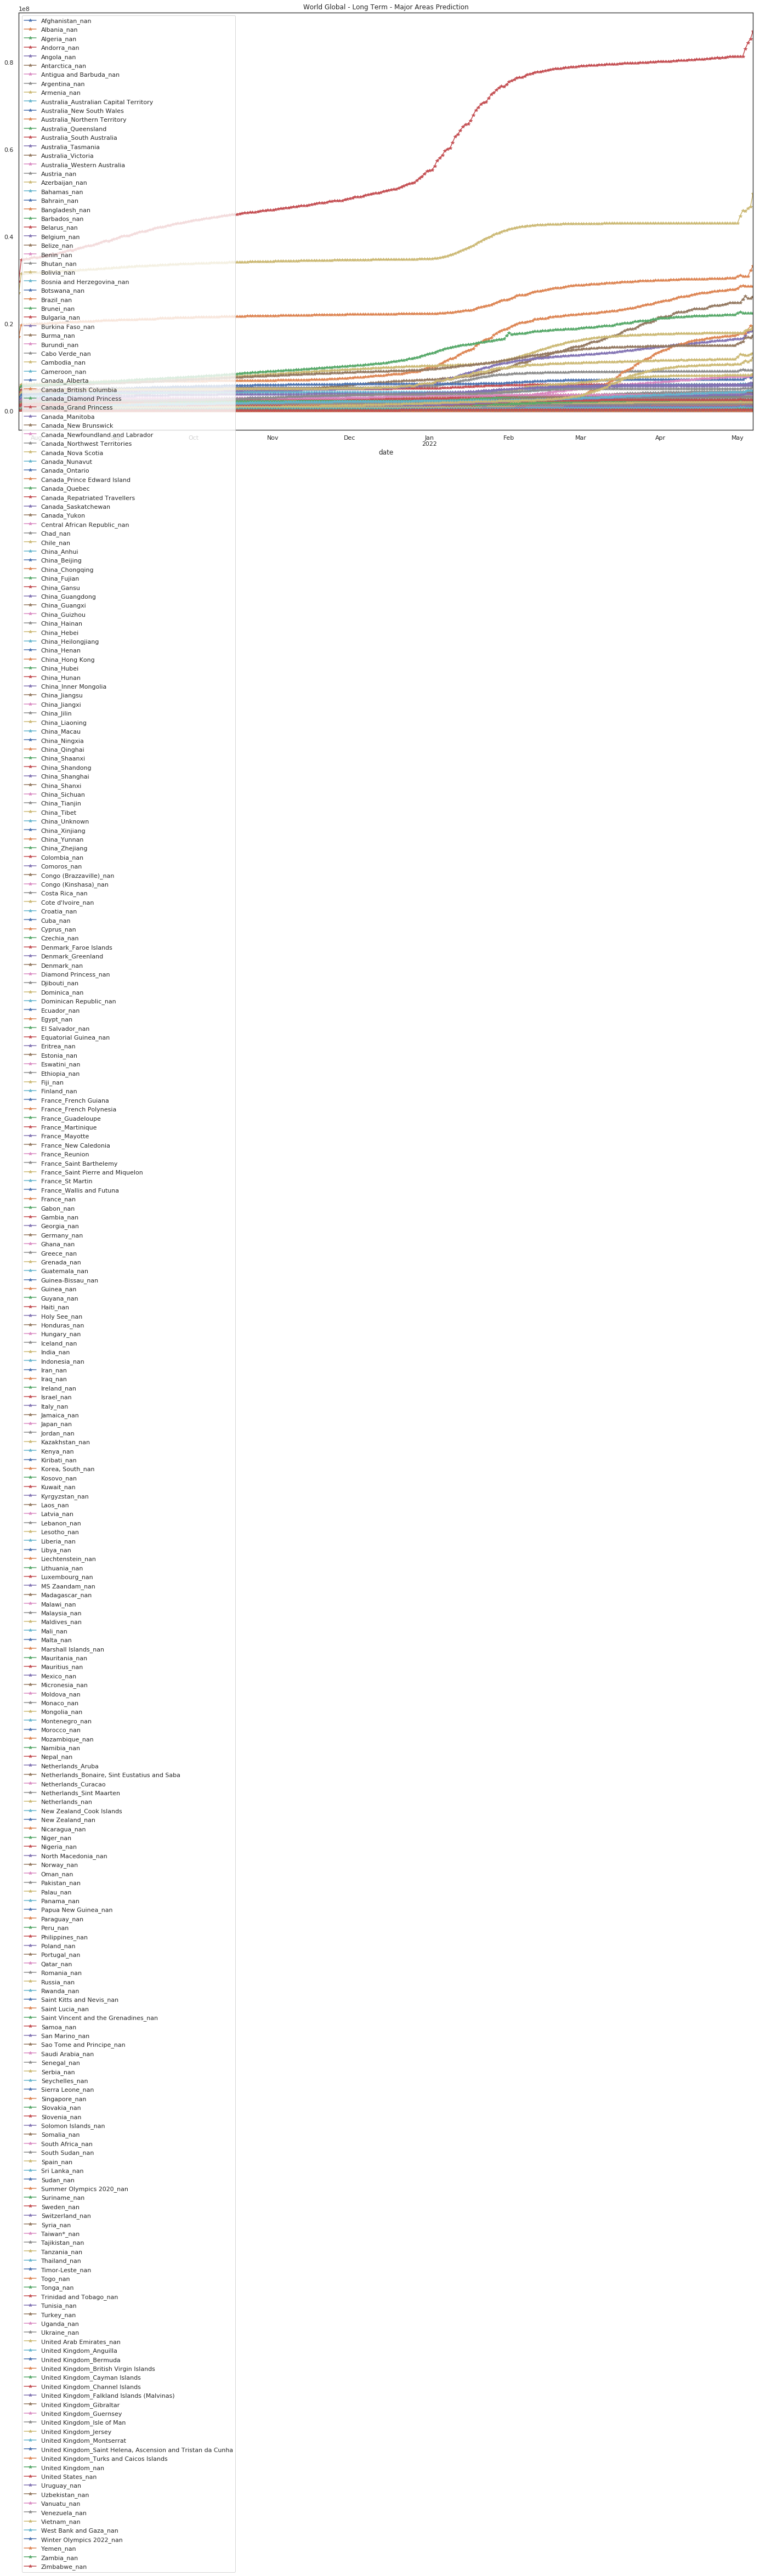

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-09-08         155346.0     154241.0     200476.0      15411.0   
2021-09-09         155450.0     155249.0     200794.0      15422.0   
2021-09-10         155566.0     156241.0     201086.0      15382.0   
2021-09-11         155599.0     157130.0     201352.0      15399.0   
2021-09-12         155605.0     157992.0     201601.0      15426.0   
2021-09-13         155693.0     158463.0     201837.0      15435.0   
2021-09-14         155781.0     159353.0     202066.0      15371.0   
2021-09-15         155885.0     160344.0     202309.0      15433.0   
2021-09-16         155970.0     161302.0     202538.0      15409.0   
2021-09-17         156089.0     162280.0     202772.0      15438.0   
2021-09-18         156109.0     163144.0     202983.0      15409.0   
2021-09-19         156105.0     163927.0     203159.0      15466.0   
2021-09-20         156187.0     164420.0     203325.0      15478.0   
2021-09-21         156310.0     165201.0     203505.0      15395.0   
2021-09-22         156369.0     166049.0     203685.0      15491.0   
2021-09-23         156417.0     166832.0     203850.0      15429.0   
2021-09-24         156560.0     167668.0     204017.0      15488.0   
2021-09-25         156583.0     168362.0     204151.0      15449.0   
2021-09-26         156580.0     168915.0     204293.0      15504.0   
2021-09-27         156674.0     169242.0     204451.0      15522.0   
2021-09-28         156707.0     169771.0     204619.0      15412.0   
2021-09-29         156745.0     170465.0     204778.0      15529.0   
2021-09-30         156792.0     171151.0     204937.0      15472.0   
2021-10-01         156810.0     171818.0     205097.0      15492.0   
2021-10-02         156820.0     172391.0     205239.0      15560.0   
2021-10-03         156818.0     172864.0     205368.0      15555.0   
2021-10-04         156899.0     172922.0     205494.0      15590.0   
2021-10-05         156936.0     173593.0     205624.0      15370.0   
2021-10-06         157000.0     174248.0     205752.0      15602.0   
2021-10-07         157053.0     174780.0     205860.0      15561.0   
...                     ...          ...          ...          ...   
2022-04-08         179592.0     275108.0     267313.0      40328.0   
2022-04-09         179593.0     275155.0     267321.0      40328.0   
2022-04-10         179593.0     275194.0     267325.0      40328.0   
2022-04-11         179738.0     275191.0     267328.0      40328.0   
2022-04-12         179875.0     275231.0     267330.0      40328.0   
2022-04-13         179919.0     275296.0     267332.0      40328.0   
2022-04-14         179968.0     275350.0     267333.0      40709.0   
2022-04-15         179989.0     275407.0     267338.0      40709.0   
2022-04-16         179997.0     275440.0     267340.0      40709.0   
2022-04-17         180023.0     275476.0     267340.0      40709.0   
2022-04-18         180060.0     275497.0     267341.0      40709.0   
2022-04-19         180122.0     275504.0     267347.0      40709.0   
2022-04-20         180188.0     275568.0     267348.0      40709.0   
2022-04-21         180229.0     275592.0     267354.0      41013.0   
2022-04-22         180256.0     275689.0     267363.0      41013.0   
2022-04-23         180267.0     275786.0     267363.0      41013.0   
2022-04-24         180300.0     275803.0     267367.0      41013.0   
2022-04-25         180356.0     275805.0     267372.0      41013.0   
2022-04-26         180386.0     275822.0     267373.0      41013.0   
2022-04-27         180423.0     275892.0     267373.0      41013.0   
2022-04-28         180467.0     275974.0     267376.0      41013.0   
2022-04-29         180492.0     276028.0     267380.0      41349.0   
2022-04-30         180499.0     276080.0     267381.0      41349.0   
2022-05-01         180497.0     276087.0     272577.0      41349.0   
2022-05-02

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                                       Antarctica_nan -71.949900   23.347000   
6                              Antigua and Barbuda_nan  17.060800  -61.796400   
7                                        Argentina_nan -38.416100  -63.616700   
8                                          Armenia_nan  40.069100   45.038200   
9               Australia_Australian Capital Territory -35.473500  149.012400   
10                           Australia_New South Wales -33.868800  151.209300   
11                        Australia_Northern Territory -12.463400  130.845600   
12                                Australia_Queensland -27.469800  153.025100   
13                           Australia_South Australia -34.928500  138.600700   
14                                  Australia_Tasmania -42.882100  147.327200   
15                                  Australia_Victoria -37.813600  144.963100   
16                         Australia_Western Australia -31.950500  115.860500   
17                                         Austria_nan  47.516200   14.550100   
18                                      Azerbaijan_nan  40.143100   47.576900   
19                                         Bahamas_nan  25.025885  -78.035889   
20                                         Bahrain_nan  26.027500   50.550000   
21                                      Bangladesh_nan  23.685000   90.356300   
22                                        Barbados_nan  13.193900  -59.543200   
23                                         Belarus_nan  53.709800   27.953400   
24                                         Belgium_nan  50.833300    4.469936   
25                                          Belize_nan  17.189900  -88.497600   
26                                           Benin_nan   9.307700    2.315800   
27                                          Bhutan_nan  27.514200   90.433600   
28                                         Bolivia_nan -16.290200  -63.588700   
29                          Bosnia and Herzegovina_nan  43.915900   17.679100   
..                                                 ...        ...         ...   
260                                        Tunisia_nan  33.886917    9.537499   
261                                         Turkey_nan  38.963700   35.243300   
262                                  United States_nan  40.000000 -100.000000   
263                                         Uganda_nan   1.373333   32.290275   
264                                        Ukraine_nan  48.379400   31.165600   
265                           United Arab Emirates_nan  23.424076   53.847818   
266                            United Kingdom_Anguilla  18.220600  -63.068600   
267                             United Kingdom_Bermuda  32.307800  -64.750500   
268              United Kingdom_British Virgin Islands  18.420700  -64.640000   
269                      United Kingdom_Cayman Islands  19.313300  -81.254600   
270                     United Kingdom_Channel Islands  49.372300   -2.364400   
271         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
272                           United Kingdom_Gibraltar  36.140800   -5.353600   
273                            United Kingdom_Guernsey  49.448196   -2.589490   
274                         United Kingdom_Isle of Man  54.236100   -4.548100   
275                              United Kingdom_Jersey  49.213800   -2.135800   
276                          United Kingdom_Montserrat  16.742498  -62.187366   
277  United Kingdom_Saint Helena, Ascension and Tri...  -7.946700  -14.355900  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                     region        Lat        Long  \
0       7              Argentina_nan -38.416100  -63.616700   
1      10  Australia_New South Wales -33.868800  151.209300   
2      15         Australia_Victoria -37.813600  144.963100   
3      17                Austria_nan  47.516200   14.550100   
4      21             Bangladesh_nan  23.685000   90.356300   
5      24                Belgium_nan  50.833300    4.469936   
6      31                 Brazil_nan -14.235000  -51.925300   
7      60                  Chile_nan -35.675100  -71.543000   
8      95               Colombia_nan   4.570900  -74.297300   
9     104                Czechia_nan  49.817500   15.473000   
10    107                Denmark_nan  56.263900    9.501800   
11    133                 France_nan  46.227600    2.213700   
12    136                Georgia_nan  42.315400   43.356900   
13    137                Georgia_nan  42.315400   43.356900   
14    138                Germany_nan  51.165691   10.451526   
15    140                 Greece_nan  39.074200   21.824300   
16    150                Hungary_nan  47.162500   19.503300   
17    152                  India_nan  20.593684   78.962880   
18    153              Indonesia_nan  -0.789300  113.921300   
19    154                   Iran_nan  32.427908   53.688046   
20    155                   Iraq_nan  33.223191   43.679291   
21    156                Ireland_nan  53.142400   -7.692100   
22    157                 Israel_nan  31.046051   34.851612   
23    158                 Israel_nan  31.046051   34.851612   
24    159                  Italy_nan  41.871940   12.567380   
25    161                  Japan_nan  36.204824  138.252924   
26    162                 Jordan_nan  31.240000   36.510000   
27    163             Kazakhstan_nan  48.019600   66.923700   
28    166           Korea, South_nan  35.907757  127.766922   
29    183               Malaysia_nan   4.210484  101.975766   
30    190                 Mexico_nan  23.634500 -102.552800   
31    204            Netherlands_nan  52.132600    5.291300   
32    211                 Norway_nan  60.472000    8.468900   
33    213               Pakistan_nan  30.375300   69.345100   
34    218                   Peru_nan  -9.190000  -75.015200   
35    219            Philippines_nan  12.879721  121.774017   
36    220                 Poland_nan  51.919400   19.145100   
37    221               Portugal_nan  39.399900   -8.224500   
38    223                Romania_nan  45.943200   24.966800   
39    224                 Russia_nan  61.524010  105.318756   
40    234                 Serbia_nan  44.016500   21.005900   
41    238               Slovakia_nan  48.669000   19.699000   
42    242           South Africa_nan -30.559500   22.937500   
43    244                  Spain_nan  40.463667   -3.749220   
44    249                 Sweden_nan  60.128161   18.643501   
45    250            Switzerland_nan  46.818200    8.227500   
46    255               Thailand_nan  15.870032  100.992541   
47    261                 Turkey_nan  38.963700   35.243300   
48    262          United States_nan  40.000000 -100.000000   
49    264                Ukraine_nan  48.379400   31.165600   
50    279         United Kingdom_nan  55.378100   -3.436000   
51    284                Vietnam_nan  14.058324  108.277199   

    2021-07-25 00:00:00  2021-07-26 00:00:00  2021-07-27 00:00:00  \
0             4244493.0            4846615.0            4874356.0   
1               92299.0              92449.0               8118.0   
2              103429.0             103438.0              20924.0   
3              648645.0             656270.0             656582.0   
4             1084887.0            1164635.0            1195456.0   
5             1040977.0            1113465.0            1117697.0   
6            16984811.0           19693277.0           19755568.0   
7             1466360.0            1609177.0            1610345.0   
8             4142574.0            4727846.

In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()

In [94]:
num_days_R_prediction=14
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)
print(str(ndaysavg)+' '+str(ndayarray)+' '+str(n2dayarray))

14 -15 -29
